Analysis for IndeLLM

In [13]:
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Import data
overall = pd.read_csv("../Results/overall.csv")
alldata = pd.read_csv("../Data/Indel_curated.csv")

overall.head()
alldata.head()

#Identified error in mut sequence, remove the ids from overall that has no protein stop, and "-" in wt in the alldata file
filtered_alldata = alldata[alldata['Protein_stop'].notnull() & (alldata['wt'] != '-')]

overall = overall[overall['pair_id'].isin(filtered_alldata['Id_matching'])]

overall

,pair_id,length_mut,length_wt,evo_mut,evo_wt,fit_mut,fit_wt,label
0,0,334,329,300.976887,295.771454,183.474468,181.478358,Benign/Likely benign
1,1,326,329,289.070291,295.771454,175.395118,181.483721,Pathogenic
2,2,437,445,394.023689,407.087317,202.841284,211.450276,Likely pathogenic
3,4,445,446,407.261862,408.398288,197.364461,198.448622,likely benign
4,5,339,340,279.895415,282.956223,169.600709,175.565114,Pathogenic


,Unnamed: 0,Id_matching,Feature_x,Consequence_x,Protein_start,Protein_stop,wt,mut,seq,GeneID,...,DDD subset (n=151),CADD,CAPICE,FATHMM-indel,MutPredIndel,MutationTaster2021,PROVEAN,SIFT-indel,VEST-indel,VVP
0,0,0,ENST00000379198.5,inframe_insertion,4,NaN,L,LRRAWR,MKLLRRAWRRRAALGLGTLALCGAALLYLARCAAEPGDPRAMSGRS...,ENSG00000176022,...,No,12.37,0.073788,0.194999931,0.61176,Benign,-3.44,damaging,0.05,7.0
1,1,1,ENST00000379198.5,inframe_deletion,136,139.0,VLAM,V,MKLLRRAWRRRAALGLGTLALCGAALLYLARCAAEPGDPRAMSGRS...,ENSG00000176022,...,No,22.40,0.448487,0.912278105,0.71407,Deleterious,-11.00,damaging,0.23,98.0
2,2,2,ENST00000476993.2,inframe_deletion,61,69.0,VAPLPLGTG,V,MLPWTALGLALSLRLALARSGAERGPPASAPRGDLMFLLDSSASVS...,ENSG00000179403,...,No,21.60,0.570002,0.99589538,0.60790,Deleterious,-27.11,neutral,0.07,100.0
3,3,3,ENST00000404249.8,inframe_deletion,312,314.0,EEE,E,MGDEKDSWKVKTLDEILQEKKRRKEQEEKAEIKRLKNSDDRDSKRD...,ENSG00000008128,...,No,15.81,0.005563,0.466641233,0.11935,Benign,-2.76,neutral,0.10,15.0
4,4,4,ENST00000341426.9,inframe_deletion,445,446.0,EG,G,MEMEQEKMTMNKELSPDAAAYCCSACHGDETWSYNHPIRGRAKSRS...,ENSG00000008130,...,No,6.09,0.001876,0.008217187,0.38066,Benign,-1.90,damaging,0.29,95.0


,pair_id,length_mut,length_wt,evo_mut,evo_wt,fit_mut,fit_wt,label
1,1,326,329,289.070291,295.771454,175.395118,181.483721,Pathogenic
2,2,437,445,394.023689,407.087317,202.841284,211.450276,Likely pathogenic
3,4,445,446,407.261862,408.398288,197.364461,198.448622,likely benign
4,5,339,340,279.895415,282.956223,169.600709,175.565114,Pathogenic
6,23,188,189,176.534783,182.042672,123.452016,126.516669,Likely pathogenic
...,...,...,...,...,...,...,...,...
1109,3949,497,498,418.434276,419.464672,86.138481,83.438182,Likely benign
1111,3951,497,498,418.437425,419.464672,83.422272,83.439074,Benign
1112,3955,249,254,185.200489,188.079561,34.459002,34.142145,Likely pathogenic
1113,3957,418,419,315.153689,318.666419,76.947414,79.589427,Likely pathogenic


In [14]:
import numpy as np

#Add indel type (insertion or deletion) info
overall['indel'] = overall.apply(lambda row: 'deletion' if row['length_mut'] < row['length_wt'] else 'insertion', axis=1)

#Add indel length 
overall['length_indel'] = overall.apply(lambda row: row['length_wt'] - row['length_mut'] if row['indel'] == 'deletion' else row['length_mut'] - row['length_wt'], axis=1) 

#Add difference of fitness (positive value positive effect, negative value negative effect)
overall['dif_evo'] = overall['evo_mut'] - overall['evo_wt']
overall['dif_fit'] = overall['fit_mut'] - overall['fit_wt']

#Add a cleaned up labels info
overall['labels_cleaned'] = np.where(overall['label'].str.contains('benign', case=False, na=False), 
                                'Benign', 
                                np.where(overall['label'].str.contains('pathogenic', case=False, na=False), 
                                         'Pathogenic', 
                                         np.nan))

overall.head()

,pair_id,length_mut,length_wt,evo_mut,evo_wt,fit_mut,fit_wt,label,indel,length_indel,dif_evo,dif_fit,labels_cleaned
1,1,326,329,289.070291,295.771454,175.395118,181.483721,Pathogenic,deletion,3,-6.701162,-6.088603,Pathogenic
2,2,437,445,394.023689,407.087317,202.841284,211.450276,Likely pathogenic,deletion,8,-13.063628,-8.608993,Pathogenic
3,4,445,446,407.261862,408.398288,197.364461,198.448622,likely benign,deletion,1,-1.136426,-1.084161,Benign
4,5,339,340,279.895415,282.956223,169.600709,175.565114,Pathogenic,deletion,1,-3.060808,-5.964405,Pathogenic
6,23,188,189,176.534783,182.042672,123.452016,126.516669,Likely pathogenic,deletion,1,-5.507889,-3.064654,Pathogenic


In [15]:
#Calculating the average dif values per bening and pathogenic
evomeanpath = overall[overall['labels_cleaned'] == 'Pathogenic']['dif_evo'].mean()
evomeanbeg = overall[overall['labels_cleaned'] == 'Benign']['dif_evo'].mean()

fitmeanpath = overall[overall['labels_cleaned'] == 'Pathogenic']['dif_fit'].mean()
fitmeanbeg = overall[overall['labels_cleaned'] == 'Benign']['dif_fit'].mean()

print("Evo Model, mean for pathogenic indels:", evomeanpath)
print("Evo Model, mean for begign indels:", evomeanbeg)
print("Fit Model, mean for pathogenic indels:", fitmeanpath)
print("Fit Model, mean for benign indels", fitmeanbeg)

Evo Model, mean for pathogenic indels: -5.760121855252785
Evo Model, mean for begign indels: -4.586879515294996
Fit Model, mean for pathogenic indels: -4.790591169140645
Fit Model, mean for benign indels -2.1473084966128084


Text(0, 0.5, 'Difference Evo Model')

Text(0.5, 0, 'Ids of indels')

Text(0.5, 1.0, 'Evo difference per indel, colored by true labels')

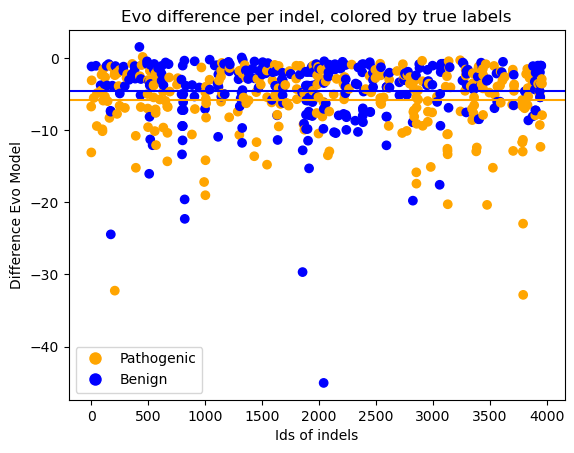

Text(0, 0.5, 'Difference Fit Model')

Text(0.5, 0, 'Ids of indels')

Text(0.5, 1.0, 'Fit difference per indel, colored by true labels')

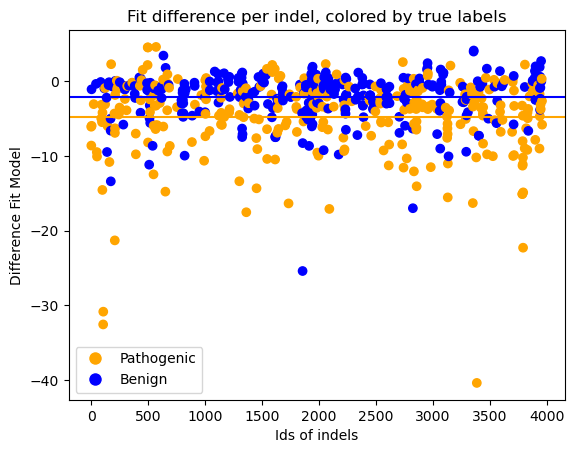

Text(0.5, 0, 'fit')

Text(0, 0.5, 'evo')

Text(0.5, 1.0, 'Comapring the Fit and Evo difference scores, colored by true labels')

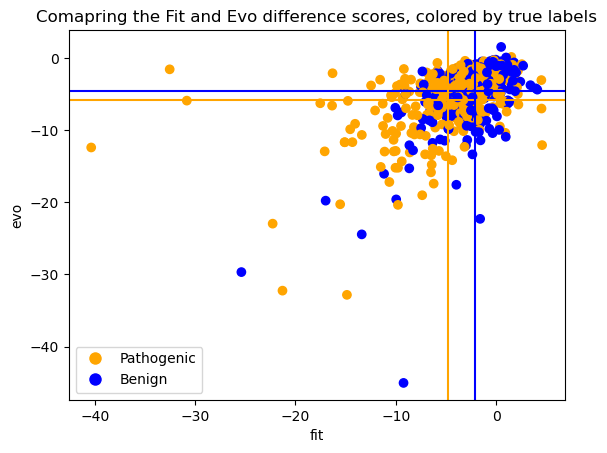

In [16]:
import matplotlib.pyplot as plt

#Creating colors for labels
color_map = {'Pathogenic': 'orange', 'Benign': 'blue'}
colors = overall['labels_cleaned'].map(color_map)
legend_labels = {label: color for label, color in color_map.items() if label in overall['labels_cleaned'].unique()}
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=color)
           for label, color in legend_labels.items()]

#Plotting evo scores
plt.scatter(overall['pair_id'],overall['dif_evo'], c=colors)
plt.ylabel('Difference Evo Model')
plt.xlabel('Ids of indels')
plt.title('Evo difference per indel, colored by true labels')
plt.axhline(y=evomeanpath, color = 'orange')
plt.axhline(y=evomeanbeg, color = 'blue')
plt.legend(handles=handles, loc = 'best')
plt.show()

#Plotting fit scores
plt.scatter(overall['pair_id'],overall['dif_fit'], c=colors)
plt.ylabel('Difference Fit Model')
plt.xlabel('Ids of indels')
plt.title('Fit difference per indel, colored by true labels')
plt.axhline(y=fitmeanpath, color = 'orange')
plt.axhline(y=fitmeanbeg, color = 'blue')
plt.legend(handles=handles, loc = 'best')
plt.show()

#Plotting evo and fit scores together
plt.scatter(overall['dif_fit'], overall['dif_evo'], c=colors)
plt.xlabel('fit')
plt.ylabel('evo')
plt.title('Comapring the Fit and Evo difference scores, colored by true labels')
plt.axhline(y=evomeanpath, color = 'orange')
plt.axhline(y=evomeanbeg, color = 'blue')
plt.axvline(x=fitmeanpath, color = 'orange')
plt.axvline(x=fitmeanbeg, color = 'blue')
plt.legend(handles=handles, loc = 'best')
plt.show()

In [17]:
#identifying the low scoring benign
fit_under10 = overall.loc[(overall['labels_cleaned'] == 'Benign') & (overall['dif_fit'] < -10)]
print(fit_under10)

#Partly explained by indel size. Removed indels larger than 10bp
overall_small = overall[overall['length_indel'] < 11]

#Looking into the larger indels
overall_large = overall[overall['length_indel'] >= 11]

overall_large.describe()
overall_large['indel'].value_counts()
overall_large['labels_cleaned'].value_counts()
overall_large[overall_large['length_wt'] <= 250]

overall_large[overall_large['labels_cleaned'] == 'Benign']
overall_large[overall_large['labels_cleaned'] == 'Pathogeic']

     pair_id  length_mut  length_wt     evo_mut      evo_wt     fit_mut  \
46       173          65         89   50.657067   75.090821   11.368289   
128      510         104        120   87.960535  103.989124   23.302300   
484     1856         387        419  324.009807  353.677322  132.405266   
817     2824         403        423  330.160794  349.916364  140.703721   
906     3137         457        464  368.514415  375.380665  162.916523   

         fit_wt          label     indel  length_indel    dif_evo    dif_fit  \
46    24.760969  likely benign  deletion            24 -24.433754 -13.392679   
128   34.468675  likely benign  deletion            16 -16.028588 -11.166375   
484  157.797233  likely benign  deletion            32 -29.667515 -25.391967   
817  157.693906  likely benign  deletion            20 -19.755570 -16.990184   
906  172.963818  likely benign  deletion             7  -6.866250 -10.047295   

    labels_cleaned  
46          Benign  
128         Benign  
484  

,pair_id,length_mut,length_wt,evo_mut,evo_wt,fit_mut,fit_wt,length_indel,dif_evo,dif_fit
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,2064.629630,319.074074,336.185185,258.997388,276.049529,76.729570,85.259691,17.111111,-17.052142,-8.530121
std,1295.319715,118.190500,115.324638,99.180265,96.427913,40.883371,43.436315,8.210375,8.795967,6.599541
min,173.000000,65.000000,89.000000,50.657067,75.090821,11.368289,24.760969,11.000000,-45.048073,-25.391967
25%,821.500000,271.000000,293.000000,218.022607,239.592315,47.360574,49.317011,12.000000,-19.669078,-12.279527
50%,1904.000000,375.000000,388.000000,281.497225,303.778462,67.406131,73.738986,15.000000,-12.770435,-8.277852
75%,3421.500000,386.000000,408.000000,332.959821,347.129327,108.955467,123.934232,18.500000,-11.412284,-3.074755
max,3944.000000,487.000000,498.000000,410.206069,419.464672,149.521275,157.799127,48.000000,-9.258603,0.965669


indel
deletion    27
Name: count, dtype: int64

labels_cleaned
Benign        19
Pathogenic     8
Name: count, dtype: int64

,pair_id,length_mut,length_wt,evo_mut,evo_wt,fit_mut,fit_wt,label,indel,length_indel,dif_evo,dif_fit,labels_cleaned
46,173,65,89,50.657067,75.090821,11.368289,24.760969,likely benign,deletion,24,-24.433754,-13.392679,Benign
128,510,104,120,87.960535,103.989124,23.302300,34.468675,likely benign,deletion,16,-16.028588,-11.166375,Benign
137,519,95,108,80.567751,91.823535,21.484014,27.063088,likely benign,deletion,13,-11.255784,-5.579073,Benign
223,821,199,219,147.909487,167.492073,38.930968,48.889329,likely benign,deletion,20,-19.582586,-9.958361,Benign
592,2041,121,169,111.753334,156.801407,23.358436,32.584546,likely benign,deletion,48,-45.048073,-9.226110,Benign
880,3059,220,235,146.068376,163.619736,30.473614,34.434395,likely benign,deletion,15,-17.551360,-3.960781,Benign


,pair_id,length_mut,length_wt,evo_mut,evo_wt,fit_mut,fit_wt,label,indel,length_indel,dif_evo,dif_fit,labels_cleaned
46,173,65,89,50.657067,75.090821,11.368289,24.760969,likely benign,deletion,24,-24.433754,-13.392679,Benign
128,510,104,120,87.960535,103.989124,23.302300,34.468675,likely benign,deletion,16,-16.028588,-11.166375,Benign
137,519,95,108,80.567751,91.823535,21.484014,27.063088,likely benign,deletion,13,-11.255784,-5.579073,Benign
207,798,301,314,231.993611,245.327420,46.957024,49.314671,Benign/Likely benign,deletion,13,-13.333809,-2.357647,Benign
212,803,303,314,233.939358,245.327420,47.764124,49.319351,Likely benign,deletion,11,-11.388062,-1.555227,Benign
223,821,199,219,147.909487,167.492073,38.930968,48.889329,likely benign,deletion,20,-19.582586,-9.958361,Benign
224,822,354,377,281.497225,303.778462,64.025534,65.614232,likely benign,deletion,23,-22.281237,-1.588698,Benign
277,1115,314,325,229.832402,240.728560,56.392692,55.427023,likely benign,deletion,11,-10.896159,0.965669,Benign
334,1325,376,388,273.505981,285.242636,67.406131,73.738986,likely_benign,deletion,12,-11.736655,-6.332854,Benign
428,1637,462,479,331.736489,343.070934,100.613429,103.485030,Likely benign,deletion,17,-11.334445,-2.871601,Benign


,pair_id,length_mut,length_wt,evo_mut,evo_wt,fit_mut,fit_wt,label,indel,length_indel,dif_evo,dif_fit,labels_cleaned


In [18]:
#Re-calculate a new mean for the small indels
evomeanpathsmall = overall_small[overall_small['labels_cleaned'] == 'Pathogenic']['dif_evo'].mean()
evomeanbegsmall = overall_small[overall_small['labels_cleaned'] == 'Benign']['dif_evo'].mean()
fitmeanpathsmall = overall_small[overall_small['labels_cleaned'] == 'Pathogenic']['dif_fit'].mean()
fitmeanbegsmall = overall_small[overall_small['labels_cleaned'] == 'Benign']['dif_fit'].mean()

#Compare the new means
print("Evo Model, mean for pathogenic indels:", evomeanpath)
print("Evo Model, mean for small pathogenic indels:", evomeanpathsmall)
print("Evo Model, mean for benign indels:", evomeanbeg)
print("Evo Model, mean for small benign indels:", evomeanbegsmall)

print("Fit Model, mean for pathogenic indels:", fitmeanpath)
print("Fit Model, mean for small pathogenic indels:", fitmeanpathsmall)
print("Fit Model, mean for benign indels", fitmeanbeg)
print("Fit Model, mean for small benign indels", fitmeanbegsmall)

Evo Model, mean for pathogenic indels: -5.760121855252785
Evo Model, mean for small pathogenic indels: -5.448857402047527
Evo Model, mean for benign indels: -4.586879515294996
Evo Model, mean for small benign indels: -3.7390486611328786
Fit Model, mean for pathogenic indels: -4.790591169140645
Fit Model, mean for small pathogenic indels: -4.588509831749451
Fit Model, mean for benign indels -2.1473084966128084
Fit Model, mean for small benign indels -1.8139728396050363


Text(0, 0.5, 'Difference Evo Model')

Text(0.5, 0, 'Ids for indels')

Text(0.5, 1.0, 'Evo difference per small indel, colored by true labels')

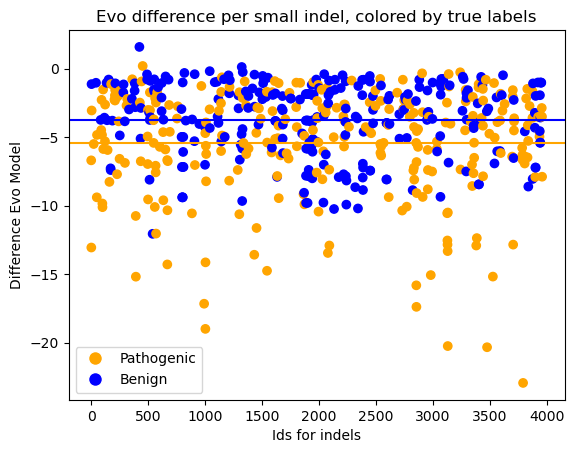

Text(0, 0.5, 'Difference Fit Model ')

Text(0.5, 0, 'Ids for indels')

Text(0.5, 1.0, 'Fit difference per small indel, colored by true labels')

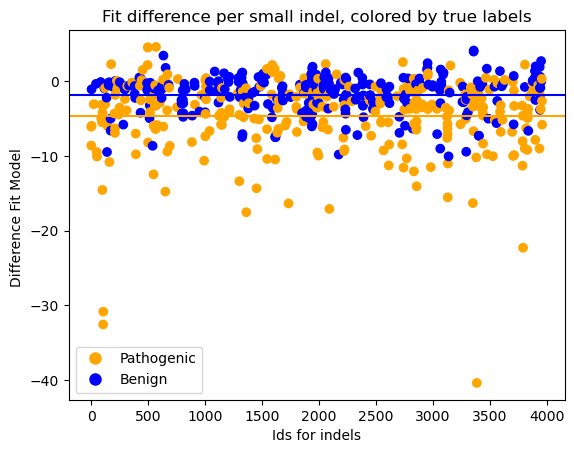

Text(0.5, 0, 'Difference Fit Model')

Text(0, 0.5, 'Difference Evo Model')

Text(0.5, 1.0, 'Comapring the Fit and Evo difference scores for small indels, colored by true labels ')

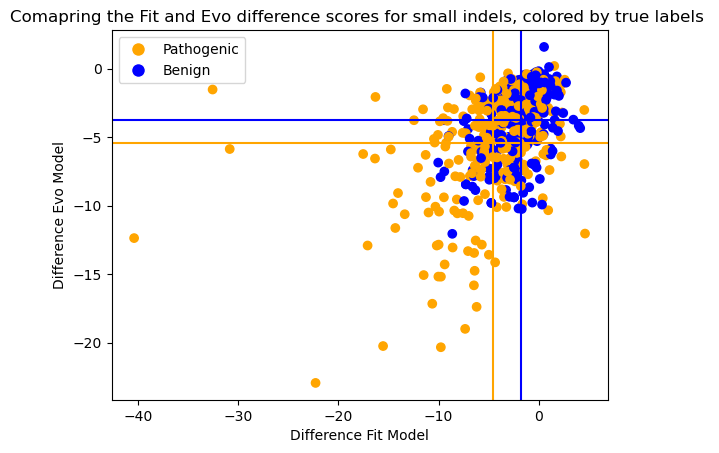

<Axes: xlabel='labels_cleaned', ylabel='dif_evo'>

Text(0.5, 1.0, 'Evo Model')

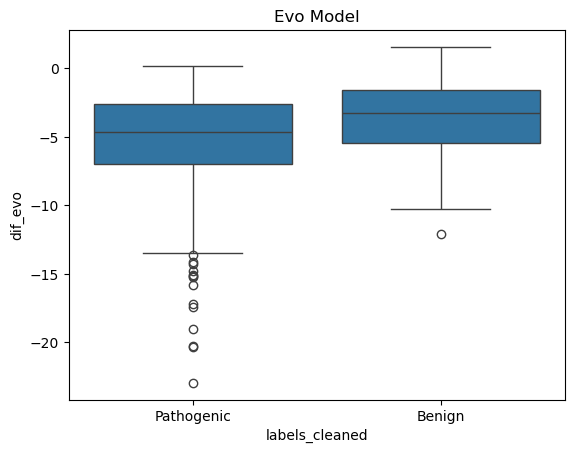

<Axes: xlabel='labels_cleaned', ylabel='dif_fit'>

Text(0.5, 1.0, 'Fit Model')

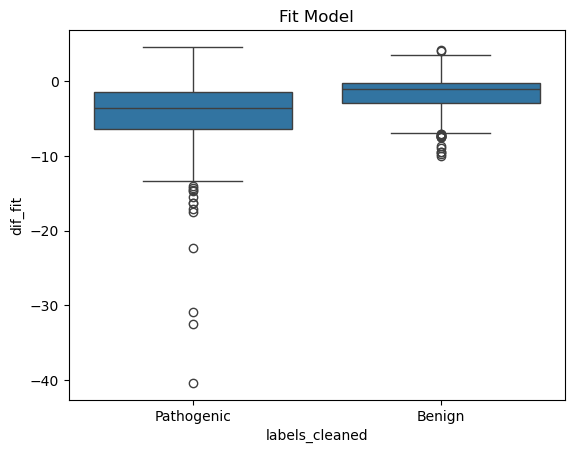

In [19]:
import seaborn as sns
#Plotting for only indels of 10bp or less

#Creating a new colormap for the labels
colors_small = overall_small['labels_cleaned'].map(color_map)
legend_labels_small = {label: color for label, color in color_map.items() if label in overall_small['labels_cleaned'].unique()}
handles_small = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=color)
           for label, color in legend_labels_small.items()]

#Plotting evo scores for small indels
plt.scatter(overall_small['pair_id'],overall_small['dif_evo'], c=colors_small)
plt.ylabel('Difference Evo Model')
plt.xlabel('Ids for indels')
plt.title('Evo difference per small indel, colored by true labels')
plt.axhline(y=evomeanpathsmall, color = 'orange')
plt.axhline(y=evomeanbegsmall, color = 'blue')
plt.legend(handles=handles_small, loc = 'best')
plt.show()

#Plotting fit scores for small indels
plt.scatter(overall_small['pair_id'],overall_small['dif_fit'], c=colors_small)
plt.ylabel('Difference Fit Model ')
plt.xlabel('Ids for indels')
plt.title('Fit difference per small indel, colored by true labels')
plt.axhline(y=fitmeanpathsmall, color = 'orange')
plt.axhline(y=fitmeanbegsmall, color = 'blue')
plt.legend(handles=handles_small, loc = 'best')
plt.show()

#Plotting fit and evo scores for small indels
plt.scatter(overall_small['dif_fit'], overall_small['dif_evo'], c=colors_small)
plt.xlabel('Difference Fit Model')
plt.ylabel('Difference Evo Model')
plt.title('Comapring the Fit and Evo difference scores for small indels, colored by true labels ')
plt.axhline(y=evomeanpathsmall, color = 'orange')
plt.axhline(y=evomeanbegsmall, color = 'blue')
plt.axvline(x=fitmeanpathsmall, color = 'orange')
plt.axvline(x=fitmeanbegsmall, color = 'blue')
plt.legend(handles=handles_small, loc = 'best')
plt.show()

#Also included boxplots
sns.boxplot(x = overall_small['labels_cleaned'], y = overall_small['dif_evo'])
plt.title('Evo Model')
plt.show()

sns.boxplot(x = overall_small['labels_cleaned'], y = overall_small['dif_fit'])
plt.title('Fit Model')
plt.show()

F1 score Evo small indels: 0.5142857142857142
F1 score Fit small indels: 0.6993464052287581
Accuracy score Evo small indels: 0.6088495575221239
Accuracy score Fit small indels: 0.6743362831858407
MCC Evo small indels: 0.23541761480539736
MCC Fit small indels: 0.35401081224933056


/tmp/ipykernel_3596441/926566019.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overall_small['labels_binary'] = overall_small.apply(lambda row: 0 if row['labels_cleaned'] == 'Pathogenic' else 1, axis=1)


Text(0.5, 0, 'False Positives (Specificty)')

Text(0, 0.5, 'Trule Positives (Sensitivity)')

Text(0.5, 1.0, 'ROC Curve for our predictions')

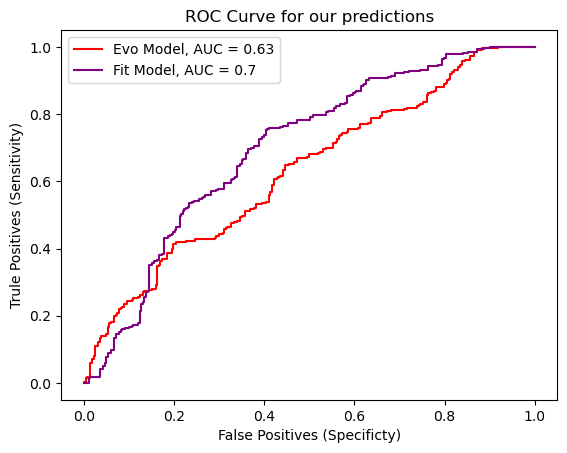

In [20]:
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import f1_score, accuracy_score, matthews_corrcoef

#Turing the true lables into binary
overall_small['labels_binary'] = overall_small.apply(lambda row: 0 if row['labels_cleaned'] == 'Pathogenic' else 1, axis=1)

#Extrating Arrays
truelabels = overall_small['labels_binary'].values
pred_evo = overall_small['dif_evo'].values
pred_fit = overall_small['dif_fit'].values

#Calculating FP, TN and thresholds for Evo and Fit
fpr_evo, tpr_evo, thersholds_evo = metrics.roc_curve(truelabels, pred_evo)
roc_auc_evo = round(metrics.auc(fpr_evo, tpr_evo), 2)

fpr_fit, tpr_fit, thersholds_fit = metrics.roc_curve(truelabels, pred_fit)
roc_auc_fit = round(metrics.auc(fpr_fit, tpr_fit), 2)

#Using the threshold to create a binary table of the predicted values
#Find the best threshold
tresh_evo = thersholds_evo[np.argmax(tpr_evo - fpr_evo)]
tresh_fit = thersholds_fit[np.argmax(tpr_fit - fpr_fit)]

#Converting the continous predictions into binary
pred_evo_bin = [1 if x >= tresh_evo else 0 for x in pred_evo]
pred_fit_bin = [1 if x >= tresh_fit else 0 for x in pred_fit]

#Calculating F1 score
f1_evo = f1_score(truelabels, pred_evo_bin, average = 'binary')
f1_fit = f1_score(truelabels, pred_fit_bin, average = 'binary')

print("F1 score Evo small indels:", f1_evo)
print("F1 score Fit small indels:", f1_fit)

#Calculating accuary score
accuracy_evo = accuracy_score(truelabels, pred_evo_bin)
accuracy_fit = accuracy_score(truelabels, pred_fit_bin)

print("Accuracy score Evo small indels:", accuracy_evo)
print("Accuracy score Fit small indels:", accuracy_fit)

#Calculating MCC
mcc_evo = matthews_corrcoef(truelabels, pred_evo_bin)
mcc_fit = matthews_corrcoef(truelabels, pred_fit_bin)

print("MCC Evo small indels:", mcc_evo)
print("MCC Fit small indels:", mcc_fit)

#Plotting the Evo and Fit AUC 
plt.plot(fpr_evo, tpr_evo, label = "Evo Model, AUC = "+str(roc_auc_evo), color = "red")
plt.plot(fpr_fit, tpr_fit, label = "Fit Model, AUC = "+str(roc_auc_fit), color = "purple")
plt.xlabel('False Positives (Specificty)')
plt.ylabel('Trule Positives (Sensitivity)')
plt.title("ROC Curve for our predictions")
plt.legend(loc = 'best')
plt.show()

Number of indels: 565
Correctly called by Evo: 344
Correctly called by Fit: 381
Correctly called by both: 257
Failed by both: 97
Failed by Evo, but correcly by Fit: 124
Failed by Fit, but correcly by Evo: 87


<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

Text(0.5, 1.0, 'Procentage of indel type')

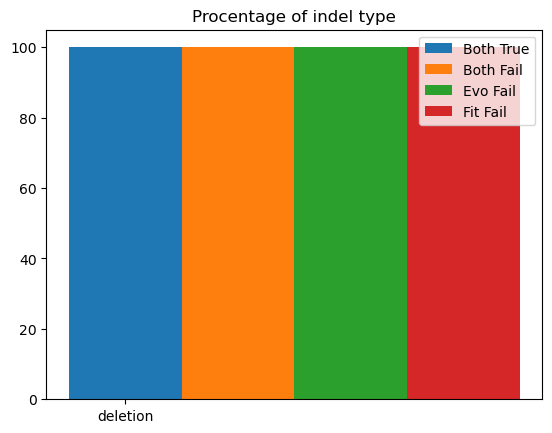

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

([<matplotlib.axis.XTick at 0x741b32185610>,
 [Text(0, 0, '1'), Text(1, 0, '2-4'), Text(2, 0, '5-10')])

Text(0.5, 1.0, 'Procentage of indel size')

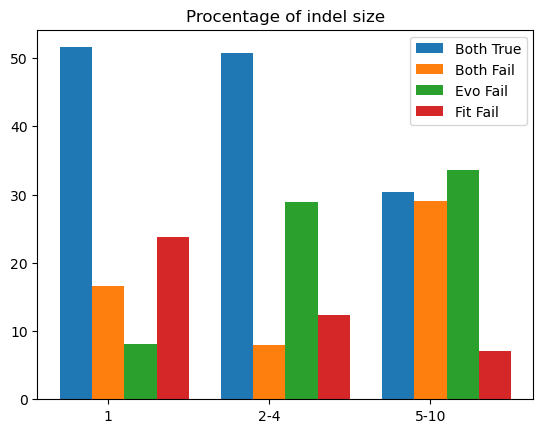

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

([<matplotlib.axis.XTick at 0x741b3a74d6a0>,
 [Text(0, 0, '0-250'), Text(1, 0, '251-500')])

Text(0.5, 1.0, 'Procentage of wt aa length')

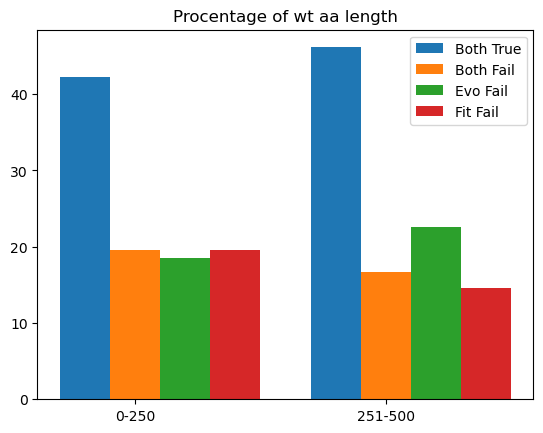

In [107]:
# Differences between Evo and Fit model
sum = pd.DataFrame(overall_small['pair_id'], columns=['pair_id'])
sum['labels_cleaned'] = overall_small['labels_cleaned']
sum['Indel size'] = overall_small['length_indel']
sum['Indel type'] = overall_small['indel']
sum['Protein length'] = overall_small['length_wt']
sum['Evo_scores'] = pred_evo_bin
sum['Fit_scores'] = pred_fit_bin

#Check which IDs the model calls correctly
sum['Evo_correct'] = None 
sum['Fit_correct'] = None
sum.loc[((sum['Evo_scores'] == 1) & (sum['labels_cleaned'] == 'Benign')) | 
        ((sum['Evo_scores'] == 0) & (sum['labels_cleaned'] == 'Pathogenic')), 'Evo_correct'] = 'True'
sum.loc[((sum['Fit_scores'] == 1) & (sum['labels_cleaned'] == 'Benign')) | 
        ((sum['Fit_scores'] == 0) & (sum['labels_cleaned'] == 'Pathogenic')), 'Fit_correct'] = 'True'

#Dataframes with correcly called by both, failed by both, and what one manages and the other don't
Evocorrect = sum.loc[((sum['Evo_correct'] == 'True'))]
Fitcorrect = sum.loc[((sum['Fit_correct'] == 'True'))]
Evofail = sum.loc[((sum['Evo_correct'].isnull()))]
Fitfail = sum.loc[((sum['Fit_correct'].isnull()))]
BothTrue = sum.loc[((sum['Evo_correct'] == 'True') & (sum['Fit_correct'] == 'True'))]
BothFail = sum.loc[((sum['Evo_correct'].isnull()) & (sum['Fit_correct'].isnull()))]
EvoFail = sum.loc[((sum['Evo_correct'].isnull()) & (sum['Fit_correct'] == 'True'))]
FitFail = sum.loc[((sum['Evo_correct'] == 'True') & (sum['Fit_correct'].isnull()))]

print("Number of indels:", len(sum))
print("Correctly called by Evo:", len(Evocorrect))
print("Correctly called by Fit:", len(Fitcorrect))
print("Correctly called by both:", len(BothTrue))
print("Failed by both:", len(BothFail))
print("Failed by Evo, but correcly by Fit:", len(EvoFail))
print("Failed by Fit, but correcly by Evo:", len(FitFail))

#Check if its related to type of indel
Evocorrect_indeltype = Evocorrect['Indel type'].value_counts()
Fitcorrect_indeltype = Fitcorrect['Indel type'].value_counts()
Evofail_indeltype = Evofail['Indel type'].value_counts()
Fitfail_indeltype = Fitfail['Indel type'].value_counts()

BothTrue_indeltype = BothTrue['Indel type'].value_counts()
BothFail_indeltype = BothFail['Indel type'].value_counts()
EvoFail_indeltype = EvoFail['Indel type'].value_counts()
FitFail_indeltype = FitFail['Indel type'].value_counts()

plt.bar(BothTrue_indeltype.index, ((BothTrue_indeltype.values / len(BothTrue)) * 100), 0.2, label = 'Both True')
plt.bar(np.arange(len(BothFail_indeltype.index)) + 0.2, ((BothFail_indeltype.values / len(BothFail)) * 100), 0.2, label = 'Both Fail')
plt.bar(np.arange(len(EvoFail_indeltype.index)) + 0.4, ((EvoFail_indeltype.values / len(EvoFail)) * 100), 0.2, label = 'Evo Fail')
plt.bar(np.arange(len(FitFail_indeltype.index)) + 0.6, ((FitFail_indeltype.values / len(FitFail)) * 100), 0.2, label = 'Fit Fail')
plt.legend(loc = 'best')
plt.title('Procentage of indel type')
plt.show()

#Check if its related to indel size
Evocorrect_indelsize = Evocorrect['Indel size'].value_counts()
Fitcorrect_indelsize = Fitcorrect['Indel size'].value_counts()
Evofail_indelsize = Evofail['Indel size'].value_counts()
Fitfail_indelsize = Fitfail['Indel size'].value_counts()

BothTrue_indelsize = BothTrue['Indel size'].value_counts()
BothFail_indelsize = BothFail['Indel size'].value_counts()
EvoFail_indelsize = EvoFail['Indel size'].value_counts()
FitFail_indelsize = FitFail['Indel size'].value_counts()

indelsize = pd.DataFrame({
    'BothTrue': BothTrue_indelsize,
    'BothFail': BothFail_indelsize,
    'EvoFail': EvoFail_indelsize,
    'FitFail': FitFail_indelsize
}).fillna(0)

indelsize2 = pd.DataFrame({
    'Evocorrect': Evocorrect_indelsize,
    'Fitcorrect': Fitcorrect_indelsize,
    'EvoFail': EvoFail_indelsize,
    'FitFail': FitFail_indelsize
}).fillna(0)

#Group the indel sizes after Cannon et al. 2023 (1, 2-4, 5-10 and 11+)

indels2to4 = indelsize.loc[2:4].sum()
indels5to10 = indelsize.loc[5:10].sum()

indels2to4_2 = indelsize2.loc[2:4].sum()
indels5to10_2 = indelsize2.loc[5:10].sum()

indelsize_grouped = pd.DataFrame({
    'Indel size': ['1', '2-4', '5-10'],
    'BothTrue': [indelsize.loc[1, 'BothTrue'], indels2to4['BothTrue'], indels5to10['BothTrue']],
    'BothFail': [indelsize.loc[1, 'BothFail'], indels2to4['BothFail'], indels5to10['BothFail']],
    'EvoFail': [indelsize.loc[1, 'EvoFail'], indels2to4['EvoFail'], indels5to10['EvoFail']],
    'FitFail': [indelsize.loc[1, 'FitFail'], indels2to4['FitFail'], indels5to10['FitFail']]
})

indelsize_grouped2 = pd.DataFrame({
    'Indel size': ['1', '2-4', '5-10'],
    'Evocorrect': [indelsize2.loc[1, 'Evocorrect'], indels2to4_2['Evocorrect'], indels5to10_2['Evocorrect']],
    'Fitcorrect': [indelsize2.loc[1, 'Fitcorrect'], indels2to4_2['Fitcorrect'], indels5to10_2['Fitcorrect']],
    'EvoFail': [indelsize2.loc[1, 'EvoFail'], indels2to4_2['EvoFail'], indels5to10_2['EvoFail']],
    'FitFail': [indelsize2.loc[1, 'FitFail'], indels2to4_2['FitFail'], indels5to10_2['FitFail']]
})

labels = ['1', '2-4', '5-10']

#Calculate procentage
indelsum = indelsize_grouped[['BothTrue', 'BothFail', 'EvoFail', 'FitFail']].sum(axis=1)
percentage = indelsize_grouped[['BothTrue', 'BothFail', 'EvoFail', 'FitFail']].div(indelsum, axis=0) * 100
percentage.insert(0, 'Indel size', indelsize_grouped['Indel size'])

#Calculate procentage
indelsum2 = indelsize_grouped2[['Evocorrect', 'Fitcorrect', 'EvoFail', 'FitFail']].sum(axis=1)
percentage2 = indelsize_grouped2[['Evocorrect', 'Fitcorrect', 'EvoFail', 'FitFail']].div(indelsum2, axis=0) * 100
percentage2.insert(0, 'Indel size', indelsize_grouped2['Indel size'])

plt.bar(np.arange(len(percentage)) - 0.2, percentage['BothTrue'], 0.2, label = 'Both True')
plt.bar(np.arange(len(percentage)), percentage['BothFail'], 0.2, label = 'Both Fail')
plt.bar(np.arange(len(percentage)) + 0.2, percentage['EvoFail'], 0.2, label = 'Evo Fail')
plt.bar(np.arange(len(percentage)) + 0.4, percentage['FitFail'], 0.2, label = 'Fit Fail')
plt.xticks(np.arange(len(percentage)), labels)
plt.legend(loc = 'best')
plt.title('Procentage of indel size')
plt.show()

#Check if the protein length makes a difference
Evocorrect_aasize = Evocorrect['Protein length'].value_counts()
Fitcorrect_aasize = Fitcorrect['Protein length'].value_counts()
Evofail_aasize = Evofail['Protein length'].value_counts()
Fitfail_aasize = Fitfail['Protein length'].value_counts()

BothTrue_aasize = BothTrue['Protein length'].value_counts()
BothFail_aasize = BothFail['Protein length'].value_counts()
EvoFail_aasize = EvoFail['Protein length'].value_counts()
FitFail_aasize = FitFail['Protein length'].value_counts()

aasize = pd.DataFrame({
    'BothTrue': BothTrue_aasize,
    'BothFail': BothFail_aasize,
    'EvoFail': EvoFail_aasize,
    'FitFail': FitFail_aasize
}).fillna(0)

aasize2 = pd.DataFrame({
    'Evocorrect': Evocorrect_aasize,
    'Fitcorrect': Fitcorrect_aasize,
    'EvoFail': EvoFail_aasize,
    'FitFail': FitFail_aasize
}).fillna(0)

aaranges = [(0, 100), (101, 200), (201, 300), (301, 400), (401, 500)]
aaranges2 = [(0, 250), (251, 500)]

summarized_data = {
    'Range': [],
    'BothTrue': [],
    'BothFail': [],
    'EvoFail': [],
    'FitFail': []
}

summarized_data2 = {
    'Range': [],
    'Evocorrect': [],
    'Fitcorrect': [],
    'EvoFail': [],
    'FitFail': []
}

for start, end in aaranges2:
    range_label = f'{start}-{end}'
    range_sum = aasize.loc[start:end].sum()
    
    summarized_data['Range'].append(range_label)
    summarized_data['BothTrue'].append(range_sum['BothTrue'])
    summarized_data['BothFail'].append(range_sum['BothFail'])
    summarized_data['EvoFail'].append(range_sum['EvoFail'])
    summarized_data['FitFail'].append(range_sum['FitFail'])

for start, end in aaranges2:
    range_label = f'{start}-{end}'
    range_sum = aasize2.loc[start:end].sum()

    summarized_data2['Range'].append(range_label)
    summarized_data2['Evocorrect'].append(range_sum['Evocorrect'])
    summarized_data2['Fitcorrect'].append(range_sum['Fitcorrect'])
    summarized_data2['EvoFail'].append(range_sum['EvoFail'])
    summarized_data2['FitFail'].append(range_sum['FitFail'])

# Creating a new DataFrame with the summarized values
summarized_df = pd.DataFrame(summarized_data)
summarized_df2 = pd.DataFrame(summarized_data2)

#Calculate procentage
sizesum = summarized_df[['BothTrue', 'BothFail', 'EvoFail', 'FitFail']].sum(axis=1)
percentagesize = summarized_df[['BothTrue', 'BothFail', 'EvoFail', 'FitFail']].div(sizesum, axis=0) * 100
percentagesize.insert(0, 'Range', summarized_df['Range'])

sizesum2 = summarized_df2[['Evocorrect', 'Fitcorrect', 'EvoFail', 'FitFail']].sum(axis=1)
percentagesize2 = summarized_df2[['Evocorrect', 'Fitcorrect', 'EvoFail', 'FitFail']].div(sizesum2, axis=0) * 100
percentagesize2.insert(0, 'Range', summarized_df2['Range'])

labels2 = ['0-250', '251-500']

plt.bar(np.arange(len(percentagesize)) - 0.2, percentagesize['BothTrue'], 0.2, label = 'Both True')
plt.bar(np.arange(len(percentagesize)), percentagesize['BothFail'], 0.2, label = 'Both Fail')
plt.bar(np.arange(len(percentagesize)) + 0.2, percentagesize['EvoFail'], 0.2, label = 'Evo Fail')
plt.bar(np.arange(len(percentagesize)) + 0.4, percentagesize['FitFail'], 0.2, label = 'Fit Fail')
plt.xticks(np.arange(len(percentagesize)), labels2)
plt.legend(loc = 'best')
plt.title('Procentage of wt aa length')
plt.show()

F1 score Evo small indels: 0.5142857142857142
F1 score Fit small indels: 0.6993464052287581
F1 score Combined mean small indels: 0.6292134831460674
F1 score Combined best small indels: 0.8057040998217468
Accuracy score Evo small indels: 0.6088495575221239
Accuracy score Fit small indels: 0.6743362831858407
Accuracy score Combined mean small indels: 0.6495575221238938
Accuracy score Combined best small indels: 0.8070796460176991
MCC Evo small indels: 0.23541761480539736
MCC Fit small indels: 0.35401081224933056
MCC Combined small mean indels: 0.3006819894139842
MCC Combined small best indels: 0.614185465395214


/tmp/ipykernel_3596441/2599791934.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overall_small['Evo_correct'] = None
/tmp/ipykernel_3596441/2599791934.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overall_small['Fit_correct'] = None
/tmp/ipykernel_3596441/2599791934.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

Text(0.5, 0, 'False Positives (Specificty)')

Text(0, 0.5, 'Trule Positives (Sensitivity)')

Text(0.5, 1.0, 'ROC Curve for our predictions combined')

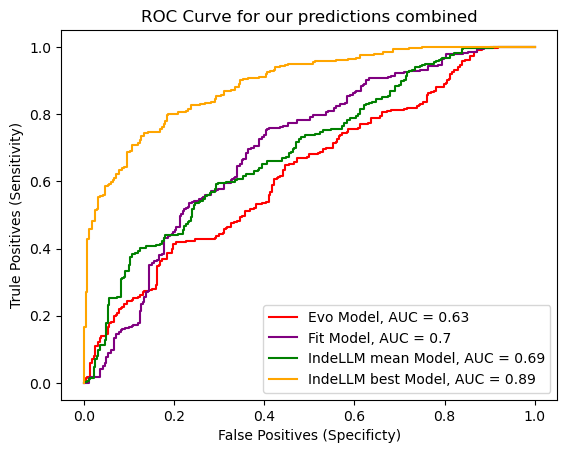

In [30]:
#Try to add the methods together

#Extrating Arrays
truelabels = overall_small['labels_binary'].values

#combinding by using the mean value
pred_combined = (pred_evo + pred_fit) / 2 

#Identifying the correct predictions by using their thresholds. 
overall_small['Evo_correct'] = None 
overall_small['Fit_correct'] = None
overall_small.loc[((overall_small['dif_evo'] >= tresh_evo) & (overall_small['labels_cleaned'] == 'Benign')) | 
        ((overall_small['dif_evo'] < tresh_evo) & (overall_small['labels_cleaned'] == 'Pathogenic')), 'Evo_correct'] = 'True'
overall_small.loc[((overall_small['dif_fit'] >= tresh_fit) & (overall_small['labels_cleaned'] == 'Benign')) | 
        ((overall_small['dif_fit'] < tresh_fit) & (overall_small['labels_cleaned'] == 'Pathogenic')), 'Fit_correct'] = 'True'

# Combind by using the best values
# If both true or both fail, use the best value (highest if benign, lowest if pathogenic). If only one is True, use the value from the model that is True. 
def calculate_best_dif(row):
    if row['Evo_correct'] and row['Fit_correct']:
        if row['labels_binary'] == 1:
            return max(row['dif_evo'], row['dif_fit'])
        else:
            return min(row['dif_evo'], row['dif_fit'])
    elif row['Evo_correct'] and pd.isna(row['Fit_correct']):
        return row['dif_evo']
    elif pd.isna(row['Evo_correct']) and row['Fit_correct']:
        return row['dif_fit']
    elif pd.isna(row['Evo_correct']) and pd.isna(row['Fit_correct']):
        if row['labels_binary'] == 1:
            return max(row['dif_evo'], row['dif_fit'])
        else:
            return min(row['dif_evo'], row['dif_fit'])
    else:
        return np.nan  # In case there are any other combinations which are not covered

overall_small['dif_best'] = overall_small.apply(calculate_best_dif, axis=1)

pred_best = overall_small['dif_best'].values

#Calculating FP, TN and thresholds
fpr_combined, tpr_combined, thersholds_combined = metrics.roc_curve(truelabels, pred_combined)
roc_auc_combined = round(metrics.auc(fpr_combined, tpr_combined), 2)

fpr_best, tpr_best, thersholds_best = metrics.roc_curve(truelabels, pred_best)
roc_auc_best = round(metrics.auc(fpr_best, tpr_best), 2)

#Using the threshold to create a binary table of the predicted values
#Find the best threshold
tresh_combined = thersholds_combined[np.argmax(tpr_combined - fpr_combined)]
tresh_best = thersholds_best[np.argmax(tpr_best - fpr_best)]

#Converting the continous predictions into binary
pred_combined_bin = [1 if x >= tresh_combined else 0 for x in pred_combined]
pred_best_bin = [1 if x >= tresh_best else 0 for x in pred_best]

#Calculating F1 score
f1_combined = f1_score(truelabels, pred_combined_bin, average = 'binary')
f1_best = f1_score(truelabels, pred_best_bin, average = 'binary')

#Calculating accuary score
accuracy_combined = accuracy_score(truelabels, pred_combined_bin)
accuracy_best = accuracy_score(truelabels, pred_best_bin)

#Calculating MCC
mcc_combined = matthews_corrcoef(truelabels, pred_combined_bin)
mcc_best = matthews_corrcoef(truelabels, pred_best_bin)

print("F1 score Evo small indels:", f1_evo)
print("F1 score Fit small indels:", f1_fit)
print("F1 score Combined mean small indels:", f1_combined)
print("F1 score Combined best small indels:", f1_best)

print("Accuracy score Evo small indels:", accuracy_evo)
print("Accuracy score Fit small indels:", accuracy_fit)
print("Accuracy score Combined mean small indels:", accuracy_combined)
print("Accuracy score Combined best small indels:", accuracy_best)

print("MCC Evo small indels:", mcc_evo)
print("MCC Fit small indels:", mcc_fit)
print("MCC Combined small mean indels:", mcc_combined)
print("MCC Combined small best indels:", mcc_best)

#Plotting the Evo and Fit AUC 
plt.plot(fpr_evo, tpr_evo, label = "Evo Model, AUC = "+str(roc_auc_evo), color = "red")
plt.plot(fpr_fit, tpr_fit, label = "Fit Model, AUC = "+str(roc_auc_fit), color = "purple")
plt.plot(fpr_combined, tpr_combined, label = "IndeLLM mean Model, AUC = "+str(roc_auc_combined), color = "green")
plt.plot(fpr_best, tpr_best, label = "IndeLLM best Model, AUC = "+str(roc_auc_best), color = "orange")
plt.xlabel('False Positives (Specificty)')
plt.ylabel('Trule Positives (Sensitivity)')
plt.title("ROC Curve for our predictions combined")
plt.legend(loc = 'best')
plt.show()

In [31]:
#Compare to the other indel predictors

#Extract the IDs that we kept from the original dataset, and clean up labels
keptlabels = alldata[alldata['Id_matching'].isin(overall_small['pair_id'])]
keptlabels['pair_id'] = keptlabels['Id_matching']
keptlabels = keptlabels.merge(overall_small, how = 'inner', on= keptlabels['pair_id'])
truelabels = overall_small['labels_binary'].values


/tmp/ipykernel_3596441/750797699.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keptlabels['pair_id'] = keptlabels['Id_matching']


VEST-Indel: Douville et al. 2015 (https://onlinelibrary.wiley.com/doi/full/10.1002/humu.22911)

From method section: 

A curated set of in-frame and frameshift indels (microdeletions and microinsertions) of ≤20 base-pairs in length, annotated as being pathogenic from publications in the biomedical literature, was downloaded from Human Gene Mutation Database [Stenson et al., 2014] (2014v.3). Only high-confidence annotations with the “DM” designation were included. A second curated set of in-frame and frameshift indels was downloaded from the NCBI ClinVar database on August 7, 2014. Only entries annotated as “likely pathogenic” (Clinical Significance 4) or “pathogenic” (Clinical Significance 5) and not annotated as a somatic mutation were included. Any entry from ClinVar that was also present in HGMD was removed from the ClinVar set. Annotated in-frame and frameshift variants were downloaded from the Exome Variant Server using (ESP6500SI-V2-SSA137) [Fu et al., 2013] and from the 1000 Genomes Project Phase 3 (ftp://ftp-trace.ncbi.nih.gov/1000genomes/ftp/) [Clarke et al., 2012]. To increase the likelihood that variants from the Exome Variant Server and 1000 Genomes Project were benign common polymorphisms, and to retain sufficient variants for our training set, we only used variants with a minor allele frequency (MAF) ≥0.01 and occurring in either African individuals or those of African ancestry. In ESP600, these were identified as “African-American” and in 1000G as the AFR superpopulation comprising YRI (Yoruba in Ibadan, Nigeria), LWK (luhya in Webuye, Kenya), GWD (Gambian in Western Divisions in the Gambia), MSL (Mende in Sierra Leone), ESN (Esan in Nigeria), ASW (Americans of African ancestry in SW USA), and ACG (African Caribbeans in Barbados). The other populations represented in ESP6500 and 1000G are believed to have experienced severe bottlenecks in recent history, and hence individuals from these populations may harbor potentially pathogenic variants at higher MAF than individuals of African ancestry [Lohmueller et al., 2008; MacArthur and Tyler-Smith, 2010; Ng et al., 2008; Hu and Ng, 2012]. A curated set of putatively benign in-frame and frameshift indels, derived from pairwise genome alignments of human and cow, dog, horse, chimpanzee, rhesus macaque, and rat, was generously provided to us by Pauline Ng and Jing Hu. This set had been previously used to train their SIFT-indel classifier [Hu and Ng, 2012; Hu and Ng, 2013]. Additional background information about these data sets, including probability densities for indel length and MAF, are shown in Supp. Figure S1.

,key_0,Unnamed: 0,Id_matching,Protein_start,Protein_stop,Unnamed: 0_y,start-b38,stop-b38,CADD,CAPICE,...,length_wt,evo_mut,evo_wt,fit_mut,fit_wt,length_indel,dif_evo,dif_fit,labels_binary,dif_best
count,545.000000,545.000000,545.000000,545.000000,545.000000,0.0,5.450000e+02,5.450000e+02,545.000000,544.000000,...,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000
mean,2019.218349,1950.280734,2019.218349,175.726606,178.759633,NaN,7.201416e+07,7.201417e+07,16.730950,0.379123,...,355.308257,289.828319,294.491014,117.220169,120.504330,3.238532,-4.662695,-3.284160,0.480734,-4.272876
std,1139.629043,1096.968775,1139.629043,114.119038,114.093917,NaN,5.992615e+07,5.992615e+07,5.208316,0.398153,...,95.942291,79.488123,79.668109,60.577959,61.709567,2.513563,3.511656,4.341632,0.500088,4.714502
min,1.000000,1.000000,1.000000,2.000000,4.000000,NaN,4.886900e+04,4.889000e+04,0.514000,0.000007,...,67.000000,38.754637,40.831130,9.631793,8.818169,1.000000,-22.946907,-40.365060,0.000000,-40.365060
25%,1117.000000,1083.000000,1117.000000,75.000000,77.000000,NaN,2.662552e+07,2.662552e+07,14.450000,0.006867,...,304.000000,240.434955,245.327420,67.324480,67.849393,1.000000,-6.419005,-4.830453,0.000000,-6.053847
50%,1976.000000,1917.000000,1976.000000,167.000000,169.000000,NaN,5.418085e+07,5.418087e+07,18.030000,0.188320,...,367.000000,297.457157,302.013060,102.375312,104.487506,2.000000,-3.846082,-2.417289,0.000000,-3.211589
75%,2955.000000,2852.000000,2955.000000,249.000000,254.000000,NaN,1.091415e+08,1.091415e+08,20.800000,0.824474,...,432.000000,354.969274,359.729798,162.584277,167.603234,5.000000,-1.961658,-0.631173,1.000000,-1.043235
max,3958.000000,3814.000000,3958.000000,478.000000,479.000000,NaN,2.482950e+08,2.482951e+08,24.800000,0.999197,...,500.000000,449.243205,450.935780,296.511972,302.809842,10.000000,0.187187,4.589211,1.000000,4.110325


Text(0.5, 1.0, 'VEST predictor results')

<Axes: title={'center': 'VEST predictor results'}, xlabel='labels_cleaned', ylabel='VEST-indel'>

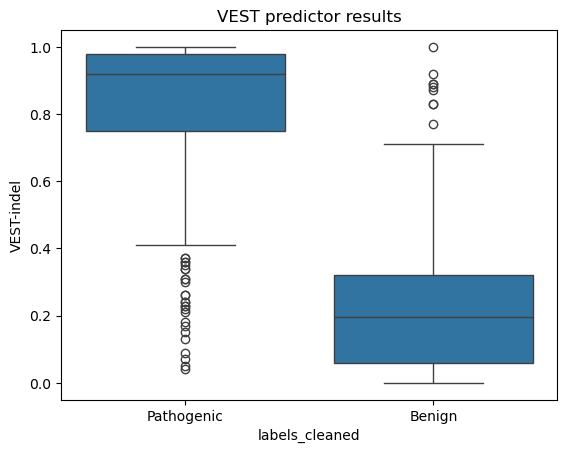

F1 score Combined/IndeLLM best small indels: 0.8057040998217468
F1 score VEST small indels: 0.8830188679245283
Accuracy score Combined/IndeLLM best small indels: 0.8070796460176991
Accuracy score VEST small indels: 0.8862385321100917
MCC Combined/IndeLLM best small indels: 0.614185465395214
MCC VEST small indels: 0.780082636981433


Text(0.5, 0, 'False Positives (Specificty)')

Text(0, 0.5, 'Trule Positives (Sensitivity)')

Text(0.5, 1.0, 'ROC Curve for our predictions')

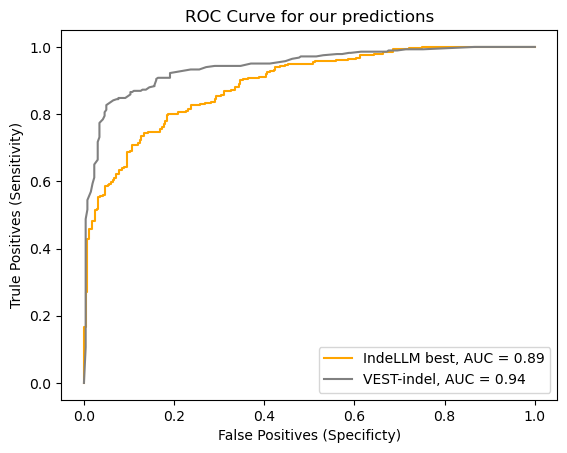

In [32]:
#Some of the columns in VEST contain no prediction, so filer the dataset
filtered_VEST = keptlabels.dropna(subset=['VEST-indel'])
pred_VEST = filtered_VEST['VEST-indel'].values
truelabels_VEST = filtered_VEST['labels_binary'].values

filtered_VEST.describe()

#Boxplot of VEST
plt.title('VEST predictor results')
sns.boxplot(x = filtered_VEST['labels_cleaned'], y = filtered_VEST['VEST-indel'])
plt.show()

#The VEST predicts benig as 0, while pathogenic as 1. So have to change 0 to 1 and 1 to 0
truelabels_VEST -= 1
truelabels_VEST = np.abs(truelabels_VEST) 

#Calculating FP, TN and thresholds
fpr_VEST, tpr_VEST, thersholds_VEST = metrics.roc_curve(truelabels_VEST, pred_VEST)
roc_auc_VEST = round(metrics.auc(fpr_VEST, tpr_VEST), 2)

#Calculating F1 score
tresh_VEST = thersholds_VEST[np.argmax(tpr_VEST - fpr_VEST)]
pred_VEST_bin = [1 if x >= tresh_VEST else 0 for x in pred_VEST]
f1_VEST = f1_score(truelabels_VEST, pred_VEST_bin, average = 'binary')

#Calculating accuary score
accuracy_VEST = accuracy_score(truelabels_VEST, pred_VEST_bin)

#Calculating MCC
mcc_VEST = matthews_corrcoef(truelabels_VEST, pred_VEST_bin)

print("F1 score Combined/IndeLLM best small indels:", f1_best)
print("F1 score VEST small indels:", f1_VEST)

print("Accuracy score Combined/IndeLLM best small indels:", accuracy_best)
print("Accuracy score VEST small indels:", accuracy_VEST)

print("MCC Combined/IndeLLM best small indels:", mcc_best)
print("MCC VEST small indels:", mcc_VEST)

#Plotting the Evo, Fit and VEST AUC 
plt.plot(fpr_best, tpr_best, label = "IndeLLM best, AUC = "+str(roc_auc_best), color = "orange")
plt.plot(fpr_VEST, tpr_VEST, label = "VEST-indel, AUC = "+str(roc_auc_VEST), color = "grey")
plt.xlabel('False Positives (Specificty)')
plt.ylabel('Trule Positives (Sensitivity)')
plt.title("ROC Curve for our predictions")
plt.legend(loc = 'best')
plt.show()


/tmp/ipykernel_3596441/1994458545.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_VEST['correct'] = None


<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

Text(0.5, 1.0, 'Procentage of indel type')

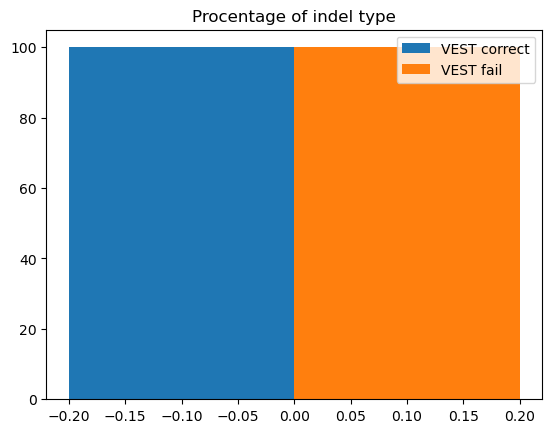

,VESTcorrect,VESTfail
length_indel,,
1,191,24.0
2,60,7.0
3,50,4.0
4,50,7.0
5,36,2.0
6,38,2.0
7,21,7.0
8,19,6.0
9,7,3.0


<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

([<matplotlib.axis.XTick at 0x741b32c2c440>,
 [Text(0, 0, '1'), Text(1, 0, '2-4'), Text(2, 0, '5-10')])

Text(0.5, 1.0, 'Procentage of indel size')

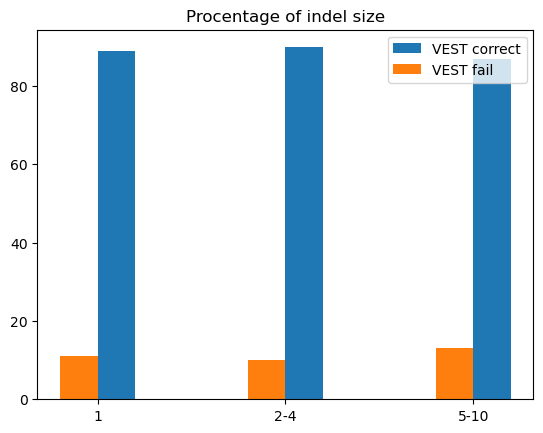

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

([<matplotlib.axis.XTick at 0x741b32ce7bf0>,
 [Text(0, 0, '1-250'), Text(1, 0, '251-500')])

Text(0.5, 1.0, 'Procentage of wt aa length')

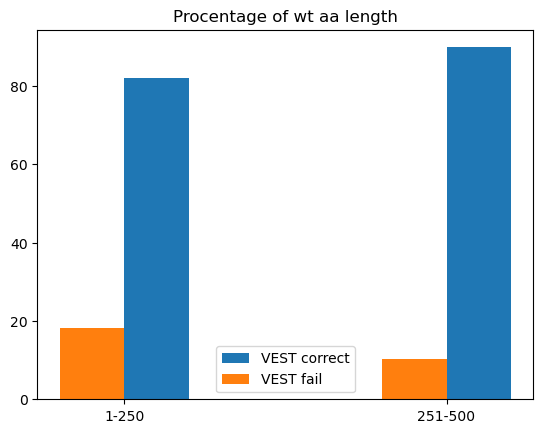

In [91]:
# See how VEST handles different types of indels and protein lengths
# Check which values the model calls correctly
filtered_VEST['correct'] = None 
filtered_VEST.loc[((filtered_VEST['VEST-indel'] < tresh_VEST) & (filtered_VEST['labels_cleaned'] == 'Benign')) | 
        ((filtered_VEST['VEST-indel'] >= tresh_VEST) & (filtered_VEST['labels_cleaned'] == 'Pathogenic')), 'correct'] = 'True'

#Dataframes with correcly called by both, failed by both, and what one manages and the other don't
VESTcorrect = filtered_VEST.loc[((filtered_VEST['correct'] == 'True'))]
VESTfail = filtered_VEST.loc[((filtered_VEST['correct'].isnull()))]

# Indel type 
VESTcorrect_indeltype = VESTcorrect['indel'].value_counts()
VESTfail_indeltype = VESTfail['indel'].value_counts()
indeltype = ('Deletion', 'Insertion')

plt.bar(np.arange(len(VESTcorrect_indeltype.index)) - 0.1 , ((VESTcorrect_indeltype.values / len(VESTcorrect)) * 100) , 0.2, label = 'VEST correct')
plt.bar(np.arange(len(VESTfail_indeltype.index)) + 0.1, ((VESTfail_indeltype.values / len(VESTfail)) * 100), 0.2, label = 'VEST fail')
plt.legend(loc = 'best')
plt.title('Procentage of indel type')
#plt.xticks(np.arange(len(VESTcorrect_indeltype)), indeltype)
plt.show()

# Indel size
VESTcorrect_indelsize = VESTcorrect['length_indel'].value_counts()
VESTfail_indelsize = VESTfail['length_indel'].value_counts()

indelsizeVEST = pd.DataFrame({
    'VESTcorrect': VESTcorrect_indelsize,
    'VESTfail': VESTfail_indelsize,
    }).fillna(0)

#Group the indel sizes after Cannon et al. 2023 (1, 2-4, 5-10 and 11+)

indelsizeVEST #Check that it conatins all types of indels

indels2to4VEST = indelsizeVEST.loc[2:4].sum()
indels5to10VEST = indelsizeVEST.loc[5:10].sum()

indelsizeVEST_grouped = pd.DataFrame({
    'Indel size': ['1', '2-4', '5-10'],
    'VESTcorrect': [indelsizeVEST.loc[1, 'VESTcorrect'], indels2to4VEST['VESTcorrect'], indels5to10VEST['VESTcorrect']],
    'VESTfail': [indelsizeVEST.loc[1, 'VESTfail'], indels2to4VEST['VESTfail'], indels5to10VEST['VESTfail']]
})

labels = ['1', '2-4', '5-10']

#Calculate procentage
indelsumVEST = indelsizeVEST_grouped[['VESTcorrect', 'VESTfail']].sum(axis=1)
percentageVEST = indelsizeVEST_grouped[['VESTcorrect', 'VESTfail']].div(indelsumVEST, axis=0) * 100
percentageVEST.insert(0, 'Indel size', indelsizeVEST_grouped['Indel size'])


plt.bar(np.arange(len(percentageVEST)) + 0.1, percentageVEST['VESTcorrect'], 0.2, label = 'VEST correct')
plt.bar(np.arange(len(percentageVEST)) - 0.1, percentageVEST['VESTfail'], 0.2, label = 'VEST fail')
plt.xticks(np.arange(len(percentageVEST)), labels)
plt.legend(loc = 'best')
plt.title('Procentage of indel size')
plt.show()

# Protein length 
VESTcorrect_aasize = VESTcorrect['length_wt'].value_counts()
VESTfail_aasize = VESTfail['length_wt'].value_counts()

VESTaasize = pd.DataFrame({
    'VESTcorrect': VESTcorrect_aasize,
    'VESTfail': VESTfail_aasize
}).fillna(0)

aaranges2 = [(0, 250), (251, 500)]

VESTsummarized_data = {
    'Range': [],
    'VESTcorrect': [],
    'VESTfail': []
}

for start, end in aaranges2:
    range_label = f'{start}-{end}'
    range_sum = VESTaasize.loc[start:end].sum()
    
    VESTsummarized_data['Range'].append(range_label)
    VESTsummarized_data['VESTcorrect'].append(range_sum['VESTcorrect'])
    VESTsummarized_data['VESTfail'].append(range_sum['VESTfail'])

# Creating a new DataFrame with the summarized values
VESTsummarized_df = pd.DataFrame(VESTsummarized_data)

labels2 = ['1-250', '251-500']

#Calculate procentage
sizesumVEST = VESTsummarized_df[['VESTcorrect', 'VESTfail']].sum(axis=1)
percentageVESTsize = VESTsummarized_df[['VESTcorrect', 'VESTfail']].div(sizesumVEST, axis=0) * 100
percentageVESTsize.insert(0, 'Range', VESTsummarized_df['Range'])

plt.bar(np.arange(len(percentageVESTsize)) + 0.1, percentageVESTsize['VESTcorrect'], 0.2, label = 'VEST correct')
plt.bar(np.arange(len(percentageVESTsize)) - 0.1, percentageVESTsize['VESTfail'], 0.2, label = 'VEST fail')
plt.xticks(np.arange(len(percentageVESTsize)), labels2)
plt.legend(loc = 'best')
plt.title('Procentage of wt aa length')
plt.show()

FATHMM-indel: Ferlaino et al. 2017: https://link.springer.com/article/10.1186/s12859-017-1862-y

We developed a machine learning approach to classify the functional effects of small indels, that is, variants where the sequence change involves up to 20 base pairs. 
An integrative approach to predict the functional effect, pathogenic or neutral, of indels in non-coding regions of the human genome. Our method exploits various genomic annotations in addition to sequence data. When validated on benchmark data, FATHMM-indel significantly outperforms CADD and GAVIN, state of the art models in assessing the pathogenic impact of non-coding variants. FATHMM-indel is available via a web server at indels.biocompute.org.uk.

From methods: Pathogenic non–coding indels were collected from the CinVar database.

,key_0,Unnamed: 0,Id_matching,Protein_start,Protein_stop,Unnamed: 0_y,start-b38,stop-b38,CADD,CAPICE,...,length_wt,evo_mut,evo_wt,fit_mut,fit_wt,length_indel,dif_evo,dif_fit,labels_binary,dif_best
count,560.000000,560.000000,560.000000,560.000000,560.000000,0.0,5.600000e+02,5.600000e+02,560.000000,560.000000,...,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000
mean,2004.012500,1935.555357,2004.012500,173.880357,176.905357,NaN,7.352845e+07,7.352846e+07,16.530521,0.368754,...,349.530357,284.882638,289.494079,115.122226,118.328785,3.235714,-4.611441,-3.206559,0.494643,-4.166450
std,1143.684337,1100.943450,1143.684337,114.330195,114.289420,NaN,6.143292e+07,6.143292e+07,5.369597,0.397104,...,100.921368,83.633587,83.893752,61.564082,62.690456,2.516097,3.512897,4.317514,0.500418,4.704405
min,1.000000,1.000000,1.000000,2.000000,4.000000,NaN,4.744600e+04,4.745500e+04,0.314000,0.000004,...,65.000000,38.754637,40.831130,9.631793,8.818169,1.000000,-22.946907,-40.365060,0.000000,-40.365060
25%,1041.750000,1009.750000,1041.750000,73.000000,75.000000,NaN,2.717369e+07,2.717372e+07,14.047500,0.005705,...,291.250000,235.423460,241.586730,66.764156,67.846778,1.000000,-6.365661,-4.809600,0.000000,-5.998753
50%,1948.500000,1889.500000,1948.500000,164.000000,167.000000,NaN,5.642043e+07,5.642044e+07,17.920000,0.170772,...,363.500000,294.795880,300.911272,100.374912,102.995135,2.000000,-3.811042,-2.258393,0.000000,-3.123772
75%,2955.250000,2852.250000,2955.250000,247.000000,252.000000,NaN,1.131524e+08,1.131524e+08,20.700000,0.808810,...,430.500000,351.911342,356.185876,161.060318,164.829317,5.000000,-1.939493,-0.538134,1.000000,-0.916909
max,3958.000000,3814.000000,3958.000000,478.000000,479.000000,NaN,2.482950e+08,2.482951e+08,24.800000,0.999197,...,500.000000,449.243205,450.935780,296.511972,302.809842,10.000000,1.577955,4.589211,1.000000,4.110325


Text(0.5, 1.0, 'FATHMM predictor results')

<Axes: title={'center': 'FATHMM predictor results'}, xlabel='labels_cleaned', ylabel='FATHMM-indel'>

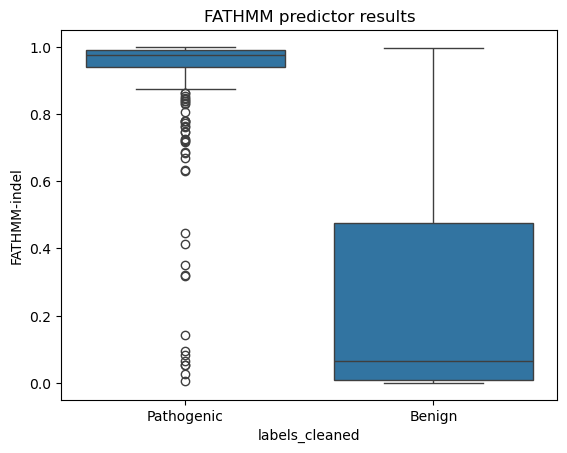

F1 score Combined/IndeLLM best small indels: 0.8057040998217468
F1 score FATHMM small indels: 0.8877721943048577
Accuracy score Combined/IndeLLM best small indels: 0.8070796460176991
Accuracy score FATHMM small indels: 0.8803571428571428
MCC Combined/IndeLLM best small indels: 0.614185465395214
MCC FATHMM small indels: 0.7651186036717177


Text(0.5, 0, 'False Positives (Specificty)')

Text(0, 0.5, 'Trule Positives (Sensitivity)')

Text(0.5, 1.0, 'ROC Curve for our predictions')

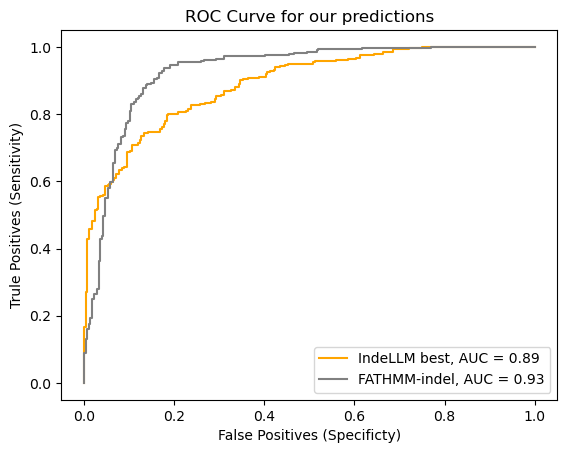

In [35]:
#Some of the columns in FATHMM contain no prediction, so filer the dataset
keptlabels['FATHMM-indel'] = pd.to_numeric(keptlabels['FATHMM-indel'], errors='coerce')
filtered_FATHMM = keptlabels.dropna(subset=['FATHMM-indel'])
pred_FATHMM = filtered_FATHMM['FATHMM-indel'].values
truelabels_FATHMM = filtered_FATHMM['labels_binary'].values

filtered_FATHMM.describe()

#Boxplot of FATHMM
plt.title('FATHMM predictor results')
sns.boxplot(x = filtered_FATHMM['labels_cleaned'], y = filtered_FATHMM['FATHMM-indel'])
plt.show()

#The FATHMM predicts benig as 0, while pathogenic as 1. So have to change 0 to 1 and 1 to 0
truelabels_FATHMM -= 1
truelabels_FATHMM = np.abs(truelabels_FATHMM) 

#Calculating FP, TN and thresholds
fpr_FATHMM, tpr_FATHMM, thersholds_FATHMM = metrics.roc_curve(truelabels_FATHMM, pred_FATHMM)
roc_auc_FATHMM = round(metrics.auc(fpr_FATHMM, tpr_FATHMM), 2)

#Calculating F1 score
tresh_FATHMM = thersholds_FATHMM[np.argmax(tpr_FATHMM - fpr_FATHMM)]
pred_FATHMM_bin = [1 if x >= tresh_FATHMM else 0 for x in pred_FATHMM]
f1_FATHMM = f1_score(truelabels_FATHMM, pred_FATHMM_bin, average = 'binary')

#Calculating accuary score
accuracy_FATHMM = accuracy_score(truelabels_FATHMM, pred_FATHMM_bin)

#Calculating MCC
mcc_FATHMM = matthews_corrcoef(truelabels_FATHMM, pred_FATHMM_bin)

print("F1 score Combined/IndeLLM best small indels:", f1_best)
print("F1 score FATHMM small indels:", f1_FATHMM)

print("Accuracy score Combined/IndeLLM best small indels:", accuracy_best)
print("Accuracy score FATHMM small indels:", accuracy_FATHMM)

print("MCC Combined/IndeLLM best small indels:", mcc_best)
print("MCC FATHMM small indels:", mcc_FATHMM)

#Plotting the Evo, Fit and FATHMM AUC 
plt.plot(fpr_best, tpr_best, label = "IndeLLM best, AUC = "+str(roc_auc_best), color = "orange")
plt.plot(fpr_FATHMM, tpr_FATHMM, label = "FATHMM-indel, AUC = "+str(roc_auc_FATHMM), color = "grey")
plt.xlabel('False Positives (Specificty)')
plt.ylabel('Trule Positives (Sensitivity)')
plt.title("ROC Curve for our predictions")
plt.legend(loc = 'best')
plt.show()


/tmp/ipykernel_3596441/62079316.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_FATHMM['correct'] = None


<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

Text(0.5, 1.0, 'Procentage of indel type')

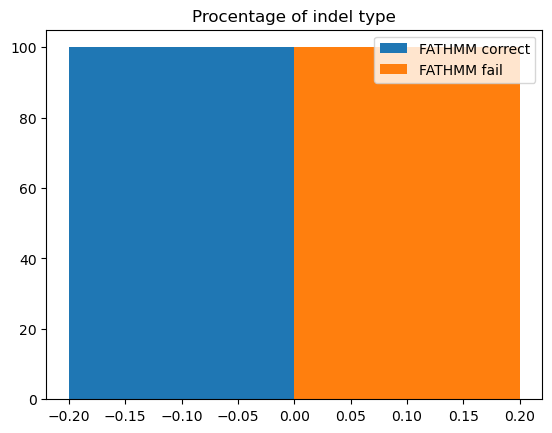

,FATHMMcorrect,FATHMMfail
length_indel,,
1,190,33.0
2,60,7.0
3,52,2.0
4,54,7.0
5,34,4.0
6,37,3.0
7,26,3.0
8,21,6.0
9,8,2.0


<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

([<matplotlib.axis.XTick at 0x741b32b33d70>,
 [Text(0, 0, '1'), Text(1, 0, '2-4'), Text(2, 0, '5-10')])

Text(0.5, 1.0, 'Procentage of indel size')

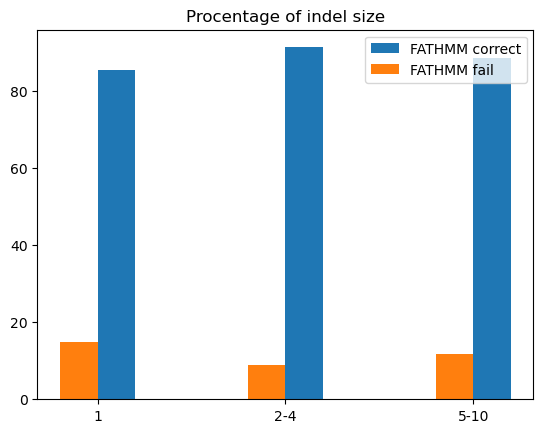

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

([<matplotlib.axis.XTick at 0x741b32a56a80>,
 [Text(0, 0, '1-250'), Text(1, 0, '251-500')])

Text(0.5, 1.0, 'Procentage of wt aa length')

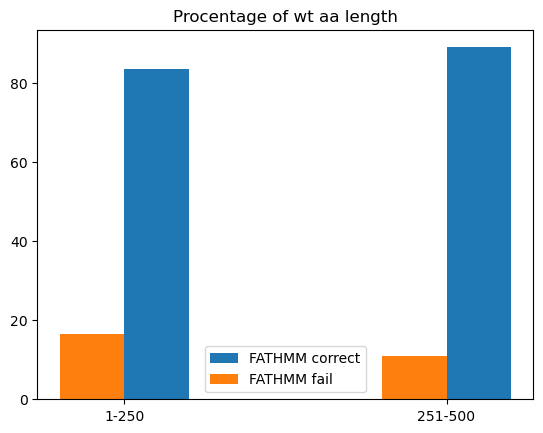

In [92]:
# See how FATHMM handles different types of indels and protein lengths
# Check which values the model calls correctly
filtered_FATHMM['correct'] = None 
filtered_FATHMM.loc[((filtered_FATHMM['FATHMM-indel'] < tresh_FATHMM) & (filtered_FATHMM['labels_cleaned'] == 'Benign')) | 
        ((filtered_FATHMM['FATHMM-indel'] >= tresh_FATHMM) & (filtered_FATHMM['labels_cleaned'] == 'Pathogenic')), 'correct'] = 'True'

#Dataframes with correcly called by both, failed by both, and what one manages and the other don't
FATHMMcorrect = filtered_FATHMM.loc[((filtered_FATHMM['correct'] == 'True'))]
FATHMMfail = filtered_FATHMM.loc[((filtered_FATHMM['correct'].isnull()))]

# Indel type 
FATHMMcorrect_indeltype = FATHMMcorrect['indel'].value_counts()
FATHMMfail_indeltype = FATHMMfail['indel'].value_counts()
indeltype = ('Deletion', 'Insertion')

plt.bar(np.arange(len(FATHMMcorrect_indeltype.index)) - 0.1 , ((FATHMMcorrect_indeltype.values / len(FATHMMcorrect)) * 100) , 0.2, label = 'FATHMM correct')
plt.bar(np.arange(len(FATHMMfail_indeltype.index)) + 0.1, ((FATHMMfail_indeltype.values / len(FATHMMfail)) * 100), 0.2, label = 'FATHMM fail')
plt.legend(loc = 'best')
plt.title('Procentage of indel type')
#plt.xticks(np.arange(len(FATHMMcorrect_indeltype)), indeltype)
plt.show()

# Indel size
FATHMMcorrect_indelsize = FATHMMcorrect['length_indel'].value_counts()
FATHMMfail_indelsize = FATHMMfail['length_indel'].value_counts()

indelsizeFATHMM = pd.DataFrame({
    'FATHMMcorrect': FATHMMcorrect_indelsize,
    'FATHMMfail': FATHMMfail_indelsize,
    }).fillna(0)

#Group the indel sizes after Cannon et al. 2023 ((0), 1, 2-4, 5-10 and 11+)

indelsizeFATHMM #Check that it conatins all types of indels

indels2to4FATHMM = indelsizeFATHMM.loc[2:4].sum()
indels5to10FATHMM = indelsizeFATHMM.loc[5:10].sum()

indelsizeFATHMM_grouped = pd.DataFrame({
    'Indel size': ['1', '2-4', '5-10'],
    'FATHMMcorrect': [indelsizeFATHMM.loc[1, 'FATHMMcorrect'], indels2to4FATHMM['FATHMMcorrect'], indels5to10FATHMM['FATHMMcorrect']],
    'FATHMMfail': [indelsizeFATHMM.loc[1, 'FATHMMfail'], indels2to4FATHMM['FATHMMfail'], indels5to10FATHMM['FATHMMfail']]
})

labels = ['1', '2-4', '5-10']

#Calculate procentage
indelsumFATHMM = indelsizeFATHMM_grouped[['FATHMMcorrect', 'FATHMMfail']].sum(axis=1)
percentageFATHMM = indelsizeFATHMM_grouped[['FATHMMcorrect', 'FATHMMfail']].div(indelsumFATHMM, axis=0) * 100
percentageFATHMM.insert(0, 'Indel size', indelsizeFATHMM_grouped['Indel size'])

plt.bar(np.arange(len(percentageFATHMM)) + 0.1, percentageFATHMM['FATHMMcorrect'], 0.2, label = 'FATHMM correct')
plt.bar(np.arange(len(percentageFATHMM)) - 0.1, percentageFATHMM['FATHMMfail'], 0.2, label = 'FATHMM fail')
plt.xticks(np.arange(len(percentageFATHMM)), labels)
plt.legend(loc = 'best')
plt.title('Procentage of indel size')
plt.show()

# Protein length 
FATHMMcorrect_aasize = FATHMMcorrect['length_wt'].value_counts()
FATHMMfail_aasize = FATHMMfail['length_wt'].value_counts()

FATHMMaasize = pd.DataFrame({
    'FATHMMcorrect': FATHMMcorrect_aasize,
    'FATHMMfail': FATHMMfail_aasize
}).fillna(0)

aaranges2 = [(0, 250), (251, 500)]

FATHMMsummarized_data = {
    'Range': [],
    'FATHMMcorrect': [],
    'FATHMMfail': []
}

for start, end in aaranges2:
    range_label = f'{start}-{end}'
    range_sum = FATHMMaasize.loc[start:end].sum()
    
    FATHMMsummarized_data['Range'].append(range_label)
    FATHMMsummarized_data['FATHMMcorrect'].append(range_sum['FATHMMcorrect'])
    FATHMMsummarized_data['FATHMMfail'].append(range_sum['FATHMMfail'])

# Creating a new DataFrame with the summarized values
FATHMMsummarized_df = pd.DataFrame(FATHMMsummarized_data)

labels2 = ['1-250', '251-500']

#Calculate procentage
sizesumFATHMM = FATHMMsummarized_df[['FATHMMcorrect', 'FATHMMfail']].sum(axis=1)
percentageFATHMMsize = FATHMMsummarized_df[['FATHMMcorrect', 'FATHMMfail']].div(sizesumFATHMM, axis=0) * 100
percentageFATHMMsize.insert(0, 'Range', FATHMMsummarized_df['Range'])

plt.bar(np.arange(len(percentageFATHMMsize)) + 0.1, percentageFATHMMsize['FATHMMcorrect'], 0.2, label = 'FATHMM correct')
plt.bar(np.arange(len(percentageFATHMMsize)) - 0.1, percentageFATHMMsize['FATHMMfail'], 0.2, label = 'FATHMM fail')
plt.xticks(np.arange(len(percentageFATHMMsize)), labels2)
plt.legend(loc = 'best')
plt.title('Procentage of wt aa length')
plt.show()

CADD: Rentzsch et al. 2021 https://link.springer.com/article/10.1186/s13073-021-00835-9

Method: 
The MFASS [26] data set was downloaded from GitHub (https://github.com/KosuriLab/MFASS/). The data set was split into intronic (n = 13,603) and exonic (n = 14,130) variants as defined by Cheung et al. [26]. Further, the data set was split into splice-disrupting variants (sdv, n = 1050) and variants that do not disrupt splicing (no-sdv, n = 26,683) based on whether the psi ratio of the tested exon changed by more than 0.5 (Δpsi > 0.5). 

,key_0,Unnamed: 0,Id_matching,Protein_start,Protein_stop,Unnamed: 0_y,start-b38,stop-b38,CADD,CAPICE,...,length_wt,evo_mut,evo_wt,fit_mut,fit_wt,length_indel,dif_evo,dif_fit,labels_binary,dif_best
count,565.000000,565.000000,565.000000,565.000000,565.000000,0.0,5.650000e+02,5.650000e+02,565.000000,564.000000,...,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000
mean,2003.200000,1934.792920,2003.200000,172.943363,175.962832,NaN,7.325131e+07,7.325132e+07,16.516085,0.366165,...,349.819469,285.091141,289.686607,115.316893,118.520590,3.233628,-4.595466,-3.203697,0.499115,-4.152523
std,1141.201527,1098.583013,1141.201527,114.779809,114.747443,NaN,6.128913e+07,6.128913e+07,5.366505,0.396877,...,100.709254,83.457094,83.709430,61.330184,62.450203,2.505724,3.502012,4.298922,0.500442,4.686191
min,1.000000,1.000000,1.000000,2.000000,4.000000,NaN,4.744600e+04,4.745500e+04,0.314000,0.000004,...,65.000000,38.754637,40.831130,9.631793,8.818169,1.000000,-22.946907,-40.365060,0.000000,-40.365060
25%,1042.000000,1010.000000,1042.000000,72.000000,75.000000,NaN,2.709569e+07,2.709570e+07,14.040000,0.005455,...,292.000000,235.927701,242.182601,66.949333,67.847007,1.000000,-6.336810,-4.784903,0.000000,-5.964405
50%,1950.000000,1891.000000,1950.000000,163.000000,166.000000,NaN,5.615990e+07,5.615991e+07,17.910000,0.167458,...,363.000000,294.673015,300.911272,100.890728,104.378199,2.000000,-3.799696,-2.282851,0.000000,-3.090962
75%,2954.000000,2851.000000,2954.000000,247.000000,252.000000,NaN,1.125475e+08,1.125476e+08,20.700000,0.804639,...,432.000000,351.675256,356.043754,160.112092,164.059835,5.000000,-1.942777,-0.547409,1.000000,-0.917809
max,3958.000000,3814.000000,3958.000000,478.000000,479.000000,NaN,2.482950e+08,2.482951e+08,24.800000,0.999197,...,500.000000,449.243205,450.935780,296.511972,302.809842,10.000000,1.577955,4.589211,1.000000,4.110325


Text(0.5, 1.0, 'CADD predictor results')

<Axes: title={'center': 'CADD predictor results'}, xlabel='labels_cleaned', ylabel='CADD'>

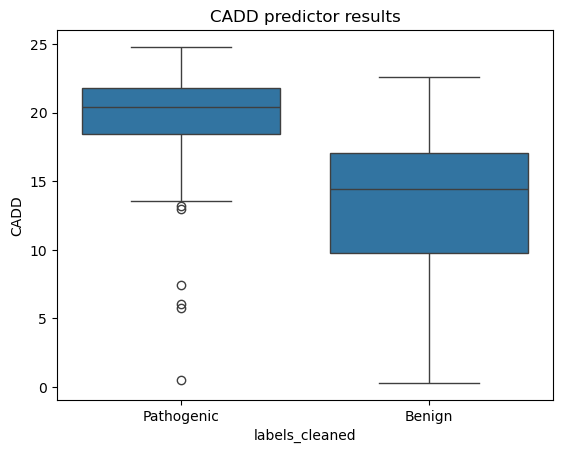

F1 score Combined/IndeLLM best small indels: 0.8057040998217468
F1 score CADD small indels: 0.8253424657534246
Accuracy score Combined/IndeLLM best small indels: 0.8070796460176991
Accuracy score CADD small indels: 0.8194690265486726
MCC Combined/IndeLLM best small indels: 0.614185465395214
MCC CADD small indels: 0.6401973697050988


Text(0.5, 0, 'False Positives (Specificty)')

Text(0, 0.5, 'Trule Positives (Sensitivity)')

Text(0.5, 1.0, 'ROC Curve for our predictions')

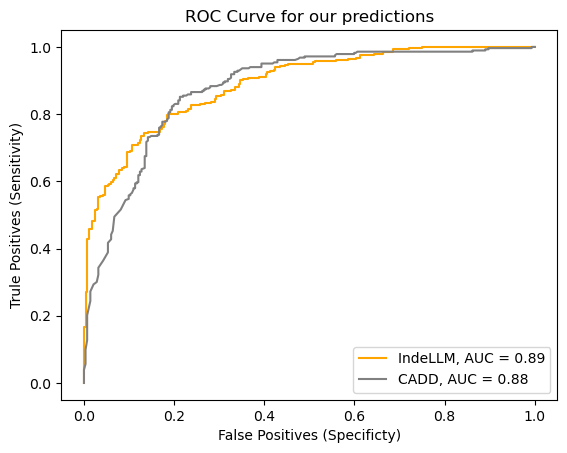

In [37]:
#Some of the columns in CADD contain no prediction, so filer the dataset
keptlabels['CADD'] = pd.to_numeric(keptlabels['CADD'], errors='coerce')
filtered_CADD = keptlabels.dropna(subset=['CADD'])
pred_CADD = filtered_CADD['CADD'].values
truelabels_CADD = filtered_CADD['labels_binary'].values

filtered_CADD.describe()

#Boxplot of CADD
plt.title('CADD predictor results')
sns.boxplot(x = filtered_CADD['labels_cleaned'], y = filtered_CADD['CADD'])
plt.show()

#The CADD predicts benig as 0, while pathogenic as 1. So have to change 0 to 1 and 1 to 0
truelabels_CADD -= 1
truelabels_CADD = np.abs(truelabels_CADD) 

#Calculating FP, TN and thresholds
fpr_CADD, tpr_CADD, thersholds_CADD = metrics.roc_curve(truelabels_CADD, pred_CADD)
roc_auc_CADD = round(metrics.auc(fpr_CADD, tpr_CADD), 2)

#Calculating F1 score
tresh_CADD = thersholds_CADD[np.argmax(tpr_CADD - fpr_CADD)]
pred_CADD_bin = [1 if x >= tresh_CADD else 0 for x in pred_CADD]
f1_CADD = f1_score(truelabels_CADD, pred_CADD_bin, average = 'binary')

#Calculating accuary score
accuracy_CADD = accuracy_score(truelabels_CADD, pred_CADD_bin)

#Calculating MCC
mcc_CADD = matthews_corrcoef(truelabels_CADD, pred_CADD_bin)

print("F1 score Combined/IndeLLM best small indels:", f1_best)
print("F1 score CADD small indels:", f1_CADD)

print("Accuracy score Combined/IndeLLM best small indels:", accuracy_best)
print("Accuracy score CADD small indels:", accuracy_CADD)

print("MCC Combined/IndeLLM best small indels:", mcc_best)
print("MCC CADD small indels:", mcc_CADD)

#Plotting the Evo, Fit and CADD AUC 
plt.plot(fpr_best, tpr_best, label = "IndeLLM, AUC = "+str(roc_auc_best), color = "orange")
plt.plot(fpr_CADD, tpr_CADD, label = "CADD, AUC = "+str(roc_auc_CADD), color = "grey")
plt.xlabel('False Positives (Specificty)')
plt.ylabel('Trule Positives (Sensitivity)')
plt.title("ROC Curve for our predictions")
plt.legend(loc = 'best')
plt.show()


<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

Text(0.5, 1.0, 'Procentage of indel type')

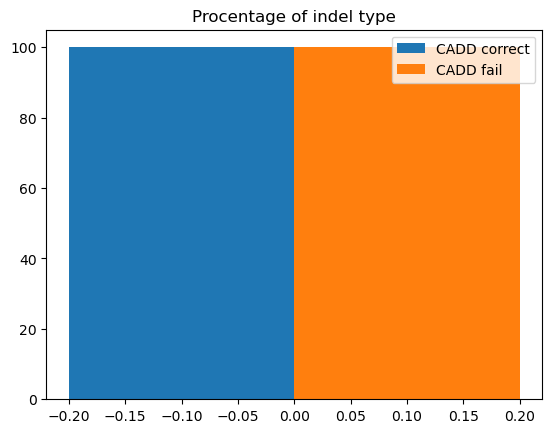

,CADDcorrect,CADDfail
length_indel,,
1,183,40.0
2,53,15.0
3,46,11.0
4,51,11.0
5,29,9.0
6,38,2.0
7,23,6.0
8,20,7.0
9,9,1.0


<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

([<matplotlib.axis.XTick at 0x741b32905760>,
 [Text(0, 0, '1'), Text(1, 0, '2-4'), Text(2, 0, '5-10')])

Text(0.5, 1.0, 'Procentage of indel size')

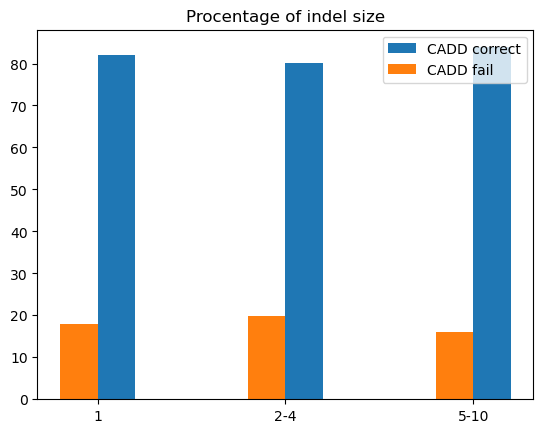

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

([<matplotlib.axis.XTick at 0x741b3292e240>,
 [Text(0, 0, '1-250'), Text(1, 0, '251-500')])

Text(0.5, 1.0, 'Procentage of wt aa length')

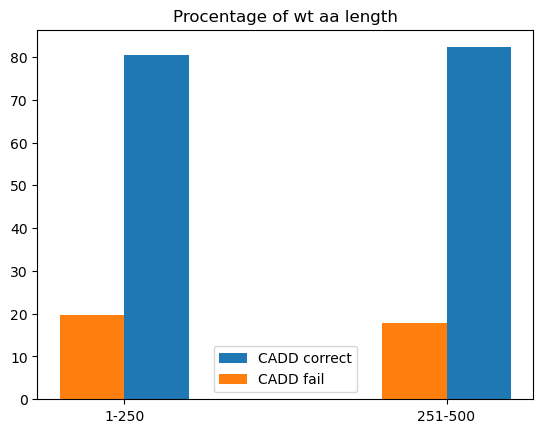

In [93]:
# See how CADD handles different types of indels and protein lengths
# Check which values the model calls correctly
filtered_CADD['correct'] = None 
filtered_CADD.loc[((filtered_CADD['CADD'] < tresh_CADD) & (filtered_CADD['labels_cleaned'] == 'Benign')) | 
        ((filtered_CADD['CADD'] >= tresh_CADD) & (filtered_CADD['labels_cleaned'] == 'Pathogenic')), 'correct'] = 'True'

#Dataframes with correcly called by both, failed by both, and what one manages and the other don't
CADDcorrect = filtered_CADD.loc[((filtered_CADD['correct'] == 'True'))]
CADDfail = filtered_CADD.loc[((filtered_CADD['correct'].isnull()))]

# Indel type 
CADDcorrect_indeltype = CADDcorrect['indel'].value_counts()
CADDfail_indeltype = CADDfail['indel'].value_counts()
indeltype = ('Deletion', 'Insertion')

plt.bar(np.arange(len(CADDcorrect_indeltype.index)) - 0.1 , ((CADDcorrect_indeltype.values / len(CADDcorrect)) * 100) , 0.2, label = 'CADD correct')
plt.bar(np.arange(len(CADDfail_indeltype.index)) + 0.1, ((CADDfail_indeltype.values / len(CADDfail)) * 100), 0.2, label = 'CADD fail')
plt.legend(loc = 'best')
plt.title('Procentage of indel type')
#plt.xticks(np.arange(len(CADDcorrect_indeltype)), indeltype)
plt.show()

# Indel size
CADDcorrect_indelsize = CADDcorrect['length_indel'].value_counts()
CADDfail_indelsize = CADDfail['length_indel'].value_counts()

indelsizeCADD = pd.DataFrame({
    'CADDcorrect': CADDcorrect_indelsize,
    'CADDfail': CADDfail_indelsize,
    }).fillna(0)

#Group the indel sizes after Cannon et al. 2023 ((0), 1, 2-4, 5-10 and 11+)

indelsizeCADD #Check that it conatins all types of indels

indels2to4CADD = indelsizeCADD.loc[2:4].sum()
indels5to10CADD = indelsizeCADD.loc[5:10].sum()

indelsizeCADD_grouped = pd.DataFrame({
    'Indel size': ['1', '2-4', '5-10'],
    'CADDcorrect': [indelsizeCADD.loc[1, 'CADDcorrect'], indels2to4CADD['CADDcorrect'], indels5to10CADD['CADDcorrect']],
    'CADDfail': [indelsizeCADD.loc[1, 'CADDfail'], indels2to4CADD['CADDfail'], indels5to10CADD['CADDfail']]
})

labels = ['1', '2-4', '5-10']

#Calculate procentage
indelsumCADD = indelsizeCADD_grouped[['CADDcorrect', 'CADDfail']].sum(axis=1)
percentageCADD = indelsizeCADD_grouped[['CADDcorrect', 'CADDfail']].div(indelsumCADD, axis=0) * 100
percentageCADD.insert(0, 'Indel size', indelsizeCADD_grouped['Indel size'])


plt.bar(np.arange(len(percentageCADD)) + 0.1, percentageCADD['CADDcorrect'], 0.2, label = 'CADD correct')
plt.bar(np.arange(len(percentageCADD)) - 0.1, percentageCADD['CADDfail'], 0.2, label = 'CADD fail')
plt.xticks(np.arange(len(percentageCADD)), labels)
plt.legend(loc = 'best')
plt.title('Procentage of indel size')
plt.show()

# Protein length 
CADDcorrect_aasize = CADDcorrect['length_wt'].value_counts()
CADDfail_aasize = CADDfail['length_wt'].value_counts()

CADDaasize = pd.DataFrame({
    'CADDcorrect': CADDcorrect_aasize,
    'CADDfail': CADDfail_aasize
}).fillna(0)

aaranges2 = [(0, 250), (251, 500)]

CADDsummarized_data = {
    'Range': [],
    'CADDcorrect': [],
    'CADDfail': []
}

for start, end in aaranges2:
    range_label = f'{start}-{end}'
    range_sum = CADDaasize.loc[start:end].sum()
    
    CADDsummarized_data['Range'].append(range_label)
    CADDsummarized_data['CADDcorrect'].append(range_sum['CADDcorrect'])
    CADDsummarized_data['CADDfail'].append(range_sum['CADDfail'])

# Creating a new DataFrame with the summarized values
CADDsummarized_df = pd.DataFrame(CADDsummarized_data)

labels2 = ['1-250', '251-500']

#Calculate procentage
sizesumCADD = CADDsummarized_df[['CADDcorrect', 'CADDfail']].sum(axis=1)
percentageCADDsize = CADDsummarized_df[['CADDcorrect', 'CADDfail']].div(sizesumCADD, axis=0) * 100
percentageCADDsize.insert(0, 'Range', CADDsummarized_df['Range'])

plt.bar(np.arange(len(percentageCADDsize)) + 0.1, percentageCADDsize['CADDcorrect'], 0.2, label = 'CADD correct')
plt.bar(np.arange(len(percentageCADDsize)) - 0.1, percentageCADDsize['CADDfail'], 0.2, label = 'CADD fail')
plt.xticks(np.arange(len(percentageCADDsize)), labels2)
plt.legend(loc = 'best')
plt.title('Procentage of wt aa length')
plt.show()

CAPICE: Li et al. 2020 https://link.springer.com/article/10.1186/s13073-020-00775-w

A new machine-learning-based method for prioritizing pathogenic variants, including SNVs and short InDels.

Training and benchmark data on neutral and pathogenic variants were derived from vcf files from the ClinVar database [17], dated 02 January 2019; from the VKGL data share consortium [30]; from the GoNL data [31]; and from data used in a previous study [29]. From the ClinVar dataset, we collected variants reported by one or more submitters to have clear clinical significance, including pathogenic and likely pathogenic variants and neutral and likely neutral variants. From the VKGL data consortium, we collected variants with clear classifications, either (Likely) Pathogenic or (Likely) Benign, with support from one or more laboratories. The neutral variants from previous research developing the GAVIN tool [29] were mainly collected from ExAC without posing a constraint on allele frequency. We also obtained two neutral benchmark datasets from a benchmark study by [24] and the GoNL project.

,key_0,Unnamed: 0,Id_matching,Protein_start,Protein_stop,Unnamed: 0_y,start-b38,stop-b38,CADD,CAPICE,...,length_wt,evo_mut,evo_wt,fit_mut,fit_wt,length_indel,dif_evo,dif_fit,labels_binary,dif_best
count,564.000000,564.000000,564.000000,564.000000,564.000000,0.0,5.640000e+02,5.640000e+02,564.000000,564.000000,...,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000
mean,2006.065603,1937.565603,2006.065603,172.716312,175.735816,NaN,7.321077e+07,7.321078e+07,16.523649,0.366165,...,349.641844,284.987572,289.586181,115.307409,118.512819,3.234043,-4.598609,-3.205410,0.498227,-4.155918
std,1140.178189,1097.577787,1140.178189,114.754635,114.722243,NaN,6.133595e+07,6.133595e+07,5.368253,0.396877,...,100.710034,83.494830,83.749666,61.384213,62.505367,2.507929,3.504323,4.302545,0.500441,4.689655
min,1.000000,1.000000,1.000000,2.000000,4.000000,NaN,4.744600e+04,4.745500e+04,0.314000,0.000004,...,65.000000,38.754637,40.831130,9.631793,8.818169,1.000000,-22.946907,-40.365060,0.000000,-40.365060
25%,1074.250000,1041.500000,1074.250000,71.750000,74.750000,NaN,2.697815e+07,2.697815e+07,14.047500,0.005455,...,292.000000,235.927701,242.040013,66.944327,67.846952,1.000000,-6.339578,-4.790896,0.000000,-5.972709
50%,1951.500000,1892.500000,1951.500000,163.000000,166.000000,NaN,5.522155e+07,5.522156e+07,17.920000,0.167458,...,362.000000,294.381903,300.911272,100.657185,104.329131,2.000000,-3.801312,-2.306992,0.000000,-3.098360
75%,2954.250000,2851.250000,2954.250000,247.000000,252.000000,NaN,1.126934e+08,1.126934e+08,20.700000,0.804639,...,430.500000,351.911342,356.185876,160.270481,164.083036,5.000000,-1.942173,-0.546284,1.000000,-0.917722
max,3958.000000,3814.000000,3958.000000,478.000000,479.000000,NaN,2.482950e+08,2.482951e+08,24.800000,0.999197,...,500.000000,449.243205,450.935780,296.511972,302.809842,10.000000,1.577955,4.589211,1.000000,4.110325


Text(0.5, 1.0, 'CAPICE predictor results')

<Axes: title={'center': 'CAPICE predictor results'}, xlabel='labels_cleaned', ylabel='CAPICE'>

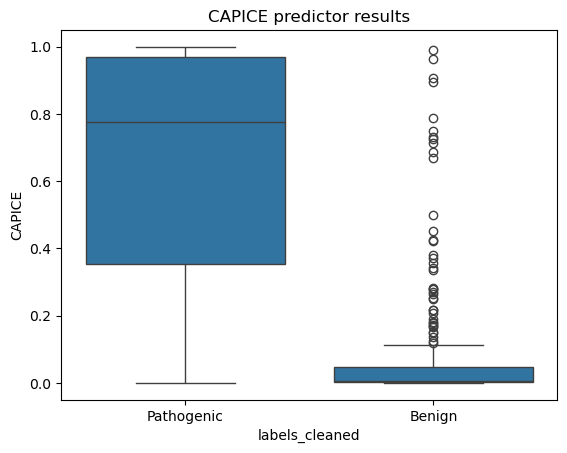

F1 score Combined/IndeLLM best small indels: 0.8057040998217468
F1 score CAPICE small indels: 0.8787346221441125
Accuracy score Combined/IndeLLM best small indels: 0.8070796460176991
Accuracy score CAPICE small indels: 0.8776595744680851
MCC Combined/IndeLLM best small indels: 0.614185465395214
MCC CAPICE small indels: 0.7553495892897693


Text(0.5, 0, 'False Positives (Specificty)')

Text(0, 0.5, 'Trule Positives (Sensitivity)')

Text(0.5, 1.0, 'ROC Curve for our predictions')

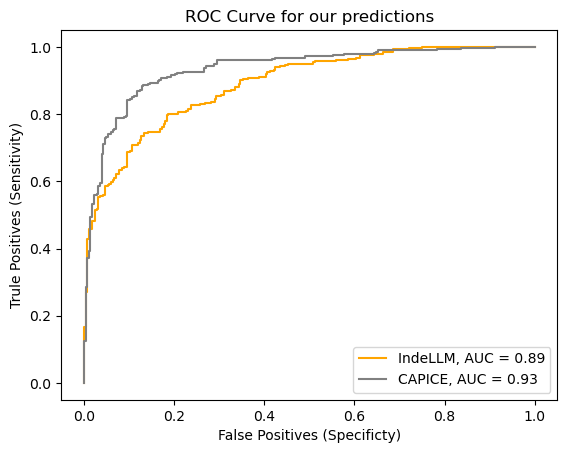

In [39]:
#Some of the columns in CAPICE contain no prediction, so filer the dataset
keptlabels['CAPICE'] = pd.to_numeric(keptlabels['CAPICE'], errors='coerce')
filtered_CAPICE = keptlabels.dropna(subset=['CAPICE'])
pred_CAPICE = filtered_CAPICE['CAPICE'].values
truelabels_CAPICE = filtered_CAPICE['labels_binary'].values

filtered_CAPICE.describe()

#Boxplot of CAPICE
plt.title('CAPICE predictor results')
sns.boxplot(x = filtered_CAPICE['labels_cleaned'], y = filtered_CAPICE['CAPICE'])
plt.show()

#The CAPICE predicts benig as 0, while pathogenic as 1. So have to change 0 to 1 and 1 to 0
truelabels_CAPICE -= 1
truelabels_CAPICE = np.abs(truelabels_CAPICE) 

#Calculating FP, TN and thresholds
fpr_CAPICE, tpr_CAPICE, thersholds_CAPICE = metrics.roc_curve(truelabels_CAPICE, pred_CAPICE)
roc_auc_CAPICE = round(metrics.auc(fpr_CAPICE, tpr_CAPICE), 2)

#Calculating F1 score
tresh_CAPICE = thersholds_CAPICE[np.argmax(tpr_CAPICE - fpr_CAPICE)]
pred_CAPICE_bin = [1 if x >= tresh_CAPICE else 0 for x in pred_CAPICE]
f1_CAPICE = f1_score(truelabels_CAPICE, pred_CAPICE_bin, average = 'binary')

#Calculating accuary score
accuracy_CAPICE = accuracy_score(truelabels_CAPICE, pred_CAPICE_bin)

#Calculating MCC
mcc_CAPICE = matthews_corrcoef(truelabels_CAPICE, pred_CAPICE_bin)

print("F1 score Combined/IndeLLM best small indels:", f1_best)
print("F1 score CAPICE small indels:", f1_CAPICE)

print("Accuracy score Combined/IndeLLM best small indels:", accuracy_best)
print("Accuracy score CAPICE small indels:", accuracy_CAPICE)

print("MCC Combined/IndeLLM best small indels:", mcc_best)
print("MCC CAPICE small indels:", mcc_CAPICE)

#Plotting the Evo, Fit and CAPICE AUC 
plt.plot(fpr_best, tpr_best, label = "IndeLLM, AUC = "+str(roc_auc_best), color = "orange")
plt.plot(fpr_CAPICE, tpr_CAPICE, label = "CAPICE, AUC = "+str(roc_auc_CAPICE), color = "grey")
plt.xlabel('False Positives (Specificty)')
plt.ylabel('Trule Positives (Sensitivity)')
plt.title("ROC Curve for our predictions")
plt.legend(loc = 'best')
plt.show()

/tmp/ipykernel_3596441/1036471111.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_CAPICE['correct'] = None


<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

Text(0.5, 1.0, 'Procentage of indel type')

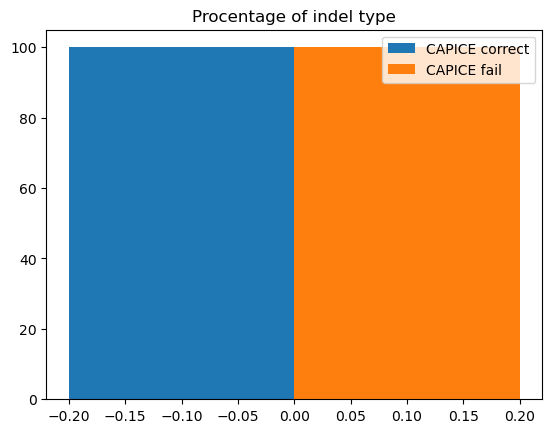

,CAPICEcorrect,CAPICEfail
length_indel,,
1,191,32.0
2,62,6.0
3,49,7.0
4,54,8.0
5,35,3.0
6,37,3.0
7,23,6.0
8,23,4.0
9,10,0.0


<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

([<matplotlib.axis.XTick at 0x741b3283ee70>,
 [Text(0, 0, '1'), Text(1, 0, '2-4'), Text(2, 0, '5-10')])

Text(0.5, 1.0, 'Procentage of indel size')

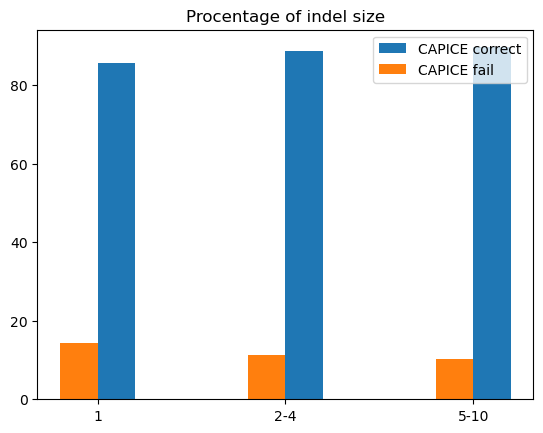

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

([<matplotlib.axis.XTick at 0x741b328d3650>,
 [Text(0, 0, '1-250'), Text(1, 0, '251-500')])

Text(0.5, 1.0, 'Procentage of wt aa length')

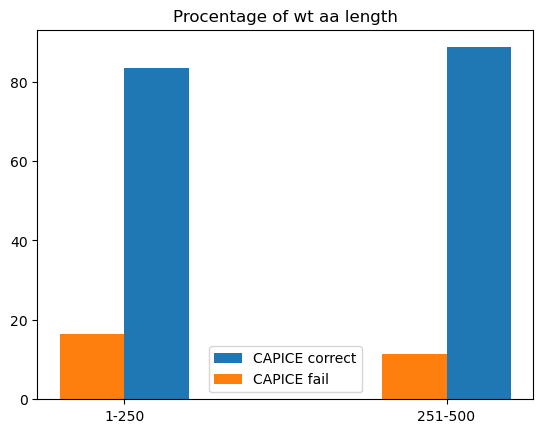

In [94]:
# See how CAPICE handles different types of indels and protein lengths
# Check which values the model calls correctly
filtered_CAPICE['correct'] = None 
filtered_CAPICE.loc[((filtered_CAPICE['CAPICE'] < tresh_CAPICE) & (filtered_CAPICE['labels_cleaned'] == 'Benign')) | 
        ((filtered_CAPICE['CAPICE'] >= tresh_CAPICE) & (filtered_CAPICE['labels_cleaned'] == 'Pathogenic')), 'correct'] = 'True'

#Dataframes with correcly called by both, failed by both, and what one manages and the other don't
CAPICEcorrect = filtered_CAPICE.loc[((filtered_CAPICE['correct'] == 'True'))]
CAPICEfail = filtered_CAPICE.loc[((filtered_CAPICE['correct'].isnull()))]

# Indel type 
CAPICEcorrect_indeltype = CAPICEcorrect['indel'].value_counts()
CAPICEfail_indeltype = CAPICEfail['indel'].value_counts()
indeltype = ('Deletion', 'Insertion')

plt.bar(np.arange(len(CAPICEcorrect_indeltype.index)) - 0.1 , ((CAPICEcorrect_indeltype.values / len(CAPICEcorrect)) * 100) , 0.2, label = 'CAPICE correct')
plt.bar(np.arange(len(CAPICEfail_indeltype.index)) + 0.1, ((CAPICEfail_indeltype.values / len(CAPICEfail)) * 100), 0.2, label = 'CAPICE fail')
plt.legend(loc = 'best')
plt.title('Procentage of indel type')
#plt.xticks(np.arange(len(CAPICEcorrect_indeltype)), indeltype)
plt.show()

# Indel size
CAPICEcorrect_indelsize = CAPICEcorrect['length_indel'].value_counts()
CAPICEfail_indelsize = CAPICEfail['length_indel'].value_counts()

indelsizeCAPICE = pd.DataFrame({
    'CAPICEcorrect': CAPICEcorrect_indelsize,
    'CAPICEfail': CAPICEfail_indelsize,
    }).fillna(0)

#Group the indel sizes after Cannon et al. 2023 ((0), 1, 2-4, 5-10 and 11+)

indelsizeCAPICE #Check that it conatins all types of indels

indels2to4CAPICE = indelsizeCAPICE.loc[2:4].sum()
indels5to10CAPICE = indelsizeCAPICE.loc[5:10].sum()

indelsizeCAPICE_grouped = pd.DataFrame({
    'Indel size': ['1', '2-4', '5-10'],
    'CAPICEcorrect': [indelsizeCAPICE.loc[1, 'CAPICEcorrect'], indels2to4CAPICE['CAPICEcorrect'], indels5to10CAPICE['CAPICEcorrect']],
    'CAPICEfail': [indelsizeCAPICE.loc[1, 'CAPICEfail'], indels2to4CAPICE['CAPICEfail'], indels5to10CAPICE['CAPICEfail']]
})

labels = ['1', '2-4', '5-10']

#Calculate procentage
indelsumCAPICE = indelsizeCAPICE_grouped[['CAPICEcorrect', 'CAPICEfail']].sum(axis=1)
percentageCAPICE = indelsizeCAPICE_grouped[['CAPICEcorrect', 'CAPICEfail']].div(indelsumCAPICE, axis=0) * 100
percentageCAPICE.insert(0, 'Indel size', indelsizeCAPICE_grouped['Indel size'])


plt.bar(np.arange(len(percentageCAPICE)) + 0.1, percentageCAPICE['CAPICEcorrect'], 0.2, label = 'CAPICE correct')
plt.bar(np.arange(len(percentageCAPICE)) - 0.1, percentageCAPICE['CAPICEfail'], 0.2, label = 'CAPICE fail')
plt.xticks(np.arange(len(percentageCAPICE)), labels)
plt.legend(loc = 'best')
plt.title('Procentage of indel size')
plt.show()

# Protein length 
CAPICEcorrect_aasize = CAPICEcorrect['length_wt'].value_counts()
CAPICEfail_aasize = CAPICEfail['length_wt'].value_counts()

CAPICEaasize = pd.DataFrame({
    'CAPICEcorrect': CAPICEcorrect_aasize,
    'CAPICEfail': CAPICEfail_aasize
}).fillna(0)

aaranges2 = [(0, 250), (251, 500)]

CAPICEsummarized_data = {
    'Range': [],
    'CAPICEcorrect': [],
    'CAPICEfail': []
}

for start, end in aaranges2:
    range_label = f'{start}-{end}'
    range_sum = CAPICEaasize.loc[start:end].sum()
    
    CAPICEsummarized_data['Range'].append(range_label)
    CAPICEsummarized_data['CAPICEcorrect'].append(range_sum['CAPICEcorrect'])
    CAPICEsummarized_data['CAPICEfail'].append(range_sum['CAPICEfail'])

# Creating a new DataFrame with the summarized values
CAPICEsummarized_df = pd.DataFrame(CAPICEsummarized_data)

labels2 = ['1-250', '251-500']

#Calculate procentage
sizesumCAPICE = CAPICEsummarized_df[['CAPICEcorrect', 'CAPICEfail']].sum(axis=1)
percentageCAPICEsize = CAPICEsummarized_df[['CAPICEcorrect', 'CAPICEfail']].div(sizesumCAPICE, axis=0) * 100
percentageCAPICEsize.insert(0, 'Range', CAPICEsummarized_df['Range'])

plt.bar(np.arange(len(percentageCAPICEsize)) + 0.1, percentageCAPICEsize['CAPICEcorrect'], 0.2, label = 'CAPICE correct')
plt.bar(np.arange(len(percentageCAPICEsize)) - 0.1, percentageCAPICEsize['CAPICEfail'], 0.2, label = 'CAPICE fail')
plt.xticks(np.arange(len(percentageCAPICEsize)), labels2)
plt.legend(loc = 'best')
plt.title('Procentage of wt aa length')
plt.show()

PROVEAN Choi et al. 2012: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0046688

We have developed a new algorithm, PROVEAN (Protein Variation Effect Analyzer), which provides a generalized approach to predict the functional effects of protein sequence variations including single or multiple amino acid substitutions, and in-frame insertions and deletions. In any protein sequence (!)

The UniProt human protein variation dataset used in this study contains a single amino acid substitution dataset and a one to six amino acid in-frame indel dataset. The human single amino acid substitution dataset was obtained from the UniProt “Human Polymorphisms and Disease Mutations” dataset (Release 2011_09; http://www.uniprot.org/docs/humsavar), which contains 20,821 pre-annotated disease variants and 36,825 common polymorphisms. The human small in-frame indel dataset was built in-house from additional types of natural variations including deletions, insertions, and replacements (in-frame substitution of multiple amino acids) of length up to 6 amino acids from the UniProtKB/Swiss-Prot database (Dataset S1).

Testet for our deletion (bbarrel 3aa del), predicted as deleterious (-9.221 score, threshold -2.5)
![alt text](image.png)

,key_0,Unnamed: 0,Id_matching,Protein_start,Protein_stop,Unnamed: 0_y,start-b38,stop-b38,CADD,CAPICE,...,length_wt,evo_mut,evo_wt,fit_mut,fit_wt,length_indel,dif_evo,dif_fit,labels_binary,dif_best
count,507.000000,507.000000,507.000000,507.000000,507.000000,0.0,5.070000e+02,5.070000e+02,507.000000,507.000000,...,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000
mean,2015.499014,1946.712032,2015.499014,177.911243,180.982249,NaN,7.234073e+07,7.234074e+07,16.564272,0.371869,...,355.475345,289.807391,294.433668,116.241919,119.442362,3.284024,-4.626277,-3.200443,0.502959,-4.156060
std,1138.284882,1095.614580,1138.284882,113.535050,113.464982,NaN,5.955112e+07,5.955112e+07,5.308067,0.398108,...,96.682137,80.136744,80.340590,61.484109,62.651259,2.540230,3.582692,4.397388,0.500485,4.801225
min,1.000000,1.000000,1.000000,2.000000,4.000000,NaN,4.744600e+04,4.745500e+04,0.314000,0.000007,...,65.000000,38.754637,40.831130,9.631793,8.818169,1.000000,-22.946907,-40.365060,0.000000,-40.365060
25%,1117.500000,1083.500000,1117.500000,85.000000,87.000000,NaN,2.744832e+07,2.744833e+07,14.130000,0.005903,...,305.000000,241.401149,245.327420,66.998959,67.847498,1.000000,-6.441656,-4.762878,0.000000,-5.999885
50%,1946.000000,1887.000000,1946.000000,169.000000,171.000000,NaN,5.425557e+07,5.425557e+07,17.910000,0.176459,...,367.000000,297.457157,302.013060,100.423642,104.280063,2.000000,-3.796409,-2.233934,1.000000,-2.966806
75%,2955.500000,2852.500000,2955.500000,248.000000,253.500000,NaN,1.098744e+08,1.098744e+08,20.700000,0.819887,...,432.000000,355.852236,359.729798,161.374989,165.505995,5.000000,-1.900334,-0.522528,1.000000,-0.901639
max,3955.000000,3811.000000,3955.000000,478.000000,479.000000,NaN,2.482950e+08,2.482951e+08,24.800000,0.999197,...,500.000000,449.243205,450.935780,296.511972,302.809842,10.000000,0.187187,4.589211,1.000000,4.110325


Text(0.5, 1.0, 'PROVEAN predictor results')

<Axes: title={'center': 'PROVEAN predictor results'}, xlabel='labels_cleaned', ylabel='PROVEAN'>

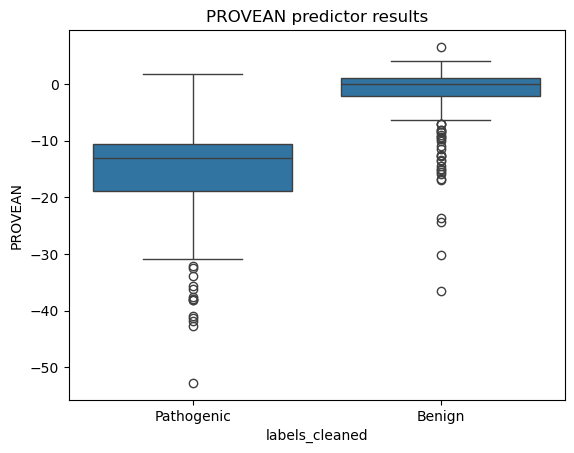

F1 score Combined/IndeLLM best small indels: 0.8057040998217468
F1 score PROVEAN small indels: 0.9065606361829026
Accuracy score Combined/IndeLLM best small indels: 0.8070796460176991
Accuracy score PROVEAN small indels: 0.9072978303747534
MCC Combined/IndeLLM best small indels: 0.614185465395214
MCC PROVEAN small indels: 0.8149301317293477


Text(0.5, 0, 'False Positives (Specificty)')

Text(0, 0.5, 'Trule Positives (Sensitivity)')

Text(0.5, 1.0, 'ROC Curve for our predictions')

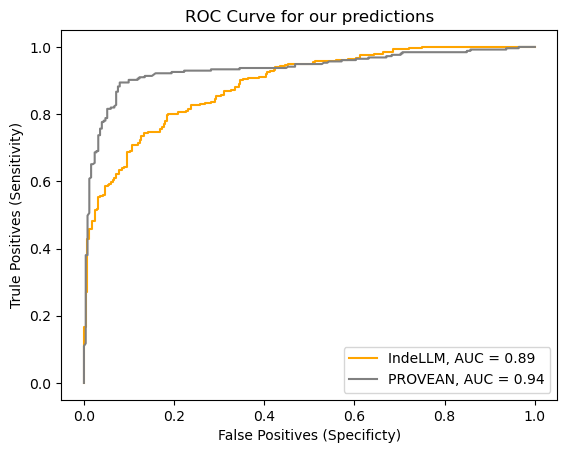

In [41]:
#Some of the columns in PROVEAN contain no prediction, so filer the dataset
keptlabels['PROVEAN'] = pd.to_numeric(keptlabels['PROVEAN'], errors='coerce')
filtered_PROVEAN = keptlabels.dropna(subset=['PROVEAN'])
pred_PROVEAN = filtered_PROVEAN['PROVEAN'].values
truelabels_PROVEAN = filtered_PROVEAN['labels_binary'].values

filtered_PROVEAN.describe()

#Boxplot of PROVEAN
plt.title('PROVEAN predictor results')
sns.boxplot(x = filtered_PROVEAN['labels_cleaned'], y = filtered_PROVEAN['PROVEAN'])
plt.show()

#Calculating FP, TN and thresholds
fpr_PROVEAN, tpr_PROVEAN, thersholds_PROVEAN = metrics.roc_curve(truelabels_PROVEAN, pred_PROVEAN)
roc_auc_PROVEAN = round(metrics.auc(fpr_PROVEAN, tpr_PROVEAN), 2)

#Calculating F1 score
tresh_PROVEAN = thersholds_PROVEAN[np.argmax(tpr_PROVEAN - fpr_PROVEAN)]
pred_PROVEAN_bin = [1 if x >= tresh_PROVEAN else 0 for x in pred_PROVEAN]
f1_PROVEAN = f1_score(truelabels_PROVEAN, pred_PROVEAN_bin, average = 'binary')

#Calculating accuary score
accuracy_PROVEAN = accuracy_score(truelabels_PROVEAN, pred_PROVEAN_bin)

#Calculating MCC
mcc_PROVEAN = matthews_corrcoef(truelabels_PROVEAN, pred_PROVEAN_bin)

print("F1 score Combined/IndeLLM best small indels:", f1_best)
print("F1 score PROVEAN small indels:", f1_PROVEAN)

print("Accuracy score Combined/IndeLLM best small indels:", accuracy_best)
print("Accuracy score PROVEAN small indels:", accuracy_PROVEAN)

print("MCC Combined/IndeLLM best small indels:", mcc_best)
print("MCC PROVEAN small indels:", mcc_PROVEAN)

#Plotting the Evo, Fit and PROVEAN AUC 
plt.plot(fpr_best, tpr_best, label = "IndeLLM, AUC = "+str(roc_auc_best), color = "orange")
plt.plot(fpr_PROVEAN, tpr_PROVEAN, label = "PROVEAN, AUC = "+str(roc_auc_PROVEAN), color = "grey")
plt.xlabel('False Positives (Specificty)')
plt.ylabel('Trule Positives (Sensitivity)')
plt.title("ROC Curve for our predictions")
plt.legend(loc = 'best')
plt.show()

/tmp/ipykernel_3596441/1519756952.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_PROVEAN['correct'] = None


<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

Text(0.5, 1.0, 'Procentage of indel type')

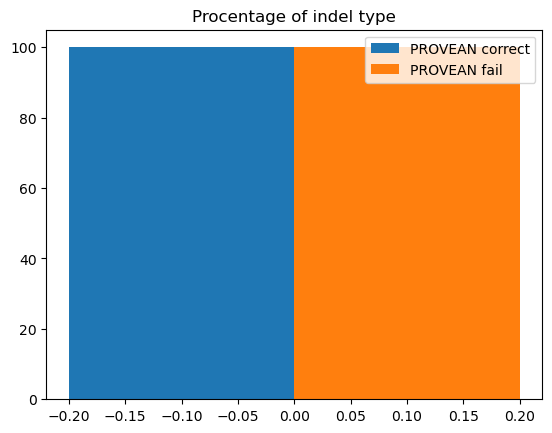

,PROVEANcorrect,PROVEANfail
length_indel,,
1,172,28
2,58,3
3,43,1
4,54,1
5,34,3
6,37,2
7,23,3
8,20,5
9,9,1


<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

([<matplotlib.axis.XTick at 0x741b32a86150>,
 [Text(0, 0, '1'), Text(1, 0, '2-4'), Text(2, 0, '5-10')])

Text(0.5, 1.0, 'Procentage of indel size')

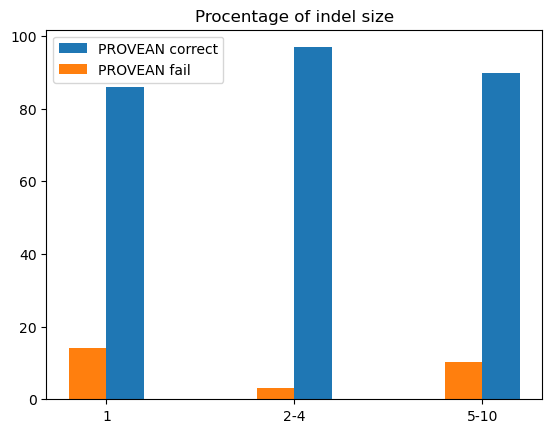

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

([<matplotlib.axis.XTick at 0x741b32872a80>,
 [Text(0, 0, '1-250'), Text(1, 0, '251-500')])

Text(0.5, 1.0, 'Procentage of wt aa length')

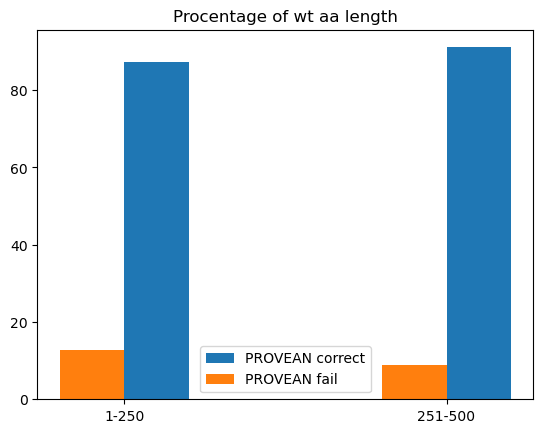

In [95]:
# See how PROVEAN handles different types of indels and protein lengths
# Check which values the model calls correctly
filtered_PROVEAN['correct'] = None 
filtered_PROVEAN.loc[((filtered_PROVEAN['PROVEAN'] > tresh_PROVEAN) & (filtered_PROVEAN['labels_cleaned'] == 'Benign')) | 
        ((filtered_PROVEAN['PROVEAN'] <= tresh_PROVEAN) & (filtered_PROVEAN['labels_cleaned'] == 'Pathogenic')), 'correct'] = 'True'

#Dataframes with correcly called by both, failed by both, and what one manages and the other don't
PROVEANcorrect = filtered_PROVEAN.loc[((filtered_PROVEAN['correct'] == 'True'))]
PROVEANfail = filtered_PROVEAN.loc[((filtered_PROVEAN['correct'].isnull()))]

# Indel type 
PROVEANcorrect_indeltype = PROVEANcorrect['indel'].value_counts()
PROVEANfail_indeltype = PROVEANfail['indel'].value_counts()
indeltype = ('Deletion', 'Insertion')

plt.bar(np.arange(len(PROVEANcorrect_indeltype.index)) - 0.1 , ((PROVEANcorrect_indeltype.values / len(PROVEANcorrect)) * 100) , 0.2, label = 'PROVEAN correct')
plt.bar(np.arange(len(PROVEANfail_indeltype.index)) + 0.1, ((PROVEANfail_indeltype.values / len(PROVEANfail)) * 100), 0.2, label = 'PROVEAN fail')
plt.legend(loc = 'best')
plt.title('Procentage of indel type')
#plt.xticks(np.arange(len(PROVEANcorrect_indeltype)), indeltype)
plt.show()

# Indel size
PROVEANcorrect_indelsize = PROVEANcorrect['length_indel'].value_counts()
PROVEANfail_indelsize = PROVEANfail['length_indel'].value_counts()

indelsizePROVEAN = pd.DataFrame({
    'PROVEANcorrect': PROVEANcorrect_indelsize,
    'PROVEANfail': PROVEANfail_indelsize,
    }).fillna(0)

#Group the indel sizes after Cannon et al. 2023 ((0), 1, 2-4, 5-10 and 11+)

indelsizePROVEAN #Check that it conatins all types of indels

indels2to4PROVEAN = indelsizePROVEAN.loc[2:4].sum()
indels5to10PROVEAN = indelsizePROVEAN.loc[5:10].sum()

indelsizePROVEAN_grouped = pd.DataFrame({
    'Indel size': ['1', '2-4', '5-10'],
    'PROVEANcorrect': [indelsizePROVEAN.loc[1, 'PROVEANcorrect'], indels2to4PROVEAN['PROVEANcorrect'], indels5to10PROVEAN['PROVEANcorrect']],
    'PROVEANfail': [indelsizePROVEAN.loc[1, 'PROVEANfail'], indels2to4PROVEAN['PROVEANfail'], indels5to10PROVEAN['PROVEANfail']]
})

labels = ['1', '2-4', '5-10']

#Calculate procentage
indelsumPROVEAN = indelsizePROVEAN_grouped[['PROVEANcorrect', 'PROVEANfail']].sum(axis=1)
percentagePROVEAN = indelsizePROVEAN_grouped[['PROVEANcorrect', 'PROVEANfail']].div(indelsumPROVEAN, axis=0) * 100
percentagePROVEAN.insert(0, 'Indel size', indelsizePROVEAN_grouped['Indel size'])

plt.bar(np.arange(len(percentagePROVEAN)) + 0.1, percentagePROVEAN['PROVEANcorrect'], 0.2, label = 'PROVEAN correct')
plt.bar(np.arange(len(percentagePROVEAN)) - 0.1, percentagePROVEAN['PROVEANfail'], 0.2, label = 'PROVEAN fail')
plt.xticks(np.arange(len(percentagePROVEAN)), labels)
plt.legend(loc = 'best')
plt.title('Procentage of indel size')
plt.show()

# Protein length 
PROVEANcorrect_aasize = PROVEANcorrect['length_wt'].value_counts()
PROVEANfail_aasize = PROVEANfail['length_wt'].value_counts()

PROVEANaasize = pd.DataFrame({
    'PROVEANcorrect': PROVEANcorrect_aasize,
    'PROVEANfail': PROVEANfail_aasize
}).fillna(0)

aaranges2 = [(0, 250), (251, 500)]

PROVEANsummarized_data = {
    'Range': [],
    'PROVEANcorrect': [],
    'PROVEANfail': []
}

for start, end in aaranges2:
    range_label = f'{start}-{end}'
    range_sum = PROVEANaasize.loc[start:end].sum()
    
    PROVEANsummarized_data['Range'].append(range_label)
    PROVEANsummarized_data['PROVEANcorrect'].append(range_sum['PROVEANcorrect'])
    PROVEANsummarized_data['PROVEANfail'].append(range_sum['PROVEANfail'])

# Creating a new DataFrame with the summarized values
PROVEANsummarized_df = pd.DataFrame(PROVEANsummarized_data)

labels2 = ['1-250', '251-500']

#Calculate procentage
sizesumPROVEAN = PROVEANsummarized_df[['PROVEANcorrect', 'PROVEANfail']].sum(axis=1)
percentagePROVEANsize = PROVEANsummarized_df[['PROVEANcorrect', 'PROVEANfail']].div(sizesumPROVEAN, axis=0) * 100
percentagePROVEANsize.insert(0, 'Range', PROVEANsummarized_df['Range'])

plt.bar(np.arange(len(percentagePROVEANsize)) + 0.1, percentagePROVEANsize['PROVEANcorrect'], 0.2, label = 'PROVEAN correct')
plt.bar(np.arange(len(percentagePROVEANsize)) - 0.1, percentagePROVEANsize['PROVEANfail'], 0.2, label = 'PROVEAN fail')
plt.xticks(np.arange(len(percentagePROVEANsize)), labels2)
plt.legend(loc = 'best')
plt.title('Procentage of wt aa length')
plt.show()

MutationTaster2021 Steinhaus et al. 2021: https://academic.oup.com/nar/article/49/W1/W446/6249609

Here we present an update to MutationTaster, our DNA variant effect prediction tool. The new version uses a different prediction model and attains higher accuracy than its predecessor, especially for rare benign variants. In addition, we have integrated many sources of data that only became available after the last release (such as gnomAD and ExAC pLI scores) and changed the splice site prediction model. To more easily assess the relevance of detected known disease mutations to the clinical phenotype of the patient, MutationTaster now provides information on the diseases they cause.


/tmp/ipykernel_3596441/1561690791.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_MutationTaster2021['MutationTaster2021_bin'] = [ 1 if x == 'Benign' else 0 for x in filtered_MutationTaster2021['MutationTaster2021']]


,key_0,Unnamed: 0,Id_matching,Protein_start,Protein_stop,Unnamed: 0_y,start-b38,stop-b38,CADD,CAPICE,...,evo_mut,evo_wt,fit_mut,fit_wt,length_indel,dif_evo,dif_fit,labels_binary,dif_best,MutationTaster2021_bin
count,533.000000,533.000000,533.000000,533.000000,533.00000,0.0,5.330000e+02,5.330000e+02,533.000000,533.000000,...,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000
mean,2023.606004,1954.491557,2023.606004,176.196998,179.21576,NaN,7.116199e+07,7.116200e+07,16.792062,0.381837,...,290.569878,295.231870,117.626254,120.893478,3.227017,-4.661993,-3.267224,0.480300,-4.273366,0.452158
std,1139.457849,1096.755286,1139.457849,113.973304,113.91771,NaN,5.954608e+07,5.954608e+07,5.163203,0.399334,...,79.203160,79.353688,60.865528,61.951108,2.503956,3.526574,4.345685,0.500081,4.724268,0.498173
min,1.000000,1.000000,1.000000,2.000000,4.00000,NaN,4.744600e+04,4.745500e+04,0.534000,0.000007,...,38.754637,40.831130,9.631793,8.818169,1.000000,-22.946907,-40.365060,0.000000,-40.365060,0.000000
25%,1118.000000,1084.000000,1118.000000,77.000000,81.00000,NaN,2.520983e+07,2.520983e+07,14.550000,0.006891,...,243.059353,245.327420,67.324480,67.849393,1.000000,-6.419005,-4.811773,0.000000,-6.053847,0.000000
50%,1976.000000,1917.000000,1976.000000,168.000000,170.00000,NaN,5.052610e+07,5.052611e+07,18.040000,0.203606,...,297.457157,302.013060,102.375312,104.487506,2.000000,-3.846082,-2.417289,0.000000,-3.232312,0.000000
75%,2964.000000,2860.000000,2964.000000,248.000000,253.00000,NaN,1.086237e+08,1.086237e+08,20.800000,0.834892,...,356.692766,359.729798,163.393117,168.328095,5.000000,-1.958872,-0.601855,1.000000,-1.043235,1.000000
max,3957.000000,3813.000000,3957.000000,478.000000,479.00000,NaN,2.482950e+08,2.482951e+08,24.800000,0.999197,...,449.243205,450.935780,296.511972,302.809842,10.000000,0.187187,4.589211,1.000000,4.110325,1.000000


Text(0.5, 1.0, 'MutationTaster2021 predictor results')

<Axes: title={'center': 'MutationTaster2021 predictor results'}, xlabel='labels_cleaned', ylabel='MutationTaster2021_bin'>

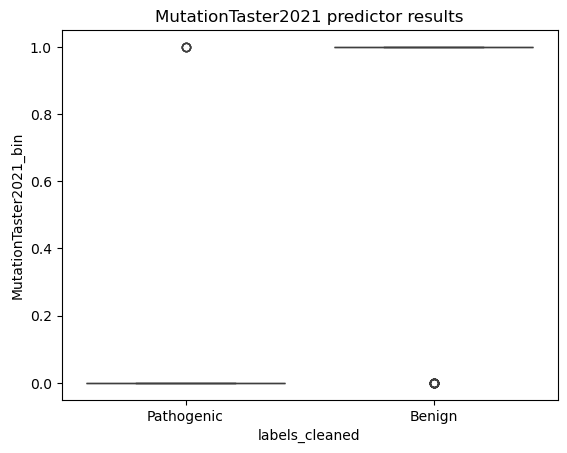

F1 score Combined/IndeLLM best small indels: 0.8057040998217468
F1 score MutationTaster2021 small indels: 0.9537223340040242
Accuracy score Combined/IndeLLM best small indels: 0.8070796460176991
Accuracy score MutationTaster2021 small indels: 0.9568480300187617
MCC Combined/IndeLLM best small indels: 0.614185465395214
MCC MutationTaster2021 small indels: 0.9148307244685181


Text(0.5, 0, 'False Positives (Specificty)')

Text(0, 0.5, 'Trule Positives (Sensitivity)')

Text(0.5, 1.0, 'ROC Curve for our predictions')

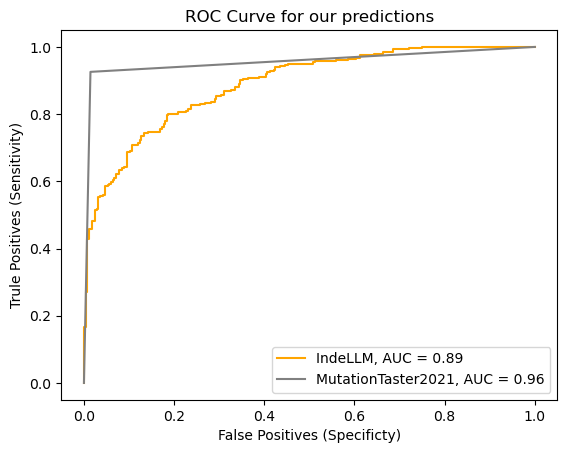

In [43]:
#Some of the columns in MutationTaster2021 contain no prediction, so filter the dataset
filtered_MutationTaster2021 = keptlabels.dropna(subset=['MutationTaster2021'])

filtered_MutationTaster2021['MutationTaster2021_bin'] = [ 1 if x == 'Benign' else 0 for x in filtered_MutationTaster2021['MutationTaster2021']]
pred_MutationTaster2021 = filtered_MutationTaster2021['MutationTaster2021_bin'].values
truelabels_MutationTaster2021 = filtered_MutationTaster2021['labels_binary'].values

filtered_MutationTaster2021.describe()

#Boxplot of MutationTaster2021
plt.title('MutationTaster2021 predictor results')
sns.boxplot(x = filtered_MutationTaster2021['labels_cleaned'], y = filtered_MutationTaster2021['MutationTaster2021_bin'])
plt.show()

#Calculating FP, TN and thresholds
fpr_MutationTaster2021, tpr_MutationTaster2021, thersholds_MutationTaster2021 = metrics.roc_curve(truelabels_MutationTaster2021, pred_MutationTaster2021)
roc_auc_MutationTaster2021 = round(metrics.auc(fpr_MutationTaster2021, tpr_MutationTaster2021), 2)

#Calculating F1 score
tresh_MutationTaster2021 = thersholds_MutationTaster2021[np.argmax(tpr_MutationTaster2021 - fpr_MutationTaster2021)]
f1_MutationTaster2021 = f1_score(truelabels_MutationTaster2021, pred_MutationTaster2021, average = 'binary')

#Calculating accuary score
accuracy_MutationTaster2021 = accuracy_score(truelabels_MutationTaster2021, pred_MutationTaster2021)

#Calculating MCC
mcc_MutationTaster2021 = matthews_corrcoef(truelabels_MutationTaster2021, pred_MutationTaster2021)

print("F1 score Combined/IndeLLM best small indels:", f1_best)
print("F1 score MutationTaster2021 small indels:", f1_MutationTaster2021)

print("Accuracy score Combined/IndeLLM best small indels:", accuracy_best)
print("Accuracy score MutationTaster2021 small indels:", accuracy_MutationTaster2021)

print("MCC Combined/IndeLLM best small indels:", mcc_best)
print("MCC MutationTaster2021 small indels:", mcc_MutationTaster2021)

#Plotting the Evo, Fit and MutationTaster2021 AUC 
plt.plot(fpr_best, tpr_best, label = "IndeLLM, AUC = "+str(roc_auc_best), color = "orange")
plt.plot(fpr_MutationTaster2021, tpr_MutationTaster2021, label = "MutationTaster2021, AUC = "+str(roc_auc_MutationTaster2021), color = "grey")
plt.xlabel('False Positives (Specificty)')
plt.ylabel('Trule Positives (Sensitivity)')
plt.title("ROC Curve for our predictions")
plt.legend(loc = 'best')
plt.show()

/tmp/ipykernel_3596441/3197275634.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_MutationTaster2021['correct'] = None


<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

Text(0.5, 1.0, 'Procentage of indel type')

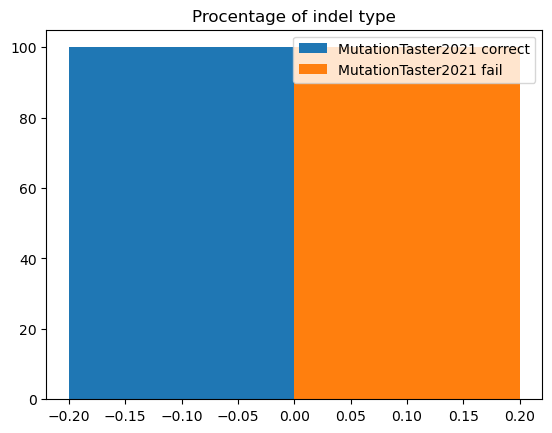

,MutationTaster2021correct,MutationTaster2021fail
length_indel,,
1,148,64
2,25,39
3,30,22
4,18,39
5,20,18
6,15,24
7,10,16
8,6,19
9,4,6


<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

([<matplotlib.axis.XTick at 0x741b32f97920>,
 [Text(0, 0, '1'), Text(1, 0, '2-4'), Text(2, 0, '5-10')])

Text(0.5, 1.0, 'Procentage of indel size')

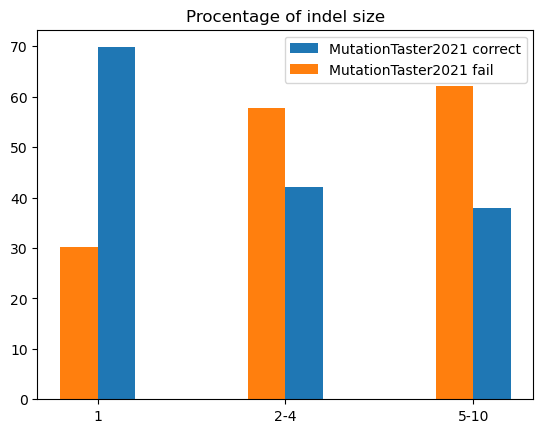

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

([<matplotlib.axis.XTick at 0x741b330e9970>,
 [Text(0, 0, '1-250'), Text(1, 0, '251-500')])

Text(0.5, 1.0, 'Procentage of wt aa length')

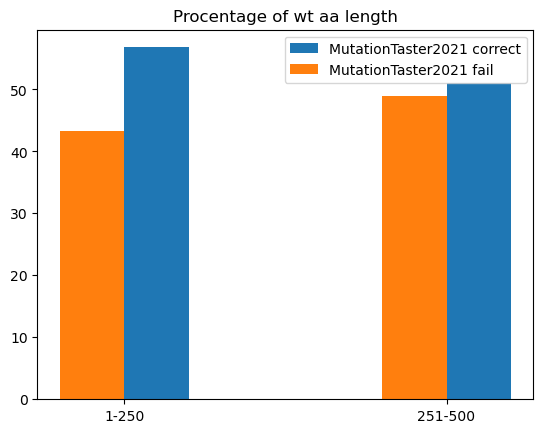

In [97]:
# See how MutationTaster2021 handles different types of indels and protein lengths
# Check which values the model calls correctly
filtered_MutationTaster2021['correct'] = None 
filtered_MutationTaster2021.loc[((filtered_MutationTaster2021['MutationTaster2021_bin'] > tresh_MutationTaster2021) & (filtered_MutationTaster2021['labels_cleaned'] == 'Benign')) | 
        ((filtered_MutationTaster2021['MutationTaster2021_bin'] <= tresh_MutationTaster2021) & (filtered_MutationTaster2021['labels_cleaned'] == 'Pathogenic')), 'correct'] = 'True'

#Dataframes with correcly called by both, failed by both, and what one manages and the other don't
MutationTaster2021correct = filtered_MutationTaster2021.loc[((filtered_MutationTaster2021['correct'] == 'True'))]
MutationTaster2021fail = filtered_MutationTaster2021.loc[((filtered_MutationTaster2021['correct'].isnull()))]

# Indel type 
MutationTaster2021correct_indeltype = MutationTaster2021correct['indel'].value_counts()
MutationTaster2021fail_indeltype = MutationTaster2021fail['indel'].value_counts()
indeltype = ('Deletion', 'Insertion')

plt.bar(np.arange(len(MutationTaster2021correct_indeltype.index)) - 0.1 , ((MutationTaster2021correct_indeltype.values / len(MutationTaster2021correct)) * 100) , 0.2, label = 'MutationTaster2021 correct')
plt.bar(np.arange(len(MutationTaster2021fail_indeltype.index)) + 0.1, ((MutationTaster2021fail_indeltype.values / len(MutationTaster2021fail)) * 100), 0.2, label = 'MutationTaster2021 fail')
plt.legend(loc = 'best')
plt.title('Procentage of indel type')
#plt.xticks(np.arange(len(MutationTaster2021correct_indeltype)), indeltype)
plt.show()

# Indel size
MutationTaster2021correct_indelsize = MutationTaster2021correct['length_indel'].value_counts()
MutationTaster2021fail_indelsize = MutationTaster2021fail['length_indel'].value_counts()

indelsizeMutationTaster2021 = pd.DataFrame({
    'MutationTaster2021correct': MutationTaster2021correct_indelsize,
    'MutationTaster2021fail': MutationTaster2021fail_indelsize,
    }).fillna(0)

#Group the indel sizes after Cannon et al. 2023 ((0), 1, 2-4, 5-10 and 11+)

indelsizeMutationTaster2021 #Check that it conatins all types of indels

indels2to4MutationTaster2021 = indelsizeMutationTaster2021.loc[2:4].sum()
indels5to10MutationTaster2021 = indelsizeMutationTaster2021.loc[5:10].sum()

indelsizeMutationTaster2021_grouped = pd.DataFrame({
    'Indel size': ['1', '2-4', '5-10'],
    'MutationTaster2021correct': [indelsizeMutationTaster2021.loc[1, 'MutationTaster2021correct'], indels2to4MutationTaster2021['MutationTaster2021correct'], indels5to10MutationTaster2021['MutationTaster2021correct']],
    'MutationTaster2021fail': [indelsizeMutationTaster2021.loc[1, 'MutationTaster2021fail'], indels2to4MutationTaster2021['MutationTaster2021fail'], indels5to10MutationTaster2021['MutationTaster2021fail']]
})

labels = ['1', '2-4', '5-10']

#Calculate procentage
indelsumMutationTaster2021 = indelsizeMutationTaster2021_grouped[['MutationTaster2021correct', 'MutationTaster2021fail']].sum(axis=1)
percentageMutationTaster2021 = indelsizeMutationTaster2021_grouped[['MutationTaster2021correct', 'MutationTaster2021fail']].div(indelsumMutationTaster2021, axis=0) * 100
percentageMutationTaster2021.insert(0, 'Indel size', indelsizeMutationTaster2021_grouped['Indel size'])

plt.bar(np.arange(len(percentageMutationTaster2021)) + 0.1, percentageMutationTaster2021['MutationTaster2021correct'], 0.2, label = 'MutationTaster2021 correct')
plt.bar(np.arange(len(percentageMutationTaster2021)) - 0.1, percentageMutationTaster2021['MutationTaster2021fail'], 0.2, label = 'MutationTaster2021 fail')
plt.xticks(np.arange(len(percentageMutationTaster2021)), labels)
plt.legend(loc = 'best')
plt.title('Procentage of indel size')
plt.show()

# Protein length 
MutationTaster2021correct_aasize = MutationTaster2021correct['length_wt'].value_counts()
MutationTaster2021fail_aasize = MutationTaster2021fail['length_wt'].value_counts()

MutationTaster2021aasize = pd.DataFrame({
    'MutationTaster2021correct': MutationTaster2021correct_aasize,
    'MutationTaster2021fail': MutationTaster2021fail_aasize
}).fillna(0)

aaranges2 = [(0, 250), (251, 500)]

MutationTaster2021summarized_data = {
    'Range': [],
    'MutationTaster2021correct': [],
    'MutationTaster2021fail': []
}

for start, end in aaranges2:
    range_label = f'{start}-{end}'
    range_sum = MutationTaster2021aasize.loc[start:end].sum()
    
    MutationTaster2021summarized_data['Range'].append(range_label)
    MutationTaster2021summarized_data['MutationTaster2021correct'].append(range_sum['MutationTaster2021correct'])
    MutationTaster2021summarized_data['MutationTaster2021fail'].append(range_sum['MutationTaster2021fail'])

# Creating a new DataFrame with the summarized values
MutationTaster2021summarized_df = pd.DataFrame(MutationTaster2021summarized_data)

labels2 = ['1-250', '251-500']

#Calculate procentage
sizesumMutationTaster2021 = MutationTaster2021summarized_df[['MutationTaster2021correct', 'MutationTaster2021fail']].sum(axis=1)
percentageMutationTaster2021size = MutationTaster2021summarized_df[['MutationTaster2021correct', 'MutationTaster2021fail']].div(sizesumMutationTaster2021, axis=0) * 100
percentageMutationTaster2021size.insert(0, 'Range', MutationTaster2021summarized_df['Range'])

plt.bar(np.arange(len(percentageMutationTaster2021size)) + 0.1, percentageMutationTaster2021size['MutationTaster2021correct'], 0.2, label = 'MutationTaster2021 correct')
plt.bar(np.arange(len(percentageMutationTaster2021size)) - 0.1, percentageMutationTaster2021size['MutationTaster2021fail'], 0.2, label = 'MutationTaster2021 fail')
plt.xticks(np.arange(len(percentageMutationTaster2021size)), labels2)
plt.legend(loc = 'best')
plt.title('Procentage of wt aa length')
plt.show()

MutPred-Indel Pagel et al. 2019: https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007112

We present a machine learning method, MutPred-Indel, that predicts pathogenicity and identifies types of functional residues impacted by non-frameshifting insertion/deletion variation.

Training data sets: Disease causing sequence-retaining insertion, deletion, and complex indel variants were obtained from the Human Gene Mutation Database (HGMD), professional version 2017.1 [36]. For brevity, we will refer to the set of non-frameshifting insertion, deletion, and complex indel variants collectively as “insertion/deletion variants” or simply “variants” for the remainder of the text. Putatively neutral insertion/deletion variants were derived from the Genome Aggregation Database (gnomAD) [44]. In the process of collecting data, variants from gnomAD with Allele Count (AC) annotation of zero were considered to be of low quality and removed from the training data. Variants annotated within gnomAD with AC equal to one were similarly removed to reduce noise that may arise as a consequence of variants called in error. For each variant, the wild-type and mutant protein sequence were determined using ANNOVAR [45]. The number of variants considered in model training are described in Table 2. In total, the training data comprised 5606 single residue deletions, 1033 single residue insertions, 2427 multi-residue insertions, 3052 multi-residue deletions, and 1253 complex indel variants.

,key_0,Unnamed: 0,Id_matching,Protein_start,Protein_stop,Unnamed: 0_y,start-b38,stop-b38,CADD,CAPICE,...,length_wt,evo_mut,evo_wt,fit_mut,fit_wt,length_indel,dif_evo,dif_fit,labels_binary,dif_best
count,558.000000,558.000000,558.000000,558.000000,558.000000,0.0,5.580000e+02,5.580000e+02,558.000000,557.000000,...,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000
mean,1999.715054,1931.467742,1999.715054,173.637993,176.679211,NaN,7.328604e+07,7.328605e+07,16.617633,0.370290,...,351.982079,286.937300,291.571353,116.071900,119.317844,3.258065,-4.634053,-3.245944,0.494624,-4.200756
std,1140.913880,1098.290644,1140.913880,114.827236,114.782689,NaN,6.142655e+07,6.142655e+07,5.239609,0.397523,...,99.028855,82.061286,82.255347,61.197883,62.291664,2.510602,3.498601,4.307747,0.500420,4.688032
min,1.000000,1.000000,1.000000,2.000000,4.000000,NaN,4.744600e+04,4.745500e+04,0.514000,0.000007,...,67.000000,38.754637,40.831130,9.631793,8.818169,1.000000,-22.946907,-40.365060,0.000000,-40.365060
25%,1052.750000,1020.500000,1052.750000,73.000000,75.000000,NaN,2.674306e+07,2.674306e+07,14.220000,0.005807,...,293.750000,238.147579,245.327420,67.009235,67.847732,1.000000,-6.401223,-4.811049,0.000000,-6.001018
50%,1946.500000,1887.500000,1946.500000,164.000000,167.000000,NaN,5.624736e+07,5.624738e+07,17.950000,0.171286,...,365.000000,296.323052,300.911272,101.789732,104.481740,2.000000,-3.821505,-2.362185,0.000000,-3.161660
75%,2952.750000,2849.750000,2952.750000,247.000000,252.000000,NaN,1.124329e+08,1.124329e+08,20.700000,0.813354,...,432.000000,353.696606,357.770283,161.689659,166.182673,5.000000,-1.957376,-0.626628,1.000000,-0.967638
max,3958.000000,3814.000000,3958.000000,478.000000,479.000000,NaN,2.482950e+08,2.482951e+08,24.800000,0.999197,...,500.000000,449.243205,450.935780,296.511972,302.809842,10.000000,0.187187,4.589211,1.000000,4.110325


Text(0.5, 1.0, 'MutPredIndel predictor results')

<Axes: title={'center': 'MutPredIndel predictor results'}, xlabel='labels_cleaned', ylabel='MutPredIndel'>

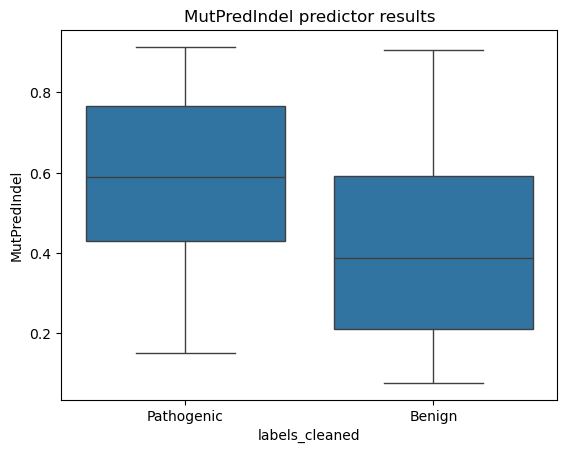

F1 score Combined/IndeLLM best small indels: 0.8057040998217468
F1 score MutPredIndel small indels: 0.5839080459770115
Accuracy score Combined/IndeLLM best small indels: 0.8070796460176991
Accuracy score MutPredIndel small indels: 0.6756272401433692
MCC Combined/IndeLLM best small indels: 0.614185465395214
MCC MutPredIndel small indels: 0.3991543841348221


Text(0.5, 0, 'False Positives (Specificty)')

Text(0, 0.5, 'Trule Positives (Sensitivity)')

Text(0.5, 1.0, 'ROC Curve for our predictions')

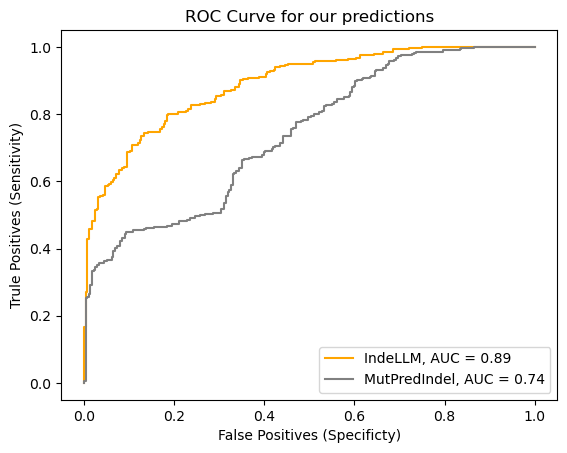

In [45]:
#Some of the columns in MutPredIndel contain no prediction, so filer the dataset
keptlabels['MutPredIndel'] = pd.to_numeric(keptlabels['MutPredIndel'], errors='coerce')
filtered_MutPredIndel = keptlabels.dropna(subset=['MutPredIndel'])
pred_MutPredIndel = filtered_MutPredIndel['MutPredIndel'].values
truelabels_MutPredIndel = filtered_MutPredIndel['labels_binary'].values

filtered_MutPredIndel.describe()

#Boxplot of MutPredIndel
plt.title('MutPredIndel predictor results')
sns.boxplot(x = filtered_MutPredIndel['labels_cleaned'], y = filtered_MutPredIndel['MutPredIndel'])
plt.show()

#The MutPredIndel predicts benig as 0, while pathogenic as 1. So have to change 0 to 1 and 1 to 0
truelabels_MutPredIndel -= 1
truelabels_MutPredIndel = np.abs(truelabels_MutPredIndel) 

#Calculating FP, TN and thresholds
fpr_MutPredIndel, tpr_MutPredIndel, thersholds_MutPredIndel = metrics.roc_curve(truelabels_MutPredIndel, pred_MutPredIndel)
roc_auc_MutPredIndel = round(metrics.auc(fpr_MutPredIndel, tpr_MutPredIndel), 2)

#Calculating F1 score
tresh_MutPredIndel = thersholds_MutPredIndel[np.argmax(tpr_MutPredIndel - fpr_MutPredIndel)]
pred_MutPredIndel_bin = [1 if x >= tresh_MutPredIndel else 0 for x in pred_MutPredIndel]
f1_MutPredIndel = f1_score(truelabels_MutPredIndel, pred_MutPredIndel_bin, average = 'binary')

#Calculating accuary score
accuracy_MutPredIndel = accuracy_score(truelabels_MutPredIndel, pred_MutPredIndel_bin)

#Calculating MCC
mcc_MutPredIndel = matthews_corrcoef(truelabels_MutPredIndel, pred_MutPredIndel_bin)

print("F1 score Combined/IndeLLM best small indels:", f1_best)
print("F1 score MutPredIndel small indels:", f1_MutPredIndel)

print("Accuracy score Combined/IndeLLM best small indels:", accuracy_best)
print("Accuracy score MutPredIndel small indels:", accuracy_MutPredIndel)

print("MCC Combined/IndeLLM best small indels:", mcc_best)
print("MCC MutPredIndel small indels:", mcc_MutPredIndel)

#Plotting the Evo, Fit and MutPredIndel AUC 
plt.plot(fpr_best, tpr_best, label = "IndeLLM, AUC = "+str(roc_auc_best), color = "orange")
plt.plot(fpr_MutPredIndel, tpr_MutPredIndel, label = "MutPredIndel, AUC = "+str(roc_auc_MutPredIndel), color = "grey")
plt.xlabel('False Positives (Specificty)')
plt.ylabel('Trule Positives (Sensitivity)')
plt.title("ROC Curve for our predictions")
plt.legend(loc = 'best')
plt.show()


/tmp/ipykernel_3596441/1497904609.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_MutPredIndel['correct'] = None


<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

Text(0.5, 1.0, 'Procentage of indel type')

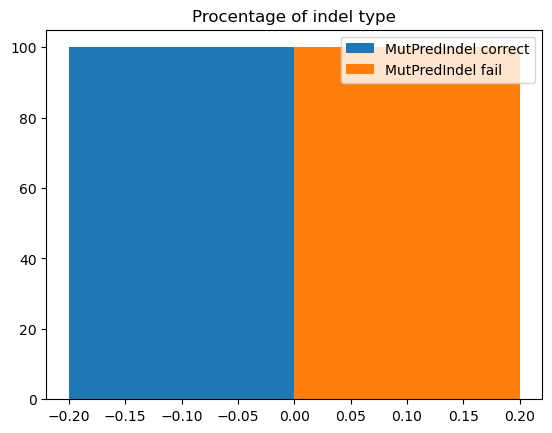

,MutPredIndelcorrect,MutPredIndelfail
length_indel,,
1,120,97
2,50,18
3,38,18
4,50,12
5,30,8
6,25,15
7,24,5
8,24,3
9,6,4


<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

([<matplotlib.axis.XTick at 0x741b330e8800>,
 [Text(0, 0, '1'), Text(1, 0, '2-4'), Text(2, 0, '5-10')])

Text(0.5, 1.0, 'Procentage of indel size')

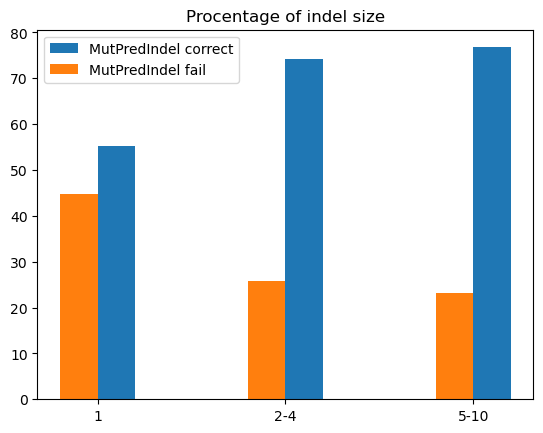

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

([<matplotlib.axis.XTick at 0x741b32e7ba10>,
 [Text(0, 0, '1-250'), Text(1, 0, '251-500')])

Text(0.5, 1.0, 'Procentage of wt aa length')

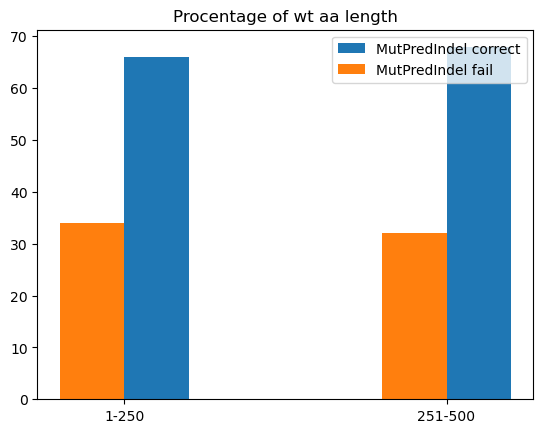

In [98]:
# See how MutPredIndel handles different types of indels and protein lengths
# Check which values the model calls correctly
filtered_MutPredIndel['correct'] = None 
filtered_MutPredIndel.loc[((filtered_MutPredIndel['MutPredIndel'] < tresh_MutPredIndel) & (filtered_MutPredIndel['labels_cleaned'] == 'Benign')) | 
        ((filtered_MutPredIndel['MutPredIndel'] >= tresh_MutPredIndel) & (filtered_MutPredIndel['labels_cleaned'] == 'Pathogenic')), 'correct'] = 'True'

#Dataframes with correcly called by both, failed by both, and what one manages and the other don't
MutPredIndelcorrect = filtered_MutPredIndel.loc[((filtered_MutPredIndel['correct'] == 'True'))]
MutPredIndelfail = filtered_MutPredIndel.loc[((filtered_MutPredIndel['correct'].isnull()))]

# Indel type 
MutPredIndelcorrect_indeltype = MutPredIndelcorrect['indel'].value_counts()
MutPredIndelfail_indeltype = MutPredIndelfail['indel'].value_counts()
indeltype = ('Deletion', 'Insertion')

plt.bar(np.arange(len(MutPredIndelcorrect_indeltype.index)) - 0.1 , ((MutPredIndelcorrect_indeltype.values / len(MutPredIndelcorrect)) * 100) , 0.2, label = 'MutPredIndel correct')
plt.bar(np.arange(len(MutPredIndelfail_indeltype.index)) + 0.1, ((MutPredIndelfail_indeltype.values / len(MutPredIndelfail)) * 100), 0.2, label = 'MutPredIndel fail')
plt.legend(loc = 'best')
plt.title('Procentage of indel type')
#plt.xticks(np.arange(len(MutPredIndelcorrect_indeltype)), indeltype)
plt.show()

# Indel size
MutPredIndelcorrect_indelsize = MutPredIndelcorrect['length_indel'].value_counts()
MutPredIndelfail_indelsize = MutPredIndelfail['length_indel'].value_counts()

indelsizeMutPredIndel = pd.DataFrame({
    'MutPredIndelcorrect': MutPredIndelcorrect_indelsize,
    'MutPredIndelfail': MutPredIndelfail_indelsize,
    }).fillna(0)

#Group the indel sizes after Cannon et al. 2023 ((0), 1, 2-4, 5-10 and 11+)

indelsizeMutPredIndel #Check that it conatins all types of indels

indels2to4MutPredIndel = indelsizeMutPredIndel.loc[2:4].sum()
indels5to10MutPredIndel = indelsizeMutPredIndel.loc[5:10].sum()

indelsizeMutPredIndel_grouped = pd.DataFrame({
    'Indel size': ['1', '2-4', '5-10'],
    'MutPredIndelcorrect': [indelsizeMutPredIndel.loc[1, 'MutPredIndelcorrect'], indels2to4MutPredIndel['MutPredIndelcorrect'], indels5to10MutPredIndel['MutPredIndelcorrect']],
    'MutPredIndelfail': [indelsizeMutPredIndel.loc[1, 'MutPredIndelfail'], indels2to4MutPredIndel['MutPredIndelfail'], indels5to10MutPredIndel['MutPredIndelfail']]
})

labels = ['1', '2-4', '5-10']

#Calculate procentage
indelsumMutPredIndel = indelsizeMutPredIndel_grouped[['MutPredIndelcorrect', 'MutPredIndelfail']].sum(axis=1)
percentageMutPredIndel = indelsizeMutPredIndel_grouped[['MutPredIndelcorrect', 'MutPredIndelfail']].div(indelsumMutPredIndel, axis=0) * 100
percentageMutPredIndel.insert(0, 'Indel size', indelsizeMutPredIndel_grouped['Indel size'])

plt.bar(np.arange(len(percentageMutPredIndel)) + 0.1, percentageMutPredIndel['MutPredIndelcorrect'], 0.2, label = 'MutPredIndel correct')
plt.bar(np.arange(len(percentageMutPredIndel)) - 0.1, percentageMutPredIndel['MutPredIndelfail'], 0.2, label = 'MutPredIndel fail')
plt.xticks(np.arange(len(percentageMutPredIndel)), labels)
plt.legend(loc = 'best')
plt.title('Procentage of indel size')
plt.show()

# Protein length 
MutPredIndelcorrect_aasize = MutPredIndelcorrect['length_wt'].value_counts()
MutPredIndelfail_aasize = MutPredIndelfail['length_wt'].value_counts()

MutPredIndelaasize = pd.DataFrame({
    'MutPredIndelcorrect': MutPredIndelcorrect_aasize,
    'MutPredIndelfail': MutPredIndelfail_aasize
}).fillna(0)

aaranges2 = [(0, 250), (251, 500)]

MutPredIndelsummarized_data = {
    'Range': [],
    'MutPredIndelcorrect': [],
    'MutPredIndelfail': []
}

for start, end in aaranges2:
    range_label = f'{start}-{end}'
    range_sum = MutPredIndelaasize.loc[start:end].sum()
    
    MutPredIndelsummarized_data['Range'].append(range_label)
    MutPredIndelsummarized_data['MutPredIndelcorrect'].append(range_sum['MutPredIndelcorrect'])
    MutPredIndelsummarized_data['MutPredIndelfail'].append(range_sum['MutPredIndelfail'])

# Creating a new DataFrame with the summarized values
MutPredIndelsummarized_df = pd.DataFrame(MutPredIndelsummarized_data)

labels2 = ['1-250', '251-500']

#Calculate procentage
sizesumMutPredIndel = MutPredIndelsummarized_df[['MutPredIndelcorrect', 'MutPredIndelfail']].sum(axis=1)
percentageMutPredIndelsize = MutPredIndelsummarized_df[['MutPredIndelcorrect', 'MutPredIndelfail']].div(sizesumMutPredIndel, axis=0) * 100
percentageMutPredIndelsize.insert(0, 'Range', MutPredIndelsummarized_df['Range'])

plt.bar(np.arange(len(percentageMutPredIndelsize)) + 0.1, percentageMutPredIndelsize['MutPredIndelcorrect'], 0.2, label = 'MutPredIndel correct')
plt.bar(np.arange(len(percentageMutPredIndelsize)) - 0.1, percentageMutPredIndelsize['MutPredIndelfail'], 0.2, label = 'MutPredIndel fail')
plt.xticks(np.arange(len(percentageMutPredIndelsize)), labels2)
plt.legend(loc = 'best')
plt.title('Procentage of wt aa length')
plt.show()

SIFT Indel: Hu et al. 2013 https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0077940

We construct a SIFT Indel prediction algorithm for 3n indels which achieves 82% accuracy, 81% sensitivity, 82% specificity, 82% precision, 0.63 MCC, and 0.87 AUC by 10-fold cross-validation.

The goal of this classifier is to predict if a 3n indel affects gene function (designated as “gene-damaging") or not (designated as “neutral”). The classifier for 3n indels was trained and tested on two datasets:

1. Indel Disease Set: Disease-causing indels were obtained from HGMD [2] version 2010.2. HGMD is a database of mutations found in affected patients, and these mutations are assumed to be gene-damaging. The original HGMD dataset contains 1,887 indels. We picked one indel per gene to be represented in the dataset to avoid over-training on genes that have many HGMD indel entries. After choosing one indel per gene and removing indels from non-exon regions and from genes with invalid/incomplete transcripts, 474 indels remained. The HGMD accession id’s of the 1,887 indels and 474 indels can be found in Data S1.
2. Neutral Indel Set: The set of neutral 3n indels were derived from pairwise alignments from the UCSC genome browser of human with cow, dog, horse, chimpanzee, rhesus macaque and rat [14]. After choosing one indel per gene and removing indels from non-exon regions and from genes with invalid/incomplete transcripts, there were 9,710 neutral indels. The locations of the neutral indels can be found in Data S1.

/tmp/ipykernel_3596441/4204821437.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_SIFT['SIFT-indel_bin'] = [ 1 if x == 'neutral' else 0 for x in filtered_SIFT['SIFT-indel']]


,key_0,Unnamed: 0,Id_matching,Protein_start,Protein_stop,Unnamed: 0_y,start-b38,stop-b38,CADD,CAPICE,...,evo_mut,evo_wt,fit_mut,fit_wt,length_indel,dif_evo,dif_fit,labels_binary,dif_best,SIFT-indel_bin
count,543.000000,543.000000,543.000000,543.000000,543.000000,0.0,5.430000e+02,5.430000e+02,543.000000,542.000000,...,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000
mean,2023.867403,1954.751381,2023.867403,176.001842,179.046041,NaN,7.133444e+07,7.133445e+07,16.754164,0.380518,...,289.592663,294.264513,116.907064,120.206686,3.246777,-4.671851,-3.299622,0.478821,-4.291250,0.397790
std,1138.788599,1096.155048,1138.788599,114.186833,114.155748,NaN,5.925196e+07,5.925196e+07,5.197632,0.398223,...,79.895400,80.083642,60.701158,61.846626,2.515975,3.514518,4.343269,0.500012,4.714063,0.489893
min,1.000000,1.000000,1.000000,2.000000,4.000000,NaN,4.886900e+04,4.889000e+04,0.514000,0.000007,...,38.754637,40.831130,9.631793,8.818169,1.000000,-22.946907,-40.365060,0.000000,-40.365060,0.000000
25%,1117.500000,1083.500000,1117.500000,76.500000,80.000000,NaN,2.655475e+07,2.655476e+07,14.465000,0.007033,...,240.334693,245.327420,67.071429,67.848865,1.000000,-6.423613,-4.888967,0.000000,-6.089629,0.000000
50%,1978.000000,1919.000000,1978.000000,167.000000,169.000000,NaN,5.412250e+07,5.412251e+07,18.040000,0.196867,...,297.794057,302.642515,102.334915,104.487100,2.000000,-3.846082,-2.434237,0.000000,-3.232312,0.000000
75%,2955.500000,2852.500000,2955.500000,249.500000,254.000000,NaN,1.083925e+08,1.083925e+08,20.800000,0.825644,...,355.212512,359.729798,161.374989,165.505995,5.000000,-1.979936,-0.648574,1.000000,-1.049804,1.000000
max,3958.000000,3814.000000,3958.000000,478.000000,479.000000,NaN,2.478960e+08,2.478961e+08,24.800000,0.999197,...,449.243205,450.935780,296.511972,302.809842,10.000000,0.187187,4.589211,1.000000,4.110325,1.000000


Text(0.5, 1.0, 'SIFT predictor results')

<Axes: title={'center': 'SIFT predictor results'}, xlabel='labels_cleaned', ylabel='SIFT-indel_bin'>

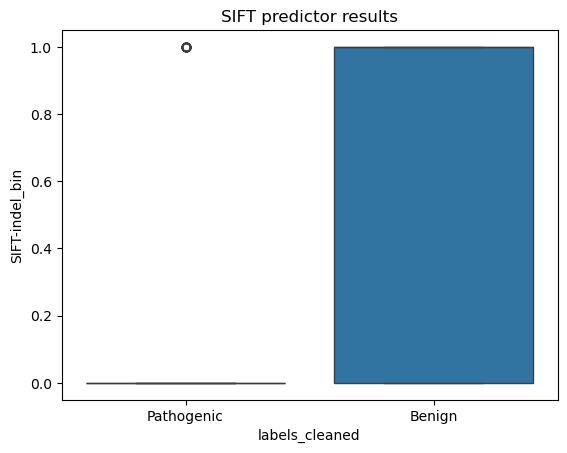

F1 score Combined/IndeLLM best small indels: 0.8057040998217468
F1 score SIFT small indels: 0.7647058823529411
Accuracy score Combined/IndeLLM best small indels: 0.8070796460176991
Accuracy score SIFT small indels: 0.7937384898710865
MCC Combined/IndeLLM best small indels: 0.614185465395214
MCC SIFT small indels: 0.5918358727527373


Text(0.5, 0, 'False Positives (Specificty)')

Text(0, 0.5, 'Trule Positives (Sensitivity)')

Text(0.5, 1.0, 'ROC Curve for our predictions')

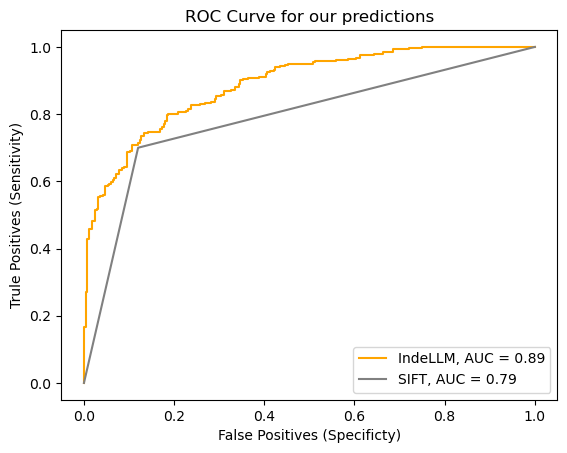

In [47]:
filtered_SIFT = keptlabels.dropna(subset=['SIFT-indel'])
filtered_SIFT['SIFT-indel_bin'] = [ 1 if x == 'neutral' else 0 for x in filtered_SIFT['SIFT-indel']]
pred_SIFT = filtered_SIFT['SIFT-indel_bin'].values
truelabels_SIFT = filtered_SIFT['labels_binary'].values

filtered_SIFT.describe()

#Boxplot of SIFT
plt.title('SIFT predictor results')
sns.boxplot(x = filtered_SIFT['labels_cleaned'], y = filtered_SIFT['SIFT-indel_bin'])
plt.show()

#Calculating FP, TN and thresholds
fpr_SIFT, tpr_SIFT, thersholds_SIFT = metrics.roc_curve(truelabels_SIFT, pred_SIFT)
roc_auc_SIFT = round(metrics.auc(fpr_SIFT, tpr_SIFT), 2)

#Calculating F1 score
tresh_SIFT = thersholds_SIFT[np.argmax(tpr_SIFT - fpr_SIFT)]
f1_SIFT = f1_score(truelabels_SIFT, pred_SIFT, average = 'binary')

#Calculating accuary score
accuracy_SIFT = accuracy_score(truelabels_SIFT, pred_SIFT)

#Calculating MCC
mcc_SIFT = matthews_corrcoef(truelabels_SIFT, pred_SIFT)

print("F1 score Combined/IndeLLM best small indels:", f1_best)
print("F1 score SIFT small indels:", f1_SIFT)

print("Accuracy score Combined/IndeLLM best small indels:", accuracy_best)
print("Accuracy score SIFT small indels:", accuracy_SIFT)

print("MCC Combined/IndeLLM best small indels:", mcc_best)
print("MCC SIFT small indels:", mcc_SIFT)

#Plotting the Evo, Fit and SIFT AUC 
plt.plot(fpr_best, tpr_best, label = "IndeLLM, AUC = "+str(roc_auc_best), color = "orange")
plt.plot(fpr_SIFT, tpr_SIFT, label = "SIFT, AUC = "+str(roc_auc_SIFT), color = "grey")
plt.xlabel('False Positives (Specificty)')
plt.ylabel('Trule Positives (Sensitivity)')
plt.title("ROC Curve for our predictions")
plt.legend(loc = 'best')
plt.show()

/tmp/ipykernel_3596441/109610668.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_SIFT['correct'] = None


<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

Text(0.5, 1.0, 'Procentage of indel type')

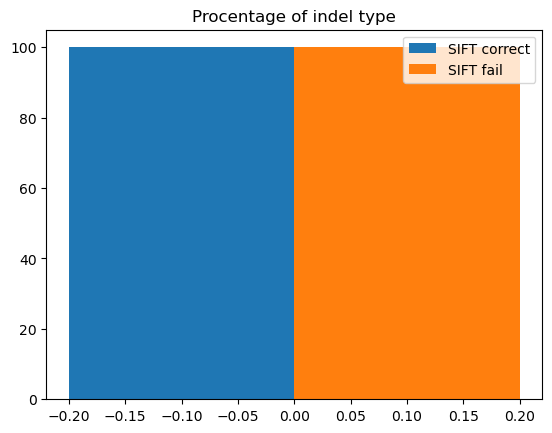

,SIFTcorrect,SIFTfail
length_indel,,
1,150,64
2,25,41
3,32,21
4,18,40
5,20,18
6,16,24
7,11,17
8,6,19
9,4,6


<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

([<matplotlib.axis.XTick at 0x741b33c32ea0>,
 [Text(0, 0, '1'), Text(1, 0, '2-4'), Text(2, 0, '5-10')])

Text(0.5, 1.0, 'Procentage of indel size')

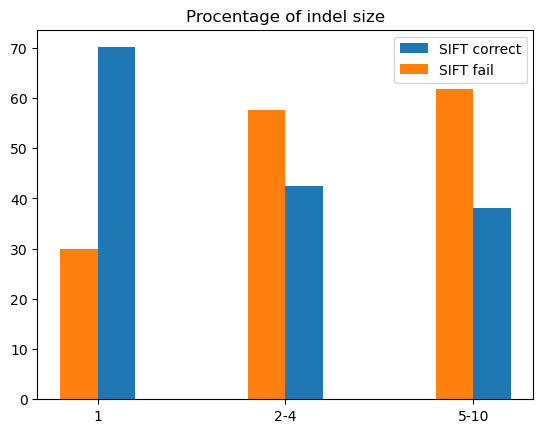

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

([<matplotlib.axis.XTick at 0x741b39f76000>,
 [Text(0, 0, '1-250'), Text(1, 0, '251-500')])

Text(0.5, 1.0, 'Procentage of wt aa length')

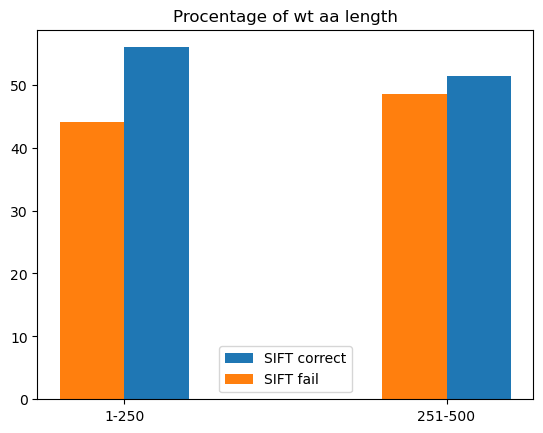

In [99]:
# See how SIFT handles different types of indels and protein lengths
# Check which values the model calls correctly
filtered_SIFT['correct'] = None 
filtered_SIFT.loc[((filtered_SIFT['SIFT-indel_bin'] > tresh_SIFT) & (filtered_SIFT['labels_cleaned'] == 'Benign')) | 
        ((filtered_SIFT['SIFT-indel_bin'] <= tresh_SIFT) & (filtered_SIFT['labels_cleaned'] == 'Pathogenic')), 'correct'] = 'True'

#Dataframes with correcly called by both, failed by both, and what one manages and the other don't
SIFTcorrect = filtered_SIFT.loc[((filtered_SIFT['correct'] == 'True'))]
SIFTfail = filtered_SIFT.loc[((filtered_SIFT['correct'].isnull()))]

# Indel type 
SIFTcorrect_indeltype = SIFTcorrect['indel'].value_counts()
SIFTfail_indeltype = SIFTfail['indel'].value_counts()
indeltype = ('Deletion', 'Insertion')

plt.bar(np.arange(len(SIFTcorrect_indeltype.index)) - 0.1 , ((SIFTcorrect_indeltype.values / len(SIFTcorrect)) * 100) , 0.2, label = 'SIFT correct')
plt.bar(np.arange(len(SIFTfail_indeltype.index)) + 0.1, ((SIFTfail_indeltype.values / len(SIFTfail)) * 100), 0.2, label = 'SIFT fail')
plt.legend(loc = 'best')
plt.title('Procentage of indel type')
#plt.xticks(np.arange(len(SIFTcorrect_indeltype)), indeltype)
plt.show()

# Indel size
SIFTcorrect_indelsize = SIFTcorrect['length_indel'].value_counts()
SIFTfail_indelsize = SIFTfail['length_indel'].value_counts()

indelsizeSIFT = pd.DataFrame({
    'SIFTcorrect': SIFTcorrect_indelsize,
    'SIFTfail': SIFTfail_indelsize,
    }).fillna(0)

#Group the indel sizes after Cannon et al. 2023 ((0), 1, 2-4, 5-10 and 11+)

indelsizeSIFT #Check that it conatins all types of indels

indels2to4SIFT = indelsizeSIFT.loc[2:4].sum()
indels5to10SIFT = indelsizeSIFT.loc[5:10].sum()

indelsizeSIFT_grouped = pd.DataFrame({
    'Indel size': ['1', '2-4', '5-10'],
    'SIFTcorrect': [indelsizeSIFT.loc[1, 'SIFTcorrect'], indels2to4SIFT['SIFTcorrect'], indels5to10SIFT['SIFTcorrect']],
    'SIFTfail': [indelsizeSIFT.loc[1, 'SIFTfail'], indels2to4SIFT['SIFTfail'], indels5to10SIFT['SIFTfail']]
})

labels = ['1', '2-4', '5-10']

#Calculate procentage
indelsumSIFT = indelsizeSIFT_grouped[['SIFTcorrect', 'SIFTfail']].sum(axis=1)
percentageSIFT = indelsizeSIFT_grouped[['SIFTcorrect', 'SIFTfail']].div(indelsumSIFT, axis=0) * 100
percentageSIFT.insert(0, 'Indel size', indelsizeSIFT_grouped['Indel size'])

plt.bar(np.arange(len(percentageSIFT)) + 0.1, percentageSIFT['SIFTcorrect'], 0.2, label = 'SIFT correct')
plt.bar(np.arange(len(percentageSIFT)) - 0.1, percentageSIFT['SIFTfail'], 0.2, label = 'SIFT fail')
plt.xticks(np.arange(len(percentageSIFT)), labels)
plt.legend(loc = 'best')
plt.title('Procentage of indel size')
plt.show()

# Protein length 
SIFTcorrect_aasize = SIFTcorrect['length_wt'].value_counts()
SIFTfail_aasize = SIFTfail['length_wt'].value_counts()

SIFTaasize = pd.DataFrame({
    'SIFTcorrect': SIFTcorrect_aasize,
    'SIFTfail': SIFTfail_aasize
}).fillna(0)

aaranges2 = [(0, 250), (251, 500)]

SIFTsummarized_data = {
    'Range': [],
    'SIFTcorrect': [],
    'SIFTfail': []
}

for start, end in aaranges2:
    range_label = f'{start}-{end}'
    range_sum = SIFTaasize.loc[start:end].sum()
    
    SIFTsummarized_data['Range'].append(range_label)
    SIFTsummarized_data['SIFTcorrect'].append(range_sum['SIFTcorrect'])
    SIFTsummarized_data['SIFTfail'].append(range_sum['SIFTfail'])

# Creating a new DataFrame with the summarized values
SIFTsummarized_df = pd.DataFrame(SIFTsummarized_data)

labels2 = ['1-250', '251-500']

#Calculate procentage
sizesumSIFT = SIFTsummarized_df[['SIFTcorrect', 'SIFTfail']].sum(axis=1)
percentageSIFTsize = SIFTsummarized_df[['SIFTcorrect', 'SIFTfail']].div(sizesumSIFT, axis=0) * 100
percentageSIFTsize.insert(0, 'Range', SIFTsummarized_df['Range'])

plt.bar(np.arange(len(percentageSIFTsize)) + 0.1, percentageSIFTsize['SIFTcorrect'], 0.2, label = 'SIFT correct')
plt.bar(np.arange(len(percentageSIFTsize)) - 0.1, percentageSIFTsize['SIFTfail'], 0.2, label = 'SIFT fail')
plt.xticks(np.arange(len(percentageSIFTsize)), labels2)
plt.legend(loc = 'best')
plt.title('Procentage of wt aa length')
plt.show()

The VAAST Variant Prioritizer (VVP): Flygare et al. 2018 https://link.springer.com/article/10.1186/s12859-018-2056-y

The VAAST [13] Variant Prioritizer (VVP) can assign a prioritization score to any type of sequence variant, located anywhere in the genome. To do so, VVP leverages the same Composite Likelihood Ratio Test (CLRT) used by VAAST [13] and its derivatives, VAAST 2.0 [14] and pVAAST [15]. Whereas those tools use the CLRT to score genes to perform burden-based association testing in case-control and family based analyses [2, 16], VVP reports scores for individual variants, and is designed for very large-scale variant prioritization activities. Run times are a major motivation for the VVP project, which is why VVP is written entirely in C, including the VCF parser. All of these factors combine to allow VVP to score every variant in a typical WGS in less than 5 min using a computer with just 4 cpus and 16 GB of RAM.

,key_0,Unnamed: 0,Id_matching,Protein_start,Protein_stop,Unnamed: 0_y,start-b38,stop-b38,CADD,CAPICE,...,length_wt,evo_mut,evo_wt,fit_mut,fit_wt,length_indel,dif_evo,dif_fit,labels_binary,dif_best
count,564.000000,564.000000,564.000000,564.000000,564.000000,0.0,5.640000e+02,5.640000e+02,564.000000,564.000000,...,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000
mean,2006.065603,1937.565603,2006.065603,172.716312,175.735816,NaN,7.321077e+07,7.321078e+07,16.523649,0.366165,...,349.641844,284.987572,289.586181,115.307409,118.512819,3.234043,-4.598609,-3.205410,0.498227,-4.155918
std,1140.178189,1097.577787,1140.178189,114.754635,114.722243,NaN,6.133595e+07,6.133595e+07,5.368253,0.396877,...,100.710034,83.494830,83.749666,61.384213,62.505367,2.507929,3.504323,4.302545,0.500441,4.689655
min,1.000000,1.000000,1.000000,2.000000,4.000000,NaN,4.744600e+04,4.745500e+04,0.314000,0.000004,...,65.000000,38.754637,40.831130,9.631793,8.818169,1.000000,-22.946907,-40.365060,0.000000,-40.365060
25%,1074.250000,1041.500000,1074.250000,71.750000,74.750000,NaN,2.697815e+07,2.697815e+07,14.047500,0.005455,...,292.000000,235.927701,242.040013,66.944327,67.846952,1.000000,-6.339578,-4.790896,0.000000,-5.972709
50%,1951.500000,1892.500000,1951.500000,163.000000,166.000000,NaN,5.522155e+07,5.522156e+07,17.920000,0.167458,...,362.000000,294.381903,300.911272,100.657185,104.329131,2.000000,-3.801312,-2.306992,0.000000,-3.098360
75%,2954.250000,2851.250000,2954.250000,247.000000,252.000000,NaN,1.126934e+08,1.126934e+08,20.700000,0.804639,...,430.500000,351.911342,356.185876,160.270481,164.083036,5.000000,-1.942173,-0.546284,1.000000,-0.917722
max,3958.000000,3814.000000,3958.000000,478.000000,479.000000,NaN,2.482950e+08,2.482951e+08,24.800000,0.999197,...,500.000000,449.243205,450.935780,296.511972,302.809842,10.000000,1.577955,4.589211,1.000000,4.110325


Text(0.5, 1.0, 'VVP predictor results')

<Axes: title={'center': 'VVP predictor results'}, xlabel='labels_cleaned', ylabel='VVP'>

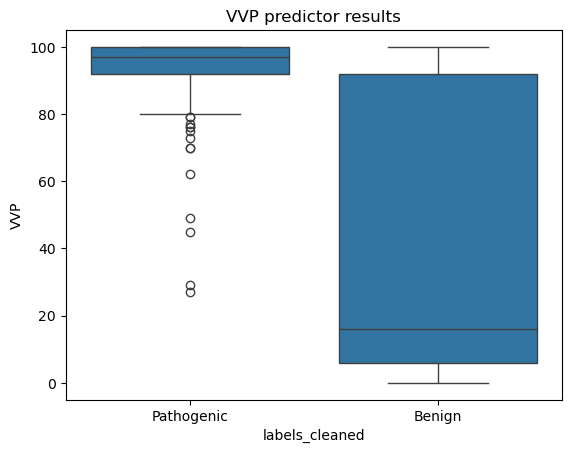

F1 score Combined/IndeLLM best small indels: 0.8057040998217468
F1 score VVP small indels: 0.8522550544323484
Accuracy score Combined/IndeLLM best small indels: 0.8070796460176991
Accuracy score VVP small indels: 0.8315602836879432
MCC Combined/IndeLLM best small indels: 0.614185465395214
MCC VVP small indels: 0.6890252750615501


Text(0.5, 0, 'False Positives (Specificty)')

Text(0, 0.5, 'Trule Positives (Sensitivity)')

Text(0.5, 1.0, 'ROC Curve for our predictions')

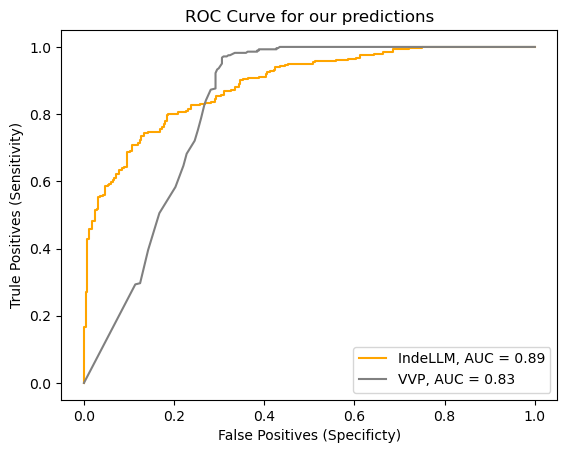

In [50]:
#Some of the columns in VVP contain no prediction, so filer the dataset
keptlabels['VVP'] = pd.to_numeric(keptlabels['VVP'], errors='coerce')
filtered_VVP = keptlabels.dropna(subset=['VVP'])
pred_VVP = filtered_VVP['VVP'].values
truelabels_VVP = filtered_VVP['labels_binary'].values

filtered_VVP.describe()

#Boxplot of VVP
plt.title('VVP predictor results')
sns.boxplot(x = filtered_VVP['labels_cleaned'], y = filtered_VVP['VVP'])
plt.show()

#The VVP predicts benig as 0, while pathogenic as 1. So have to change 0 to 1 and 1 to 0
truelabels_VVP -= 1
truelabels_VVP = np.abs(truelabels_VVP) 

#Calculating FP, TN and thresholds
fpr_VVP, tpr_VVP, thersholds_VVP = metrics.roc_curve(truelabels_VVP, pred_VVP)
roc_auc_VVP = round(metrics.auc(fpr_VVP, tpr_VVP), 2)

#Calculating F1 score
tresh_VVP = thersholds_VVP[np.argmax(tpr_VVP - fpr_VVP)]
pred_VVP_bin = [1 if x >= tresh_VVP else 0 for x in pred_VVP]
f1_VVP = f1_score(truelabels_VVP, pred_VVP_bin, average = 'binary')

#Calculating accuary score
accuracy_VVP = accuracy_score(truelabels_VVP, pred_VVP_bin)

#Calculating MCC
mcc_VVP = matthews_corrcoef(truelabels_VVP, pred_VVP_bin)

print("F1 score Combined/IndeLLM best small indels:", f1_best)
print("F1 score VVP small indels:", f1_VVP)

print("Accuracy score Combined/IndeLLM best small indels:", accuracy_best)
print("Accuracy score VVP small indels:", accuracy_VVP)

print("MCC Combined/IndeLLM best small indels:", mcc_best)
print("MCC VVP small indels:", mcc_VVP)

#Plotting the Evo, Fit and VVP AUC 
plt.plot(fpr_best, tpr_best, label = "IndeLLM, AUC = "+str(roc_auc_best), color = "orange")
plt.plot(fpr_VVP, tpr_VVP, label = "VVP, AUC = "+str(roc_auc_VVP), color = "grey")
plt.xlabel('False Positives (Specificty)')
plt.ylabel('Trule Positives (Sensitivity)')
plt.title("ROC Curve for our predictions")
plt.legend(loc = 'best')
plt.show()

/tmp/ipykernel_3596441/910707197.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_VVP['correct'] = None


<BarContainer object of 1 artists>

<BarContainer object of 1 artists>

Text(0.5, 1.0, 'Procentage of indel type')

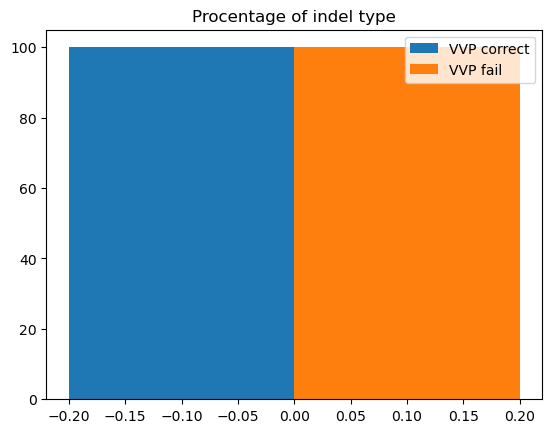

,VVPcorrect,VVPfail
length_indel,,
1,202,21
2,56,12
3,49,7
4,44,18
5,33,5
6,27,13
7,27,2
8,16,11
9,6,4


<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

([<matplotlib.axis.XTick at 0x741b394c3920>,
 [Text(0, 0, '1'), Text(1, 0, '2-4'), Text(2, 0, '5-10')])

Text(0.5, 1.0, 'Procentage of indel size')

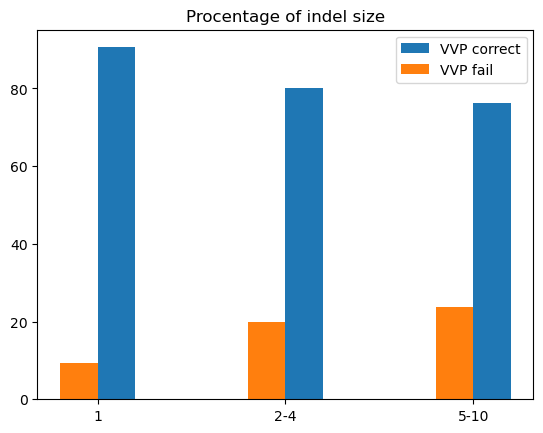

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

([<matplotlib.axis.XTick at 0x741b3920df10>,
 [Text(0, 0, '1-250'), Text(1, 0, '251-500')])

Text(0.5, 1.0, 'Procentage of wt aa length')

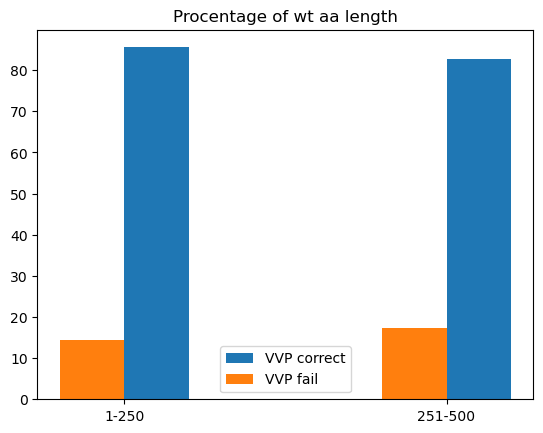

In [100]:
# See how VVP handles different types of indels and protein lengths
# Check which values the model calls correctly
filtered_VVP['correct'] = None 
filtered_VVP.loc[((filtered_VVP['VVP'] < tresh_VVP) & (filtered_VVP['labels_cleaned'] == 'Benign')) | 
        ((filtered_VVP['VVP'] >= tresh_VVP) & (filtered_VVP['labels_cleaned'] == 'Pathogenic')), 'correct'] = 'True'

#Dataframes with correcly called by both, failed by both, and what one manages and the other don't
VVPcorrect = filtered_VVP.loc[((filtered_VVP['correct'] == 'True'))]
VVPfail = filtered_VVP.loc[((filtered_VVP['correct'].isnull()))]

# Indel type 
VVPcorrect_indeltype = VVPcorrect['indel'].value_counts()
VVPfail_indeltype = VVPfail['indel'].value_counts()
indeltype = ('Deletion', 'Insertion')

plt.bar(np.arange(len(VVPcorrect_indeltype.index)) - 0.1 , ((VVPcorrect_indeltype.values / len(VVPcorrect)) * 100) , 0.2, label = 'VVP correct')
plt.bar(np.arange(len(VVPfail_indeltype.index)) + 0.1, ((VVPfail_indeltype.values / len(VVPfail)) * 100), 0.2, label = 'VVP fail')
plt.legend(loc = 'best')
plt.title('Procentage of indel type')
#plt.xticks(np.arange(len(VVPcorrect_indeltype)), indeltype)
plt.show()

# Indel size
VVPcorrect_indelsize = VVPcorrect['length_indel'].value_counts()
VVPfail_indelsize = VVPfail['length_indel'].value_counts()

indelsizeVVP = pd.DataFrame({
    'VVPcorrect': VVPcorrect_indelsize,
    'VVPfail': VVPfail_indelsize,
    }).fillna(0)

#Group the indel sizes after Cannon et al. 2023 ((0), 1, 2-4, 5-10 and 11+)

indelsizeVVP #Check that it conatins all types of indels

indels2to4VVP = indelsizeVVP.loc[2:4].sum()
indels5to10VVP = indelsizeVVP.loc[5:10].sum()

indelsizeVVP_grouped = pd.DataFrame({
    'Indel size': ['1', '2-4', '5-10'],
    'VVPcorrect': [indelsizeVVP.loc[1, 'VVPcorrect'], indels2to4VVP['VVPcorrect'], indels5to10VVP['VVPcorrect']],
    'VVPfail': [indelsizeVVP.loc[1, 'VVPfail'], indels2to4VVP['VVPfail'], indels5to10VVP['VVPfail']]
})

labels = ['1', '2-4', '5-10']

#Calculate procentage
indelsumVVP = indelsizeVVP_grouped[['VVPcorrect', 'VVPfail']].sum(axis=1)
percentageVVP = indelsizeVVP_grouped[['VVPcorrect', 'VVPfail']].div(indelsumVVP, axis=0) * 100
percentageVVP.insert(0, 'Indel size', indelsizeVVP_grouped['Indel size'])

plt.bar(np.arange(len(percentageVVP)) + 0.1, percentageVVP['VVPcorrect'], 0.2, label = 'VVP correct')
plt.bar(np.arange(len(percentageVVP)) - 0.1, percentageVVP['VVPfail'], 0.2, label = 'VVP fail')
plt.xticks(np.arange(len(percentageVVP)), labels)
plt.legend(loc = 'best')
plt.title('Procentage of indel size')
plt.show()

# Protein length 
VVPcorrect_aasize = VVPcorrect['length_wt'].value_counts()
VVPfail_aasize = VVPfail['length_wt'].value_counts()

VVPaasize = pd.DataFrame({
    'VVPcorrect': VVPcorrect_aasize,
    'VVPfail': VVPfail_aasize
}).fillna(0)

aaranges2 = [(0, 250), (251, 500)]

VVPsummarized_data = {
    'Range': [],
    'VVPcorrect': [],
    'VVPfail': []
}

for start, end in aaranges2:
    range_label = f'{start}-{end}'
    range_sum = VVPaasize.loc[start:end].sum()
    
    VVPsummarized_data['Range'].append(range_label)
    VVPsummarized_data['VVPcorrect'].append(range_sum['VVPcorrect'])
    VVPsummarized_data['VVPfail'].append(range_sum['VVPfail'])

# Creating a new DataFrame with the summarized values
VVPsummarized_df = pd.DataFrame(VVPsummarized_data)

labels2 = ['1-250', '251-500']

#Calculate procentage
sizesumVVP = VVPsummarized_df[['VVPcorrect', 'VVPfail']].sum(axis=1)
percentageVVPsize = VVPsummarized_df[['VVPcorrect', 'VVPfail']].div(sizesumVVP, axis=0) * 100
percentageVVPsize.insert(0, 'Range', VVPsummarized_df['Range'])

plt.bar(np.arange(len(percentageVVPsize)) + 0.1, percentageVVPsize['VVPcorrect'], 0.2, label = 'VVP correct')
plt.bar(np.arange(len(percentageVVPsize)) - 0.1, percentageVVPsize['VVPfail'], 0.2, label = 'VVP fail')
plt.xticks(np.arange(len(percentageVVPsize)), labels2)
plt.legend(loc = 'best')
plt.title('Procentage of wt aa length')
plt.show()

<BarContainer object of 13 artists>

<BarContainer object of 13 artists>

<BarContainer object of 13 artists>

<BarContainer object of 13 artists>

([<matplotlib.axis.XTick at 0x741b3a7704d0>,
 [Text(0, 0, 'Evo (n = 565)'),
  Text(1, 0, 'Fit (n = 565)'),
  Text(2, 0, 'IndeLLM mean (n = 565)'),
  Text(3, 0, 'IndeLLM best (n = 565)'),
  Text(4, 0, 'CADD (n = 565)'),
  Text(5, 0, 'CAPICE (n = 564)'),
  Text(6, 0, 'PROVEAN (n = 507)'),
  Text(7, 0, 'FATHMM (n = 560)'),
  Text(8, 0, 'MutT2021 (n = 533)'),
  Text(9, 0, 'MutPred (n = 558)'),
  Text(10, 0, 'SIFT (n = 543)'),
  Text(11, 0, 'VEST (n = 545)'),
  Text(12, 0, 'VVP (n = 564)')])

Text(0.5, 1.0, 'F1 and ROC score between methods')

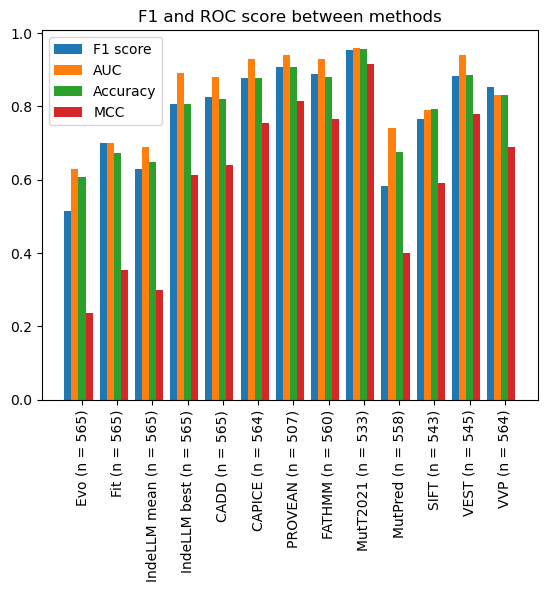

In [101]:
#Plotting the F1, ROC, accuracy and MCC scores together

F1 = pd.DataFrame({'Method': ['Evo', 'Fit', 'IndeLLM mean', 'IndeLLM best', 'CADD', 'CAPICE', 'PROVEAN', 'FATHMM', 'MutT2021', 'MutPred', 'SIFT', 'VEST', 'VVP'], 
      'F1 Score': [f1_evo, f1_fit, f1_combined, f1_best, f1_CADD, f1_CAPICE, f1_PROVEAN, f1_FATHMM, f1_MutationTaster2021, f1_MutPredIndel, f1_SIFT, f1_VEST, f1_VVP], 
      'ROC': [roc_auc_evo, roc_auc_fit, roc_auc_combined, roc_auc_best, roc_auc_CADD, roc_auc_CAPICE, roc_auc_PROVEAN, roc_auc_FATHMM, roc_auc_MutationTaster2021, roc_auc_MutPredIndel, roc_auc_SIFT, roc_auc_VEST, roc_auc_VVP], 
      'Sample size': [len(pred_evo), len(pred_fit), len(pred_combined), len(pred_best), len(pred_CADD),len(pred_CAPICE), len(pred_PROVEAN), len(pred_FATHMM), len(pred_MutationTaster2021), len(pred_MutPredIndel), len(pred_SIFT), len(pred_VEST), len(pred_VVP)], 
      'Accuracy': [accuracy_evo, accuracy_fit, accuracy_combined, accuracy_best, accuracy_CADD, accuracy_CAPICE, accuracy_PROVEAN, accuracy_FATHMM, accuracy_MutationTaster2021, accuracy_MutPredIndel, accuracy_SIFT, accuracy_VEST, accuracy_VVP], 
      'MCC': [mcc_evo, mcc_fit, mcc_combined, mcc_best, mcc_CADD, mcc_CAPICE, mcc_PROVEAN, mcc_FATHMM, mcc_MutationTaster2021, mcc_MutPredIndel, mcc_SIFT, mcc_VEST, mcc_VVP]})


labels = [f"{method} (n = {sample_size})" for method, sample_size in zip(F1['Method'], F1['Sample size'])]

plt.bar(np.arange(len(F1)) - 0.4, F1['F1 Score'], 0.2, label = 'F1 score')
plt.bar(np.arange(len(F1)) - 0.2, F1['ROC'], 0.2, label = 'AUC')
plt.bar(np.arange(len(F1)) , F1['Accuracy'], 0.2, label = 'Accuracy')
plt.bar(np.arange(len(F1)) + 0.2, F1['MCC'], 0.2, label = 'MCC')
plt.xticks(np.arange(len(F1)), labels, rotation=90)
plt.title('F1 and ROC score between methods')
plt.legend(loc = 'best')
plt.show()


In [53]:
#Plotting the indel type

Indeltype_Correctly = pd.DataFrame({'Method': ['Evo', 'Fit', 'CADD', 'CAPICE', 'PROVEAN', 'FATHMM', 'MutT2021', 'MutPred', 'SIFT', 'VEST', 'VVP'], 
      'Indel type deletion': [Evocorrect_indeltype['deletion'], Fitcorrect_indeltype['deletion'], CADDcorrect_indeltype['deletion'], CAPICEcorrect_indeltype['deletion'], PROVEANcorrect_indeltype['deletion'], FATHMMcorrect_indeltype['deletion'], MutationTaster2021correct_indeltype['deletion'], MutPredIndelcorrect_indeltype['deletion'], SIFTcorrect_indeltype['deletion'], VESTcorrect_indeltype['deletion'], VVPcorrect_indeltype['deletion']], 
      'Indel type insertion': [Evocorrect_indeltype['insertion'], Fitcorrect_indeltype['insertion'], CADDcorrect_indeltype['insertion'], CAPICEcorrect_indeltype['insertion'], PROVEANcorrect_indeltype['insertion'], FATHMMcorrect_indeltype['insertion'], MutationTaster2021correct_indeltype['insertion'], MutPredIndelcorrect_indeltype['insertion'], SIFTcorrect_indeltype['insertion'], VESTcorrect_indeltype['insertion'], VVPcorrect_indeltype['insertion']], 
      'Sample size': [len(Evocorrect), len(Fitcorrect), len(CADDcorrect), len(CAPICEcorrect), len(PROVEANcorrect), len(FATHMMcorrect), len(MutationTaster2021correct), len(MutPredIndelcorrect), len(SIFTcorrect), len(VESTcorrect), len(VVPcorrect)]})


Indeltype_Failed = pd.DataFrame({'Method': ['Evo', 'Fit', 'CADD', 'CAPICE', 'PROVEAN', 'FATHMM', 'MutT2021', 'MutPred', 'SIFT', 'VEST', 'VVP'], 
      'Indel type deletion': [Evofail_indeltype['deletion'], Fitfail_indeltype['deletion'], CADDfail_indeltype['deletion'], CAPICEfail_indeltype['deletion'], PROVEANfail_indeltype['deletion'], FATHMMfail_indeltype['deletion'], MutationTaster2021fail_indeltype['deletion'], MutPredIndelfail_indeltype['deletion'], SIFTfail_indeltype['deletion'], VESTfail_indeltype['deletion'], VVPfail_indeltype['deletion']], 
      'Indel type insertion': [Evofail_indeltype['insertion'], Fitfail_indeltype['insertion'], CADDfail_indeltype['insertion'], CAPICEfail_indeltype['insertion'], PROVEANfail_indeltype['insertion'], FATHMMfail_indeltype['insertion'], MutationTaster2021fail_indeltype['insertion'], MutPredIndelfail_indeltype['insertion'], SIFTfail_indeltype['insertion'], VESTfail_indeltype['insertion'], VVPfail_indeltype['insertion']], 
      'Sample size': [len(Evofail), len(Fitfail), len(CADDfail), len(CAPICEfail), len(PROVEANfail), len(FATHMMfail), len(MutationTaster2021fail), len(MutPredIndelfail), len(SIFTfail), len(VESTfail), len(VVPfail)]})


labels4 = list(Indeltype_Correctly['Method'])

plt.bar(np.arange(len(Indeltype_Correctly)) -0.1, Indeltype_Correctly['Indel type deletion'], 0.2, label = 'Deletions')
plt.bar(np.arange(len(Indeltype_Correctly)) + 0.1, Indeltype_Correctly['Indel type insertion'], 0.2, label = 'Insertion')
plt.xticks(np.arange(len(Indeltype_Correctly)), labels4, rotation=90)
plt.title('Indel types between methods, Correctly called')
plt.legend(loc = 'best')
plt.show()

plt.bar(np.arange(len(Indeltype_Failed)) -0.1, Indeltype_Failed['Indel type deletion'], 0.2, label = 'Deletions')
plt.bar(np.arange(len(Indeltype_Failed)) + 0.1, Indeltype_Failed['Indel type insertion'], 0.2, label = 'Insertion')
plt.xticks(np.arange(len(Indeltype_Failed)), labels4, rotation=90)
plt.title('Indel types between methods, Failed called')
plt.legend(loc = 'best')
plt.show()

KeyError: 'insertion'

['1', '2-4', '5-10']

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

([<matplotlib.axis.XTick at 0x741b3250aed0>,
 [Text(0, 0, '1'), Text(1, 0, '2-4'), Text(2, 0, '5-10')])

Text(0.5, 1.0, 'Indel sizes between methods, Correctly called')

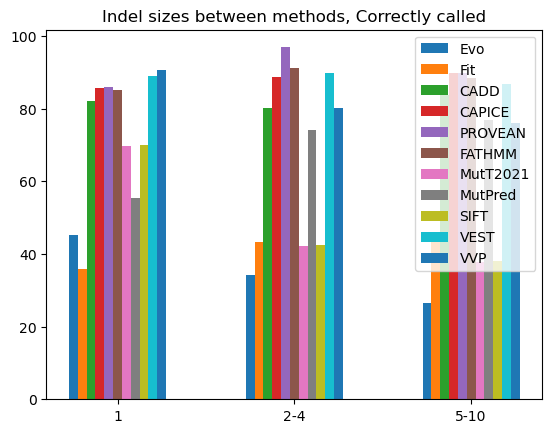

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

<BarContainer object of 3 artists>

([<matplotlib.axis.XTick at 0x741b327d7920>,
 [Text(0, 0, '1'), Text(1, 0, '2-4'), Text(2, 0, '5-10')])

Text(0.5, 1.0, 'Indel sizes between methods, failed')

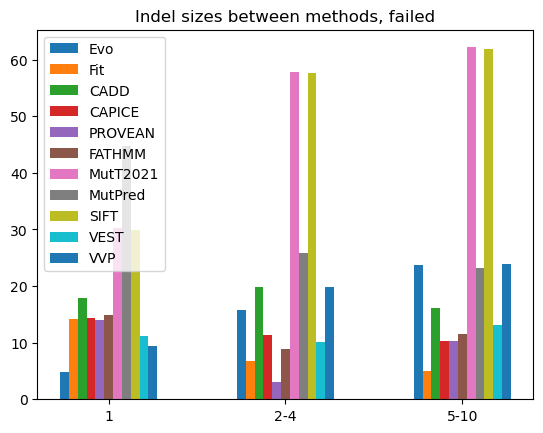

In [106]:
#Plotting correclty and failed calls of indels sizes of all methods

allindelsizes1 = percentageCADD.merge(percentageCAPICE, how = 'inner', on = 'Indel size')
allindelsizes2 = allindelsizes1.merge(percentagePROVEAN, how = 'inner', on = 'Indel size')
allindelsizes3 = allindelsizes2.merge(percentageFATHMM, how = 'inner', on = 'Indel size')
allindelsizes4 = allindelsizes3.merge(percentageMutationTaster2021, how = 'inner', on = 'Indel size')
allindelsizes5 = allindelsizes4.merge(percentageMutPredIndel, how = 'inner', on = 'Indel size')
allindelsizes6 = allindelsizes5.merge(percentageSIFT, how = 'inner', on = 'Indel size')
allindelsizes7 = allindelsizes6.merge(percentageVEST, how = 'inner', on = 'Indel size')
allindelsizes8 = allindelsizes7.merge(percentageVVP, how = 'inner', on = 'Indel size')
allindelsizes_grouped = allindelsizes8.merge(percentage2, how = 'inner', on = 'Indel size')

labels3 = list(allindelsizes_grouped['Indel size'])
labels3

plt.bar(np.arange(len(allindelsizes_grouped)) - 0.25, allindelsizes_grouped['Evocorrect'], 0.05, label = 'Evo')
plt.bar(np.arange(len(allindelsizes_grouped)) - 0.2, allindelsizes_grouped['Fitcorrect'], 0.05, label = 'Fit')
plt.bar(np.arange(len(allindelsizes_grouped)) - 0.15, allindelsizes_grouped['CADDcorrect'], 0.05, label = 'CADD')
plt.bar(np.arange(len(allindelsizes_grouped)) - 0.1, allindelsizes_grouped['CAPICEcorrect'], 0.05, label = 'CAPICE')
plt.bar(np.arange(len(allindelsizes_grouped)) - 0.05, allindelsizes_grouped['PROVEANcorrect'], 0.05, label = 'PROVEAN')
plt.bar(np.arange(len(allindelsizes_grouped)) , allindelsizes_grouped['FATHMMcorrect'], 0.05, label = 'FATHMM')
plt.bar(np.arange(len(allindelsizes_grouped)) + 0.05, allindelsizes_grouped['MutationTaster2021correct'], 0.05, label = 'MutT2021')
plt.bar(np.arange(len(allindelsizes_grouped)) + 0.1, allindelsizes_grouped['MutPredIndelcorrect'], 0.05, label = 'MutPred')
plt.bar(np.arange(len(allindelsizes_grouped)) + 0.15, allindelsizes_grouped['SIFTcorrect'], 0.05, label = 'SIFT')
plt.bar(np.arange(len(allindelsizes_grouped)) + 0.2, allindelsizes_grouped['VESTcorrect'], 0.05, label = 'VEST')
plt.bar(np.arange(len(allindelsizes_grouped)) + 0.25, allindelsizes_grouped['VVPcorrect'], 0.05, label = 'VVP')
plt.xticks(np.arange(len(allindelsizes_grouped)), labels3)
plt.title('Indel sizes between methods, Correctly called')
plt.legend(loc = 'best')
plt.show()

plt.bar(np.arange(len(allindelsizes_grouped)) - 0.25, allindelsizes_grouped['EvoFail'], 0.05, label = 'Evo')
plt.bar(np.arange(len(allindelsizes_grouped)) - 0.2, allindelsizes_grouped['FitFail'], 0.05, label = 'Fit')
plt.bar(np.arange(len(allindelsizes_grouped))- 0.15, allindelsizes_grouped['CADDfail'], 0.05, label = 'CADD')
plt.bar(np.arange(len(allindelsizes_grouped))- 0.1, allindelsizes_grouped['CAPICEfail'], 0.05, label = 'CAPICE')
plt.bar(np.arange(len(allindelsizes_grouped))- 0.05, allindelsizes_grouped['PROVEANfail'], 0.05, label = 'PROVEAN')
plt.bar(np.arange(len(allindelsizes_grouped)), allindelsizes_grouped['FATHMMfail'], 0.05, label = 'FATHMM')
plt.bar(np.arange(len(allindelsizes_grouped))+ 0.05, allindelsizes_grouped['MutationTaster2021fail'], 0.05, label = 'MutT2021')
plt.bar(np.arange(len(allindelsizes_grouped))+ 0.1, allindelsizes_grouped['MutPredIndelfail'], 0.05, label = 'MutPred')
plt.bar(np.arange(len(allindelsizes_grouped))+ 0.15, allindelsizes_grouped['SIFTfail'], 0.05, label = 'SIFT')
plt.bar(np.arange(len(allindelsizes_grouped))+ 0.2, allindelsizes_grouped['VESTfail'], 0.05, label = 'VEST')
plt.bar(np.arange(len(allindelsizes_grouped))+ 0.25, allindelsizes_grouped['VVPfail'], 0.05, label = 'VVP')
plt.xticks(np.arange(len(allindelsizes_grouped)), labels3)
plt.title('Indel sizes between methods, failed')
plt.legend(loc = 'best')
plt.show()

,Range,CADDcorrect,CADDfail,CAPICEcorrect,CAPICEfail,PROVEANcorrect,PROVEANfail,FATHMMcorrect,FATHMMfail,MutationTaster2021correct,...,SIFTcorrect,SIFTfail,VESTcorrect,VESTfail,VVPcorrect,VVPfail,Evocorrect,Fitcorrect,EvoFail,FitFail
0,0-250,80.412371,19.587629,83.505155,16.494845,87.341772,12.658228,83.505155,16.494845,56.790123,...,55.952381,44.047619,81.927711,18.072289,85.567010,14.432990,38.461538,37.820513,11.538462,12.179487
1,251-500,82.264957,17.735043,88.650964,11.349036,91.121495,8.878505,88.984881,11.015119,51.106195,...,51.416122,48.583878,89.826840,10.173160,82.655246,17.344754,36.410256,41.282051,13.589744,8.717949


['0-250', '251-500']

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

([<matplotlib.axis.XTick at 0x741b3a702ea0>,
 [Text(0, 0, '0-250'), Text(1, 0, '251-500')])

Text(0.5, 1.0, 'Protein lengths between methods, Correctly called')

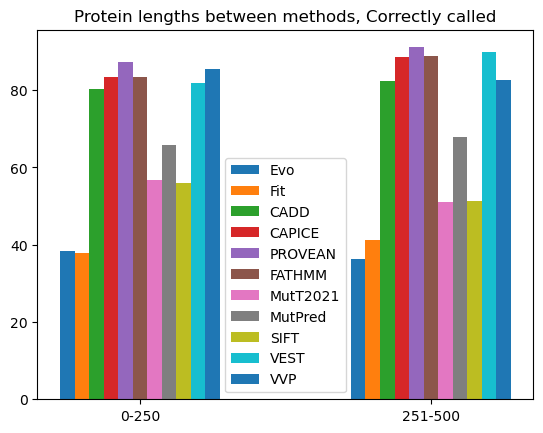

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

([<matplotlib.axis.XTick at 0x741b324411f0>,
 [Text(0, 0, '0-250'), Text(1, 0, '251-500')])

Text(0.5, 1.0, 'Protein lenghts between methods, failed')

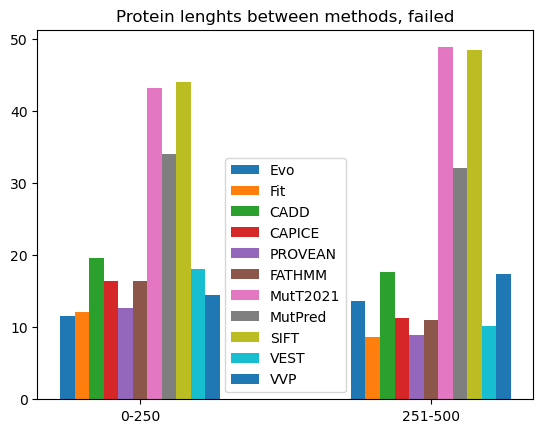

In [108]:
#Plotting correclty and failed calls of indels sizes of all methods

allaalength1 = percentageCADDsize.merge(percentageCAPICEsize, how = 'inner', on = 'Range')
allaalength2 = allaalength1.merge(percentagePROVEANsize, how = 'inner', on = 'Range')
allaalength3 = allaalength2.merge(percentageFATHMMsize, how = 'inner', on = 'Range')
allaalength4 = allaalength3.merge(percentageMutationTaster2021size, how = 'inner', on = 'Range')
allaalength5 = allaalength4.merge(percentageMutPredIndelsize, how = 'inner', on = 'Range')
allaalength6 = allaalength5.merge(percentageSIFTsize, how = 'inner', on = 'Range')
allaalength7 = allaalength6.merge(percentageVESTsize, how = 'inner', on = 'Range')
allaalength8 = allaalength7.merge(percentageVVPsize, how = 'inner', on = 'Range')
allaalength_grouped = allaalength8.merge(percentagesize2, how = 'inner', on = 'Range')

allaalength_grouped

labels5 = list(allaalength_grouped['Range'])
labels5

plt.bar(np.arange(len(allaalength_grouped)) - 0.25, allaalength_grouped['Evocorrect'], 0.05, label = 'Evo')
plt.bar(np.arange(len(allaalength_grouped)) - 0.2, allaalength_grouped['Fitcorrect'], 0.05, label = 'Fit')
plt.bar(np.arange(len(allaalength_grouped)) - 0.15, allaalength_grouped['CADDcorrect'], 0.05, label = 'CADD')
plt.bar(np.arange(len(allaalength_grouped)) - 0.1, allaalength_grouped['CAPICEcorrect'], 0.05, label = 'CAPICE')
plt.bar(np.arange(len(allaalength_grouped)) - 0.05, allaalength_grouped['PROVEANcorrect'], 0.05, label = 'PROVEAN')
plt.bar(np.arange(len(allaalength_grouped)) , allaalength_grouped['FATHMMcorrect'], 0.05, label = 'FATHMM')
plt.bar(np.arange(len(allaalength_grouped)) + 0.05, allaalength_grouped['MutationTaster2021correct'], 0.05, label = 'MutT2021')
plt.bar(np.arange(len(allaalength_grouped)) + 0.1, allaalength_grouped['MutPredIndelcorrect'], 0.05, label = 'MutPred')
plt.bar(np.arange(len(allaalength_grouped)) + 0.15, allaalength_grouped['SIFTcorrect'], 0.05, label = 'SIFT')
plt.bar(np.arange(len(allaalength_grouped)) + 0.2, allaalength_grouped['VESTcorrect'], 0.05, label = 'VEST')
plt.bar(np.arange(len(allaalength_grouped)) + 0.25, allaalength_grouped['VVPcorrect'], 0.05, label = 'VVP')
plt.xticks(np.arange(len(allaalength_grouped)), labels5)
plt.title('Protein lengths between methods, Correctly called')
plt.legend(loc = 'best')
plt.show()

plt.bar(np.arange(len(allaalength_grouped)) - 0.25, allaalength_grouped['EvoFail'], 0.05, label = 'Evo')
plt.bar(np.arange(len(allaalength_grouped)) - 0.2, allaalength_grouped['FitFail'], 0.05, label = 'Fit')
plt.bar(np.arange(len(allaalength_grouped))- 0.15, allaalength_grouped['CADDfail'], 0.05, label = 'CADD')
plt.bar(np.arange(len(allaalength_grouped))- 0.1, allaalength_grouped['CAPICEfail'], 0.05, label = 'CAPICE')
plt.bar(np.arange(len(allaalength_grouped))- 0.05, allaalength_grouped['PROVEANfail'], 0.05, label = 'PROVEAN')
plt.bar(np.arange(len(allaalength_grouped)), allaalength_grouped['FATHMMfail'], 0.05, label = 'FATHMM')
plt.bar(np.arange(len(allaalength_grouped))+ 0.05, allaalength_grouped['MutationTaster2021fail'], 0.05, label = 'MutT2021')
plt.bar(np.arange(len(allaalength_grouped))+ 0.1, allaalength_grouped['MutPredIndelfail'], 0.05, label = 'MutPred')
plt.bar(np.arange(len(allaalength_grouped))+ 0.15, allaalength_grouped['SIFTfail'], 0.05, label = 'SIFT')
plt.bar(np.arange(len(allaalength_grouped))+ 0.2, allaalength_grouped['VESTfail'], 0.05, label = 'VEST')
plt.bar(np.arange(len(allaalength_grouped))+ 0.25, allaalength_grouped['VVPfail'], 0.05, label = 'VVP')
plt.xticks(np.arange(len(allaalength_grouped)), labels5)
plt.title('Protein lenghts between methods, failed')
plt.legend(loc = 'best')
plt.show()

In [56]:
#Look if the results changes if I split the dataset after where the indels are collected from
filtered_origin = keptlabels.dropna(subset=['Origin'])

filtered_origin['Origin'].value_counts()

ClinVarindels = filtered_origin[filtered_origin['Origin'] == 'ClinVar']
gnomADindels = filtered_origin[filtered_origin['Origin'] == 'gnomAD']
DDDindels = filtered_origin[filtered_origin['Origin'] == 'DDD']

Origin
ClinVar    415
gnomAD     121
DDD         29
Name: count, dtype: int64

F1 score Evo small indels ClinVar: 0.40963855421686746
F1 score Fit small indels ClinVar: 0.5779036827195467
F1 score Fit small indels ClinVar: 0.7109634551495017


Text(0.5, 0, 'False Positives (Specificty)')

Text(0, 0.5, 'Trule Positives (Sensitivity)')

Text(0.5, 1.0, 'ROC Curve for our predictions')

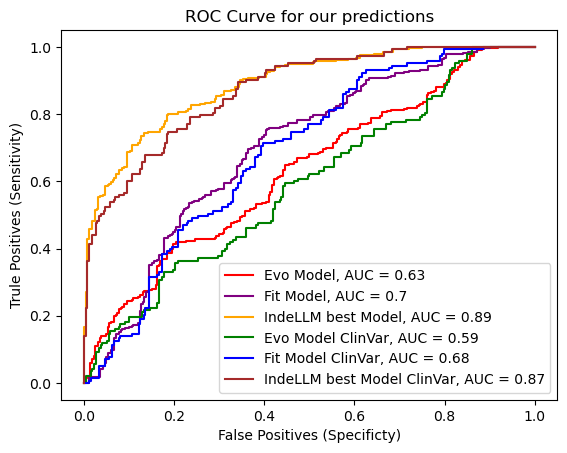

In [57]:
#Calculate the F1 score for all methods to see if any of the models are overfitted

# ClinVar
# Extract pred and labels for our models
ClinVartruelabels = ClinVarindels['labels_binary'].values
pred_evoClinVar = ClinVarindels['dif_evo'].values
pred_fitClinVar = ClinVarindels['dif_fit'].values
pred_bestClinVar = ClinVarindels['dif_best'].values

#Calculating FP, TN and thresholds for Evo and Fit
fpr_evoClinVar, tpr_evoClinVar, thersholds_evoClinVar = metrics.roc_curve(ClinVartruelabels, pred_evoClinVar)
roc_auc_evoClinVar = round(metrics.auc(fpr_evoClinVar, tpr_evoClinVar), 2)

fpr_fitClinVar, tpr_fitClinVar, thersholds_fitClinVar = metrics.roc_curve(ClinVartruelabels, pred_fitClinVar)
roc_auc_fitClinVar = round(metrics.auc(fpr_fitClinVar, tpr_fitClinVar), 2)

fpr_bestClinVar, tpr_bestClinVar, thersholds_bestClinVar = metrics.roc_curve(ClinVartruelabels, pred_bestClinVar)
roc_auc_bestClinVar = round(metrics.auc(fpr_bestClinVar, tpr_bestClinVar), 2)

#Using the threshold to create a binary table of the predicted values
#Find the best threshold
tresh_evoClinVar = thersholds_evoClinVar[np.argmax(tpr_evoClinVar - fpr_evoClinVar)]
tresh_fitClinVar = thersholds_fitClinVar[np.argmax(tpr_fitClinVar - fpr_fitClinVar)]
tresh_bestClinVar = thersholds_bestClinVar[np.argmax(tpr_bestClinVar - fpr_bestClinVar)]

#Converting the continous predictions into binary
pred_evo_binClinVar = [1 if x >= tresh_evoClinVar else 0 for x in pred_evoClinVar]
pred_fit_binClinVar = [1 if x >= tresh_fitClinVar else 0 for x in pred_fitClinVar]
pred_best_binClinVar = [1 if x >= tresh_bestClinVar else 0 for x in pred_bestClinVar]

#Calculating F1 score
f1_evoClinVar = f1_score(ClinVartruelabels, pred_evo_binClinVar, average = 'binary')
f1_fitClinVar = f1_score(ClinVartruelabels, pred_fit_binClinVar, average = 'binary')
f1_bestClinVar = f1_score(ClinVartruelabels, pred_best_binClinVar, average = 'binary')

print("F1 score Evo small indels ClinVar:", f1_evoClinVar)
print("F1 score Fit small indels ClinVar:", f1_fitClinVar)
print("F1 score Fit small indels ClinVar:", f1_bestClinVar)

#Plotting the Evo and Fit AUC 
plt.plot(fpr_evo, tpr_evo, label = "Evo Model, AUC = "+str(roc_auc_evo), color = "red")
plt.plot(fpr_fit, tpr_fit, label = "Fit Model, AUC = "+str(roc_auc_fit), color = "purple")
plt.plot(fpr_best, tpr_best, label = "IndeLLM best Model, AUC = "+str(roc_auc_best), color = "orange")
plt.plot(fpr_evoClinVar, tpr_evoClinVar, label = "Evo Model ClinVar, AUC = "+str(roc_auc_evoClinVar), color = "green")
plt.plot(fpr_fitClinVar, tpr_fitClinVar, label = "Fit Model ClinVar, AUC = "+str(roc_auc_fitClinVar), color = "blue")
plt.plot(fpr_bestClinVar, tpr_bestClinVar, label = "IndeLLM best Model ClinVar, AUC = "+str(roc_auc_bestClinVar), color = "brown")
plt.xlabel('False Positives (Specificty)')
plt.ylabel('Trule Positives (Sensitivity)')
plt.title("ROC Curve for our predictions")
plt.legend(loc = 'best')
plt.show()

I tried with gnomAD as well - but not negative was found, so was not able to calculate the F1 score

F1 score Evo small indels DDD: 0.8205128205128205
F1 score Fit small indels DDD: 0.7272727272727273
F1 score Fit small indels DDD: 0.8823529411764706


Text(0.5, 0, 'False Positives (Specificty)')

Text(0, 0.5, 'Trule Positives (Sensitivity)')

Text(0.5, 1.0, 'ROC Curve for our predictions')

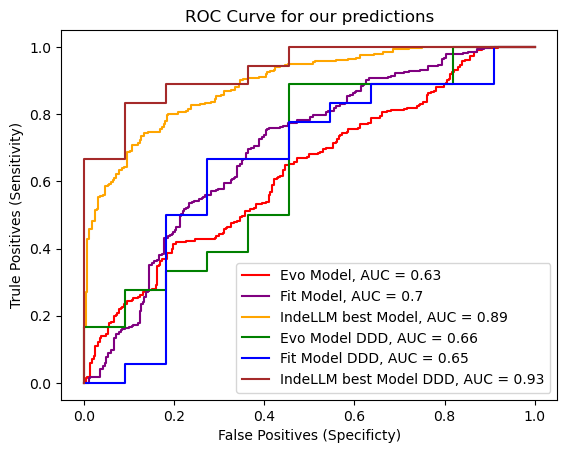

In [58]:
# DDD
# Extract pred and labels for our models
DDDtruelabels = DDDindels['labels_binary'].values
pred_evoDDD = DDDindels['dif_evo'].values
pred_fitDDD = DDDindels['dif_fit'].values
pred_bestDDD = DDDindels['dif_best'].values

#Calculating FP, TN and thresholds for Evo and Fit
fpr_evoDDD, tpr_evoDDD, thersholds_evoDDD = metrics.roc_curve(DDDtruelabels, pred_evoDDD)
roc_auc_evoDDD = round(metrics.auc(fpr_evoDDD, tpr_evoDDD), 2)

fpr_fitDDD, tpr_fitDDD, thersholds_fitDDD = metrics.roc_curve(DDDtruelabels, pred_fitDDD)
roc_auc_fitDDD = round(metrics.auc(fpr_fitDDD, tpr_fitDDD), 2)

fpr_bestDDD, tpr_bestDDD, thersholds_bestDDD = metrics.roc_curve(DDDtruelabels, pred_bestDDD)
roc_auc_bestDDD = round(metrics.auc(fpr_bestDDD, tpr_bestDDD), 2)

#Using the threshold to create a binary table of the predicted values
#Find the best threshold
tresh_evoDDD = thersholds_evoDDD[np.argmax(tpr_evoDDD - fpr_evoDDD)]
tresh_fitDDD = thersholds_fitDDD[np.argmax(tpr_fitDDD - fpr_fitDDD)]
tresh_bestDDD = thersholds_bestDDD[np.argmax(tpr_bestDDD - fpr_bestDDD)]

#Converting the continous predictions into binary
pred_evo_binDDD = [1 if x >= tresh_evoDDD else 0 for x in pred_evoDDD]
pred_fit_binDDD = [1 if x >= tresh_fitDDD else 0 for x in pred_fitDDD]
pred_best_binDDD = [1 if x >= tresh_bestDDD else 0 for x in pred_bestDDD]

#Calculating F1 score
f1_evoDDD = f1_score(DDDtruelabels, pred_evo_binDDD, average = 'binary')
f1_fitDDD = f1_score(DDDtruelabels, pred_fit_binDDD, average = 'binary')
f1_bestDDD = f1_score(DDDtruelabels, pred_best_binDDD, average = 'binary')

print("F1 score Evo small indels DDD:", f1_evoDDD)
print("F1 score Fit small indels DDD:", f1_fitDDD)
print("F1 score Fit small indels DDD:", f1_bestDDD)

#Plotting the Evo and Fit AUC 
plt.plot(fpr_evo, tpr_evo, label = "Evo Model, AUC = "+str(roc_auc_evo), color = "red")
plt.plot(fpr_fit, tpr_fit, label = "Fit Model, AUC = "+str(roc_auc_fit), color = "purple")
plt.plot(fpr_best, tpr_best, label = "IndeLLM best Model, AUC = "+str(roc_auc_best), color = "orange")
plt.plot(fpr_evoDDD, tpr_evoDDD, label = "Evo Model DDD, AUC = "+str(roc_auc_evoDDD), color = "green")
plt.plot(fpr_fitDDD, tpr_fitDDD, label = "Fit Model DDD, AUC = "+str(roc_auc_fitDDD), color = "blue")
plt.plot(fpr_bestDDD, tpr_bestDDD, label = "IndeLLM best Model DDD, AUC = "+str(roc_auc_bestDDD), color = "brown")
plt.xlabel('False Positives (Specificty)')
plt.ylabel('Trule Positives (Sensitivity)')
plt.title("ROC Curve for our predictions")
plt.legend(loc = 'best')
plt.show()

F1 score VEST small indels: 0.8830188679245283
F1 score VEST small indels ClinVar: 0.8972332015810277
F1 score VEST small indels gnomAD: 0.0
F1 score VEST small indels DDD: 0.7619047619047619


/home/vleipart/.conda/envs/MDAnalysis/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/vleipart/.conda/envs/MDAnalysis/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(0.5, 0, 'False Positives (Specificty)')

Text(0, 0.5, 'Trule Positives (Sensitivity)')

Text(0.5, 1.0, 'ROC Curve for our predictions')

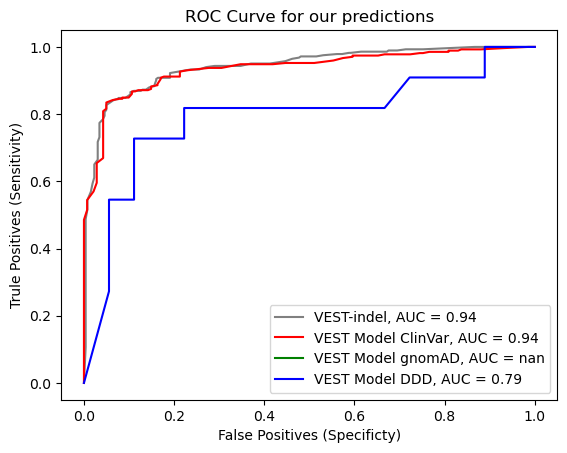

In [59]:
#Calculate the F1 score for VEST

# ClinVar

#Some of the columns in VEST contain no prediction, so filer the dataset
filtered_VESTClinVar = ClinVarindels.dropna(subset=['VEST-indel'])
pred_VESTClinVar = filtered_VESTClinVar['VEST-indel'].values
truelabels_VESTClinVar = filtered_VESTClinVar['labels_binary'].values

#The VEST predicts benig as 0, while pathogenic as 1. So have to change 0 to 1 and 1 to 0
truelabels_VESTClinVar -= 1
truelabels_VESTClinVar = np.abs(truelabels_VESTClinVar) 

#Calculating FP, TN and thresholds for VEST
fpr_VESTClinVar, tpr_VESTClinVar, thersholds_VESTClinVar = metrics.roc_curve(truelabels_VESTClinVar, pred_VESTClinVar)
roc_auc_VESTClinVar = round(metrics.auc(fpr_VESTClinVar, tpr_VESTClinVar), 2)

#Find the best threshold
tresh_VESTClinVar = thersholds_VESTClinVar[np.argmax(tpr_VESTClinVar - fpr_VESTClinVar)]

#Converting the continous predictions into binary
pred_VEST_binClinVar = [1 if x >= tresh_VESTClinVar else 0 for x in pred_VESTClinVar]

#Calculating F1 score
f1_VESTClinVar = f1_score(truelabels_VESTClinVar, pred_VEST_binClinVar, average = 'binary')

# gnomAD
#Some of the columns in VEST contain no prediction, so filer the dataset
filtered_VESTgnomAD = gnomADindels.dropna(subset=['VEST-indel'])
pred_VESTgnomAD = filtered_VESTgnomAD['VEST-indel'].values
truelabels_VESTgnomAD = filtered_VESTgnomAD['labels_binary'].values

#The VEST predicts benig as 0, while pathogenic as 1. So have to change 0 to 1 and 1 to 0
truelabels_VESTgnomAD -= 1
truelabels_VESTgnomAD = np.abs(truelabels_VESTgnomAD) 

#Calculating FP, TN and thresholds for VEST
fpr_VESTgnomAD, tpr_VESTgnomAD, thersholds_VESTgnomAD = metrics.roc_curve(truelabels_VESTgnomAD, pred_VESTgnomAD)
roc_auc_VESTgnomAD = round(metrics.auc(fpr_VESTgnomAD, tpr_VESTgnomAD), 2)

#Find the best threshold
tresh_VESTgnomAD = thersholds_VESTgnomAD[np.argmax(tpr_VESTgnomAD - fpr_VESTgnomAD)]

#Converting the continous predictions into binary
pred_VEST_bingnomAD = [1 if x >= tresh_VESTgnomAD else 0 for x in pred_VESTgnomAD]

#Calculating F1 score
f1_VESTgnomAD = f1_score(truelabels_VESTgnomAD, pred_VEST_bingnomAD, average = 'binary')

# DDD
#Some of the columns in VEST contain no prediction, so filer the dataset
filtered_VESTDDD = DDDindels.dropna(subset=['VEST-indel'])
pred_VESTDDD = filtered_VESTDDD['VEST-indel'].values
truelabels_VESTDDD = filtered_VESTDDD['labels_binary'].values

#The VEST predicts benig as 0, while pathogenic as 1. So have to change 0 to 1 and 1 to 0
truelabels_VESTDDD -= 1
truelabels_VESTDDD = np.abs(truelabels_VESTDDD) 

#Calculating FP, TN and thresholds for VEST
fpr_VESTDDD, tpr_VESTDDD, thersholds_VESTDDD = metrics.roc_curve(truelabels_VESTDDD, pred_VESTDDD)
roc_auc_VESTDDD = round(metrics.auc(fpr_VESTDDD, tpr_VESTDDD), 2)

#Find the best threshold
tresh_VESTDDD = thersholds_VESTDDD[np.argmax(tpr_VESTDDD - fpr_VESTDDD)]

#Converting the continous predictions into binary
pred_VEST_binDDD = [1 if x >= tresh_VESTDDD else 0 for x in pred_VESTDDD]

#Calculating F1 score
f1_VESTDDD = f1_score(truelabels_VESTDDD, pred_VEST_binDDD, average = 'binary')

print("F1 score VEST small indels:", f1_VEST)
print("F1 score VEST small indels ClinVar:", f1_VESTClinVar)
print("F1 score VEST small indels gnomAD:", f1_VESTgnomAD)
print("F1 score VEST small indels DDD:", f1_VESTDDD)

#Plotting the fit and Fit AUC 
plt.plot(fpr_VEST, tpr_VEST, label = "VEST-indel, AUC = "+str(roc_auc_VEST), color = "grey")
plt.plot(fpr_VESTClinVar, tpr_VESTClinVar, label = "VEST Model ClinVar, AUC = "+str(roc_auc_VESTClinVar), color = "red")
plt.plot(fpr_VESTgnomAD, tpr_VESTgnomAD, label = "VEST Model gnomAD, AUC = "+str(roc_auc_VESTgnomAD), color = "green")
plt.plot(fpr_VESTDDD, tpr_VESTDDD, label = "VEST Model DDD, AUC = "+str(roc_auc_VESTDDD), color = "blue")
plt.xlabel('False Positives (Specificty)')
plt.ylabel('Trule Positives (Sensitivity)')
plt.title("ROC Curve for our predictions")
plt.legend(loc = 'best')
plt.show()

F1 score FATHMM small indels: 0.8877721943048577
F1 score FATHMM small indels ClinVar: 0.9396709323583181
F1 score FATHMM small indels gnomAD: 0.0
F1 score FATHMM small indels DDD: 0.7142857142857143


/tmp/ipykernel_3596441/1330389194.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ClinVarindels['FATHMM-indel'] = pd.to_numeric(ClinVarindels['FATHMM-indel'], errors='coerce')
/tmp/ipykernel_3596441/1330389194.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gnomADindels['FATHMM-indel'] = pd.to_numeric(gnomADindels['FATHMM-indel'], errors='coerce')
/tmp/ipykernel_3596441/1330389194.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

Text(0.5, 0, 'False Positives (Specificty)')

Text(0, 0.5, 'Trule Positives (Sensitivity)')

Text(0.5, 1.0, 'ROC Curve for our predictions')

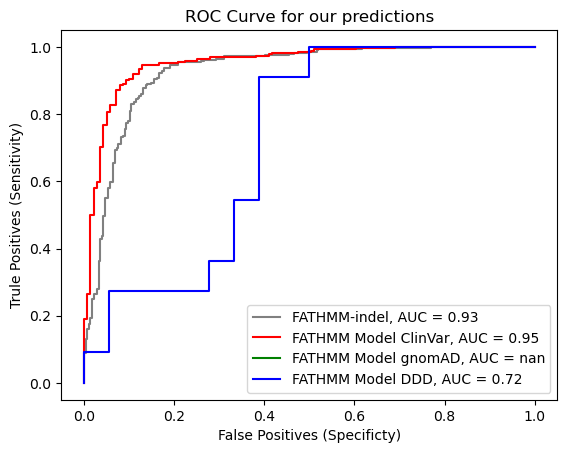

In [60]:
#Calculate the F1 score for FATHMM
ClinVarindels['FATHMM-indel'] = pd.to_numeric(ClinVarindels['FATHMM-indel'], errors='coerce')
gnomADindels['FATHMM-indel'] = pd.to_numeric(gnomADindels['FATHMM-indel'], errors='coerce')
DDDindels['FATHMM-indel'] = pd.to_numeric(DDDindels['FATHMM-indel'], errors='coerce')
# ClinVar

#Some of the columns in FATHMM contain no prediction, so filer the dataset
filtered_FATHMMClinVar = ClinVarindels.dropna(subset=['FATHMM-indel'])
pred_FATHMMClinVar = filtered_FATHMMClinVar['FATHMM-indel'].values
truelabels_FATHMMClinVar = filtered_FATHMMClinVar['labels_binary'].values

#The FATHMM predicts benig as 0, while pathogenic as 1. So have to change 0 to 1 and 1 to 0
truelabels_FATHMMClinVar -= 1
truelabels_FATHMMClinVar = np.abs(truelabels_FATHMMClinVar) 

#Calculating FP, TN and thresholds for FATHMM
fpr_FATHMMClinVar, tpr_FATHMMClinVar, thersholds_FATHMMClinVar = metrics.roc_curve(truelabels_FATHMMClinVar, pred_FATHMMClinVar)
roc_auc_FATHMMClinVar = round(metrics.auc(fpr_FATHMMClinVar, tpr_FATHMMClinVar), 2)

#Find the best threshold
tresh_FATHMMClinVar = thersholds_FATHMMClinVar[np.argmax(tpr_FATHMMClinVar - fpr_FATHMMClinVar)]

#Converting the continous predictions into binary
pred_FATHMM_binClinVar = [1 if x >= tresh_FATHMMClinVar else 0 for x in pred_FATHMMClinVar]

#Calculating F1 score
f1_FATHMMClinVar = f1_score(truelabels_FATHMMClinVar, pred_FATHMM_binClinVar, average = 'binary')

# gnomAD
#Some of the columns in FATHMM contain no prediction, so filer the dataset
filtered_FATHMMgnomAD = gnomADindels.dropna(subset=['FATHMM-indel'])
pred_FATHMMgnomAD = filtered_FATHMMgnomAD['FATHMM-indel'].values
truelabels_FATHMMgnomAD = filtered_FATHMMgnomAD['labels_binary'].values

#The FATHMM predicts benig as 0, while pathogenic as 1. So have to change 0 to 1 and 1 to 0
truelabels_FATHMMgnomAD -= 1
truelabels_FATHMMgnomAD = np.abs(truelabels_FATHMMgnomAD) 

#Calculating FP, TN and thresholds for FATHMM
fpr_FATHMMgnomAD, tpr_FATHMMgnomAD, thersholds_FATHMMgnomAD = metrics.roc_curve(truelabels_FATHMMgnomAD, pred_FATHMMgnomAD)
roc_auc_FATHMMgnomAD = round(metrics.auc(fpr_FATHMMgnomAD, tpr_FATHMMgnomAD), 2)

#Find the best threshold
tresh_FATHMMgnomAD = thersholds_FATHMMgnomAD[np.argmax(tpr_FATHMMgnomAD - fpr_FATHMMgnomAD)]

#Converting the continous predictions into binary
pred_FATHMM_bingnomAD = [1 if x >= tresh_FATHMMgnomAD else 0 for x in pred_FATHMMgnomAD]

#Calculating F1 score
f1_FATHMMgnomAD = f1_score(truelabels_FATHMMgnomAD, pred_FATHMM_bingnomAD, average = 'binary')

# DDD
#Some of the columns in FATHMM contain no prediction, so filer the dataset
filtered_FATHMMDDD = DDDindels.dropna(subset=['FATHMM-indel'])
pred_FATHMMDDD = filtered_FATHMMDDD['FATHMM-indel'].values
truelabels_FATHMMDDD = filtered_FATHMMDDD['labels_binary'].values

#The FATHMM predicts benig as 0, while pathogenic as 1. So have to change 0 to 1 and 1 to 0
truelabels_FATHMMDDD -= 1
truelabels_FATHMMDDD = np.abs(truelabels_FATHMMDDD) 

#Calculating FP, TN and thresholds for FATHMM
fpr_FATHMMDDD, tpr_FATHMMDDD, thersholds_FATHMMDDD = metrics.roc_curve(truelabels_FATHMMDDD, pred_FATHMMDDD)
roc_auc_FATHMMDDD = round(metrics.auc(fpr_FATHMMDDD, tpr_FATHMMDDD), 2)

#Find the best threshold
tresh_FATHMMDDD = thersholds_FATHMMDDD[np.argmax(tpr_FATHMMDDD - fpr_FATHMMDDD)]

#Converting the continous predictions into binary
pred_FATHMM_binDDD = [1 if x >= tresh_FATHMMDDD else 0 for x in pred_FATHMMDDD]

#Calculating F1 score
f1_FATHMMDDD = f1_score(truelabels_FATHMMDDD, pred_FATHMM_binDDD, average = 'binary')

print("F1 score FATHMM small indels:", f1_FATHMM)
print("F1 score FATHMM small indels ClinVar:", f1_FATHMMClinVar)
print("F1 score FATHMM small indels gnomAD:", f1_FATHMMgnomAD)
print("F1 score FATHMM small indels DDD:", f1_FATHMMDDD)

#Plotting the fit and Fit AUC 
plt.plot(fpr_FATHMM, tpr_FATHMM, label = "FATHMM-indel, AUC = "+str(roc_auc_FATHMM), color = "grey")
plt.plot(fpr_FATHMMClinVar, tpr_FATHMMClinVar, label = "FATHMM Model ClinVar, AUC = "+str(roc_auc_FATHMMClinVar), color = "red")
plt.plot(fpr_FATHMMgnomAD, tpr_FATHMMgnomAD, label = "FATHMM Model gnomAD, AUC = "+str(roc_auc_FATHMMgnomAD), color = "green")
plt.plot(fpr_FATHMMDDD, tpr_FATHMMDDD, label = "FATHMM Model DDD, AUC = "+str(roc_auc_FATHMMDDD), color = "blue")
plt.xlabel('False Positives (Specificty)')
plt.ylabel('Trule Positives (Sensitivity)')
plt.title("ROC Curve for our predictions")
plt.legend(loc = 'best')
plt.show()

F1 score CADD small indels: 0.8253424657534246
F1 score CADD small indels ClinVar: 0.868421052631579
F1 score CADD small indels gnomAD: 0.0
F1 score CADD small indels DDD: 0.782608695652174


/tmp/ipykernel_3596441/452323861.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ClinVarindels['CADD'] = pd.to_numeric(ClinVarindels['CADD'], errors='coerce')
/tmp/ipykernel_3596441/452323861.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gnomADindels['CADD'] = pd.to_numeric(gnomADindels['CADD'], errors='coerce')
/tmp/ipykernel_3596441/452323861.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



Text(0.5, 0, 'False Positives (Specificty)')

Text(0, 0.5, 'Trule Positives (Sensitivity)')

Text(0.5, 1.0, 'ROC Curve for our predictions')

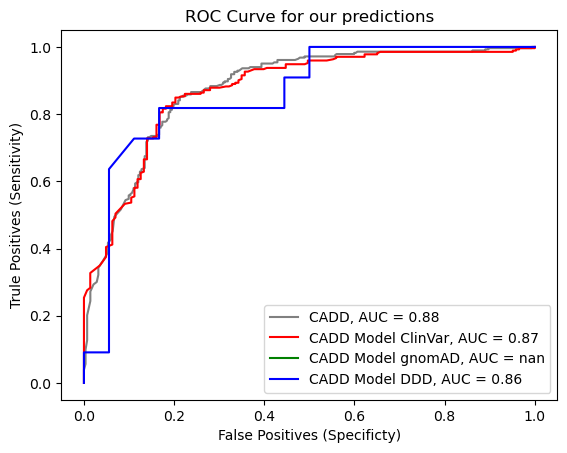

In [61]:
#Calculate the F1 score for CADD
ClinVarindels['CADD'] = pd.to_numeric(ClinVarindels['CADD'], errors='coerce')
gnomADindels['CADD'] = pd.to_numeric(gnomADindels['CADD'], errors='coerce')
DDDindels['CADD'] = pd.to_numeric(DDDindels['CADD'], errors='coerce')
# ClinVar

#Some of the columns in CADD contain no prediction, so filer the dataset
filtered_CADDClinVar = ClinVarindels.dropna(subset=['CADD'])
pred_CADDClinVar = filtered_CADDClinVar['CADD'].values
truelabels_CADDClinVar = filtered_CADDClinVar['labels_binary'].values

#The CADD predicts benig as 0, while pathogenic as 1. So have to change 0 to 1 and 1 to 0
truelabels_CADDClinVar -= 1
truelabels_CADDClinVar = np.abs(truelabels_CADDClinVar) 

#Calculating FP, TN and thresholds for CADD
fpr_CADDClinVar, tpr_CADDClinVar, thersholds_CADDClinVar = metrics.roc_curve(truelabels_CADDClinVar, pred_CADDClinVar)
roc_auc_CADDClinVar = round(metrics.auc(fpr_CADDClinVar, tpr_CADDClinVar), 2)

#Find the best threshold
tresh_CADDClinVar = thersholds_CADDClinVar[np.argmax(tpr_CADDClinVar - fpr_CADDClinVar)]

#Converting the continous predictions into binary
pred_CADD_binClinVar = [1 if x >= tresh_CADDClinVar else 0 for x in pred_CADDClinVar]

#Calculating F1 score
f1_CADDClinVar = f1_score(truelabels_CADDClinVar, pred_CADD_binClinVar, average = 'binary')

# gnomAD
#Some of the columns in CADD contain no prediction, so filer the dataset
filtered_CADDgnomAD = gnomADindels.dropna(subset=['CADD'])
pred_CADDgnomAD = filtered_CADDgnomAD['CADD'].values
truelabels_CADDgnomAD = filtered_CADDgnomAD['labels_binary'].values

#The CADD predicts benig as 0, while pathogenic as 1. So have to change 0 to 1 and 1 to 0
truelabels_CADDgnomAD -= 1
truelabels_CADDgnomAD = np.abs(truelabels_CADDgnomAD) 

#Calculating FP, TN and thresholds for CADD
fpr_CADDgnomAD, tpr_CADDgnomAD, thersholds_CADDgnomAD = metrics.roc_curve(truelabels_CADDgnomAD, pred_CADDgnomAD)
roc_auc_CADDgnomAD = round(metrics.auc(fpr_CADDgnomAD, tpr_CADDgnomAD), 2)

#Find the best threshold
tresh_CADDgnomAD = thersholds_CADDgnomAD[np.argmax(tpr_CADDgnomAD - fpr_CADDgnomAD)]

#Converting the continous predictions into binary
pred_CADD_bingnomAD = [1 if x >= tresh_CADDgnomAD else 0 for x in pred_CADDgnomAD]

#Calculating F1 score
f1_CADDgnomAD = f1_score(truelabels_CADDgnomAD, pred_CADD_bingnomAD, average = 'binary')

# DDD
#Some of the columns in CADD contain no prediction, so filer the dataset
filtered_CADDDDD = DDDindels.dropna(subset=['CADD'])
pred_CADDDDD = filtered_CADDDDD['CADD'].values
truelabels_CADDDDD = filtered_CADDDDD['labels_binary'].values

#The CADD predicts benig as 0, while pathogenic as 1. So have to change 0 to 1 and 1 to 0
truelabels_CADDDDD -= 1
truelabels_CADDDDD = np.abs(truelabels_CADDDDD) 

#Calculating FP, TN and thresholds for CADD
fpr_CADDDDD, tpr_CADDDDD, thersholds_CADDDDD = metrics.roc_curve(truelabels_CADDDDD, pred_CADDDDD)
roc_auc_CADDDDD = round(metrics.auc(fpr_CADDDDD, tpr_CADDDDD), 2)

#Find the best threshold
tresh_CADDDDD = thersholds_CADDDDD[np.argmax(tpr_CADDDDD - fpr_CADDDDD)]

#Converting the continous predictions into binary
pred_CADD_binDDD = [1 if x >= tresh_CADDDDD else 0 for x in pred_CADDDDD]

#Calculating F1 score
f1_CADDDDD = f1_score(truelabels_CADDDDD, pred_CADD_binDDD, average = 'binary')

print("F1 score CADD small indels:", f1_CADD)
print("F1 score CADD small indels ClinVar:", f1_CADDClinVar)
print("F1 score CADD small indels gnomAD:", f1_CADDgnomAD)
print("F1 score CADD small indels DDD:", f1_CADDDDD)

#Plotting the fit and Fit AUC 
plt.plot(fpr_CADD, tpr_CADD, label = "CADD, AUC = "+str(roc_auc_CADD), color = "grey")
plt.plot(fpr_CADDClinVar, tpr_CADDClinVar, label = "CADD Model ClinVar, AUC = "+str(roc_auc_CADDClinVar), color = "red")
plt.plot(fpr_CADDgnomAD, tpr_CADDgnomAD, label = "CADD Model gnomAD, AUC = "+str(roc_auc_CADDgnomAD), color = "green")
plt.plot(fpr_CADDDDD, tpr_CADDDDD, label = "CADD Model DDD, AUC = "+str(roc_auc_CADDDDD), color = "blue")
plt.xlabel('False Positives (Specificty)')
plt.ylabel('Trule Positives (Sensitivity)')
plt.title("ROC Curve for our predictions")
plt.legend(loc = 'best')
plt.show()

F1 score CAPICE small indels: 0.8787346221441125
F1 score CAPICE small indels ClinVar: 0.9090909090909091
F1 score CAPICE small indels gnomAD: 0.0
F1 score CAPICE small indels DDD: 0.8333333333333334


/tmp/ipykernel_3596441/863456306.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ClinVarindels['CAPICE'] = pd.to_numeric(ClinVarindels['CAPICE'], errors='coerce')
/tmp/ipykernel_3596441/863456306.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gnomADindels['CAPICE'] = pd.to_numeric(gnomADindels['CAPICE'], errors='coerce')
/tmp/ipykernel_3596441/863456306.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

Text(0.5, 0, 'False Positives (Specificty)')

Text(0, 0.5, 'Trule Positives (Sensitivity)')

Text(0.5, 1.0, 'ROC Curve for our predictions')

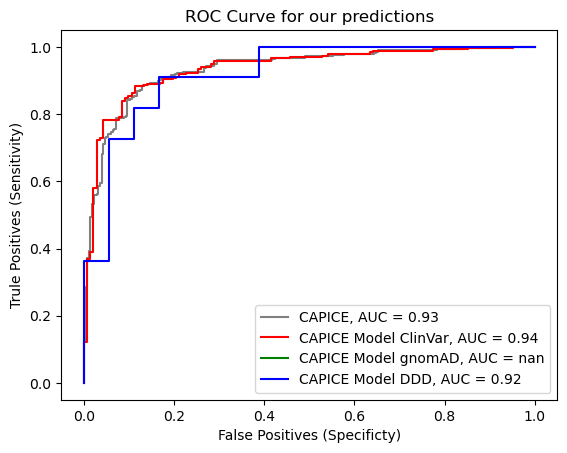

In [62]:
#Calculate the F1 score for CAPICE
ClinVarindels['CAPICE'] = pd.to_numeric(ClinVarindels['CAPICE'], errors='coerce')
gnomADindels['CAPICE'] = pd.to_numeric(gnomADindels['CAPICE'], errors='coerce')
DDDindels['CAPICE'] = pd.to_numeric(DDDindels['CAPICE'], errors='coerce')
# ClinVar

#Some of the columns in CAPICE contain no prediction, so filer the dataset
filtered_CAPICEClinVar = ClinVarindels.dropna(subset=['CAPICE'])
pred_CAPICEClinVar = filtered_CAPICEClinVar['CAPICE'].values
truelabels_CAPICEClinVar = filtered_CAPICEClinVar['labels_binary'].values

#The CAPICE predicts benig as 0, while pathogenic as 1. So have to change 0 to 1 and 1 to 0
truelabels_CAPICEClinVar -= 1
truelabels_CAPICEClinVar = np.abs(truelabels_CAPICEClinVar) 

#Calculating FP, TN and thresholds for CAPICE
fpr_CAPICEClinVar, tpr_CAPICEClinVar, thersholds_CAPICEClinVar = metrics.roc_curve(truelabels_CAPICEClinVar, pred_CAPICEClinVar)
roc_auc_CAPICEClinVar = round(metrics.auc(fpr_CAPICEClinVar, tpr_CAPICEClinVar), 2)

#Find the best threshold
tresh_CAPICEClinVar = thersholds_CAPICEClinVar[np.argmax(tpr_CAPICEClinVar - fpr_CAPICEClinVar)]

#Converting the continous predictions into binary
pred_CAPICE_binClinVar = [1 if x >= tresh_CAPICEClinVar else 0 for x in pred_CAPICEClinVar]

#Calculating F1 score
f1_CAPICEClinVar = f1_score(truelabels_CAPICEClinVar, pred_CAPICE_binClinVar, average = 'binary')

# gnomAD
#Some of the columns in CAPICE contain no prediction, so filer the dataset
filtered_CAPICEgnomAD = gnomADindels.dropna(subset=['CAPICE'])
pred_CAPICEgnomAD = filtered_CAPICEgnomAD['CAPICE'].values
truelabels_CAPICEgnomAD = filtered_CAPICEgnomAD['labels_binary'].values

#The CAPICE predicts benig as 0, while pathogenic as 1. So have to change 0 to 1 and 1 to 0
truelabels_CAPICEgnomAD -= 1
truelabels_CAPICEgnomAD = np.abs(truelabels_CAPICEgnomAD) 

#Calculating FP, TN and thresholds for CAPICE
fpr_CAPICEgnomAD, tpr_CAPICEgnomAD, thersholds_CAPICEgnomAD = metrics.roc_curve(truelabels_CAPICEgnomAD, pred_CAPICEgnomAD)
roc_auc_CAPICEgnomAD = round(metrics.auc(fpr_CAPICEgnomAD, tpr_CAPICEgnomAD), 2)

#Find the best threshold
tresh_CAPICEgnomAD = thersholds_CAPICEgnomAD[np.argmax(tpr_CAPICEgnomAD - fpr_CAPICEgnomAD)]

#Converting the continous predictions into binary
pred_CAPICE_bingnomAD = [1 if x >= tresh_CAPICEgnomAD else 0 for x in pred_CAPICEgnomAD]

#Calculating F1 score
f1_CAPICEgnomAD = f1_score(truelabels_CAPICEgnomAD, pred_CAPICE_bingnomAD, average = 'binary')

# DDD
#Some of the columns in CAPICE contain no prediction, so filer the dataset
filtered_CAPICEDDD = DDDindels.dropna(subset=['CAPICE'])
pred_CAPICEDDD = filtered_CAPICEDDD['CAPICE'].values
truelabels_CAPICEDDD = filtered_CAPICEDDD['labels_binary'].values

#The CAPICE predicts benig as 0, while pathogenic as 1. So have to change 0 to 1 and 1 to 0
truelabels_CAPICEDDD -= 1
truelabels_CAPICEDDD = np.abs(truelabels_CAPICEDDD) 

#Calculating FP, TN and thresholds for CAPICE
fpr_CAPICEDDD, tpr_CAPICEDDD, thersholds_CAPICEDDD = metrics.roc_curve(truelabels_CAPICEDDD, pred_CAPICEDDD)
roc_auc_CAPICEDDD = round(metrics.auc(fpr_CAPICEDDD, tpr_CAPICEDDD), 2)

#Find the best threshold
tresh_CAPICEDDD = thersholds_CAPICEDDD[np.argmax(tpr_CAPICEDDD - fpr_CAPICEDDD)]

#Converting the continous predictions into binary
pred_CAPICE_binDDD = [1 if x >= tresh_CAPICEDDD else 0 for x in pred_CAPICEDDD]

#Calculating F1 score
f1_CAPICEDDD = f1_score(truelabels_CAPICEDDD, pred_CAPICE_binDDD, average = 'binary')

print("F1 score CAPICE small indels:", f1_CAPICE)
print("F1 score CAPICE small indels ClinVar:", f1_CAPICEClinVar)
print("F1 score CAPICE small indels gnomAD:", f1_CAPICEgnomAD)
print("F1 score CAPICE small indels DDD:", f1_CAPICEDDD)

#Plotting the fit and Fit AUC 
plt.plot(fpr_CAPICE, tpr_CAPICE, label = "CAPICE, AUC = "+str(roc_auc_CAPICE), color = "grey")
plt.plot(fpr_CAPICEClinVar, tpr_CAPICEClinVar, label = "CAPICE Model ClinVar, AUC = "+str(roc_auc_CAPICEClinVar), color = "red")
plt.plot(fpr_CAPICEgnomAD, tpr_CAPICEgnomAD, label = "CAPICE Model gnomAD, AUC = "+str(roc_auc_CAPICEgnomAD), color = "green")
plt.plot(fpr_CAPICEDDD, tpr_CAPICEDDD, label = "CAPICE Model DDD, AUC = "+str(roc_auc_CAPICEDDD), color = "blue")
plt.xlabel('False Positives (Specificty)')
plt.ylabel('Trule Positives (Sensitivity)')
plt.title("ROC Curve for our predictions")
plt.legend(loc = 'best')
plt.show()

F1 score PROVEAN small indels: 0.9065606361829026
F1 score PROVEAN small indels ClinVar: 0.9134948096885813
F1 score PROVEAN small indels gnomAD: 0.0
F1 score PROVEAN small indels DDD: 0.9411764705882353


/tmp/ipykernel_3596441/4088012628.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ClinVarindels['PROVEAN'] = pd.to_numeric(ClinVarindels['PROVEAN'], errors='coerce')
/tmp/ipykernel_3596441/4088012628.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gnomADindels['PROVEAN'] = pd.to_numeric(gnomADindels['PROVEAN'], errors='coerce')
/tmp/ipykernel_3596441/4088012628.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Text(0.5, 0, 'False Positives (Specificty)')

Text(0, 0.5, 'Trule Positives (Sensitivity)')

Text(0.5, 1.0, 'ROC Curve for our predictions')

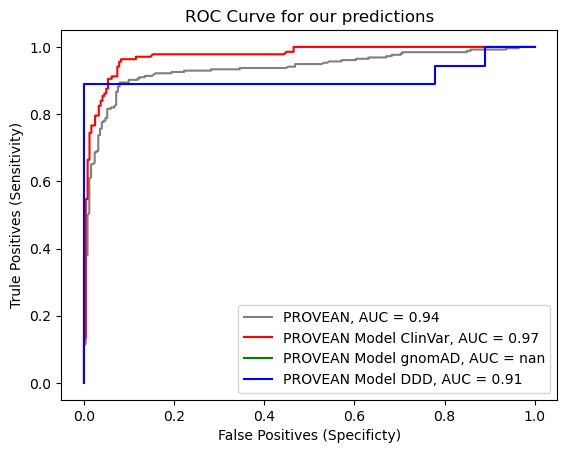

In [63]:
#Calculate the F1 score for PROVEAN
ClinVarindels['PROVEAN'] = pd.to_numeric(ClinVarindels['PROVEAN'], errors='coerce')
gnomADindels['PROVEAN'] = pd.to_numeric(gnomADindels['PROVEAN'], errors='coerce')
DDDindels['PROVEAN'] = pd.to_numeric(DDDindels['PROVEAN'], errors='coerce')
# ClinVar

#Some of the columns in PROVEAN contain no prediction, so filer the dataset
filtered_PROVEANClinVar = ClinVarindels.dropna(subset=['PROVEAN'])
pred_PROVEANClinVar = filtered_PROVEANClinVar['PROVEAN'].values
truelabels_PROVEANClinVar = filtered_PROVEANClinVar['labels_binary'].values

#Calculating FP, TN and thresholds for PROVEAN
fpr_PROVEANClinVar, tpr_PROVEANClinVar, thersholds_PROVEANClinVar = metrics.roc_curve(truelabels_PROVEANClinVar, pred_PROVEANClinVar)
roc_auc_PROVEANClinVar = round(metrics.auc(fpr_PROVEANClinVar, tpr_PROVEANClinVar), 2)

#Find the best threshold
tresh_PROVEANClinVar = thersholds_PROVEANClinVar[np.argmax(tpr_PROVEANClinVar - fpr_PROVEANClinVar)]

#Converting the continous predictions into binary
pred_PROVEAN_binClinVar = [1 if x >= tresh_PROVEANClinVar else 0 for x in pred_PROVEANClinVar]

#Calculating F1 score
f1_PROVEANClinVar = f1_score(truelabels_PROVEANClinVar, pred_PROVEAN_binClinVar, average = 'binary')

# gnomAD
#Some of the columns in PROVEAN contain no prediction, so filer the dataset
filtered_PROVEANgnomAD = gnomADindels.dropna(subset=['PROVEAN'])
pred_PROVEANgnomAD = filtered_PROVEANgnomAD['PROVEAN'].values
truelabels_PROVEANgnomAD = filtered_PROVEANgnomAD['labels_binary'].values

#Calculating FP, TN and thresholds for PROVEAN
fpr_PROVEANgnomAD, tpr_PROVEANgnomAD, thersholds_PROVEANgnomAD = metrics.roc_curve(truelabels_PROVEANgnomAD, pred_PROVEANgnomAD)
roc_auc_PROVEANgnomAD = round(metrics.auc(fpr_PROVEANgnomAD, tpr_PROVEANgnomAD), 2)

#Find the best threshold
tresh_PROVEANgnomAD = thersholds_PROVEANgnomAD[np.argmax(tpr_PROVEANgnomAD - fpr_PROVEANgnomAD)]

#Converting the continous predictions into binary
pred_PROVEAN_bingnomAD = [1 if x >= tresh_PROVEANgnomAD else 0 for x in pred_PROVEANgnomAD]

#Calculating F1 score
f1_PROVEANgnomAD = f1_score(truelabels_PROVEANgnomAD, pred_PROVEAN_bingnomAD, average = 'binary')

# DDD
#Some of the columns in PROVEAN contain no prediction, so filer the dataset
filtered_PROVEANDDD = DDDindels.dropna(subset=['PROVEAN'])
pred_PROVEANDDD = filtered_PROVEANDDD['PROVEAN'].values
truelabels_PROVEANDDD = filtered_PROVEANDDD['labels_binary'].values

#Calculating FP, TN and thresholds for PROVEAN
fpr_PROVEANDDD, tpr_PROVEANDDD, thersholds_PROVEANDDD = metrics.roc_curve(truelabels_PROVEANDDD, pred_PROVEANDDD)
roc_auc_PROVEANDDD = round(metrics.auc(fpr_PROVEANDDD, tpr_PROVEANDDD), 2)

#Find the best threshold
tresh_PROVEANDDD = thersholds_PROVEANDDD[np.argmax(tpr_PROVEANDDD - fpr_PROVEANDDD)]

#Converting the continous predictions into binary
pred_PROVEAN_binDDD = [1 if x >= tresh_PROVEANDDD else 0 for x in pred_PROVEANDDD]

#Calculating F1 score
f1_PROVEANDDD = f1_score(truelabels_PROVEANDDD, pred_PROVEAN_binDDD, average = 'binary')

print("F1 score PROVEAN small indels:", f1_PROVEAN)
print("F1 score PROVEAN small indels ClinVar:", f1_PROVEANClinVar)
print("F1 score PROVEAN small indels gnomAD:", f1_PROVEANgnomAD)
print("F1 score PROVEAN small indels DDD:", f1_PROVEANDDD)

#Plotting the fit and Fit AUC 
plt.plot(fpr_PROVEAN, tpr_PROVEAN, label = "PROVEAN, AUC = "+str(roc_auc_PROVEAN), color = "grey")
plt.plot(fpr_PROVEANClinVar, tpr_PROVEANClinVar, label = "PROVEAN Model ClinVar, AUC = "+str(roc_auc_PROVEANClinVar), color = "red")
plt.plot(fpr_PROVEANgnomAD, tpr_PROVEANgnomAD, label = "PROVEAN Model gnomAD, AUC = "+str(roc_auc_PROVEANgnomAD), color = "green")
plt.plot(fpr_PROVEANDDD, tpr_PROVEANDDD, label = "PROVEAN Model DDD, AUC = "+str(roc_auc_PROVEANDDD), color = "blue")
plt.xlabel('False Positives (Specificty)')
plt.ylabel('Trule Positives (Sensitivity)')
plt.title("ROC Curve for our predictions")
plt.legend(loc = 'best')
plt.show()

F1 score MutationTaster2021 small indels: 0.9537223340040242
F1 score MutationTaster2021 small indels ClinVar: 0.9481481481481482
F1 score MutationTaster2021 small indels gnomAD: 0.0
F1 score MutationTaster2021 small indels DDD: 0.8


/tmp/ipykernel_3596441/3161289196.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_MutationTaster2021ClinVar['MutationTaster2021_bin'] = [ 1 if x == 'Benign' else 0 for x in filtered_MutationTaster2021ClinVar['MutationTaster2021']]
/tmp/ipykernel_3596441/3161289196.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_MutationTaster2021gnomAD['MutationTaster2021_bin'] = [ 1 if x == 'Benign' else 0 for x in filtered_MutationTaster2021gnomAD['MutationTaster2021']]
/home/vleipart/.conda/env

Text(0.5, 0, 'False Positives (Specificty)')

Text(0, 0.5, 'Trule Positives (Sensitivity)')

Text(0.5, 1.0, 'ROC Curve for our predictions')

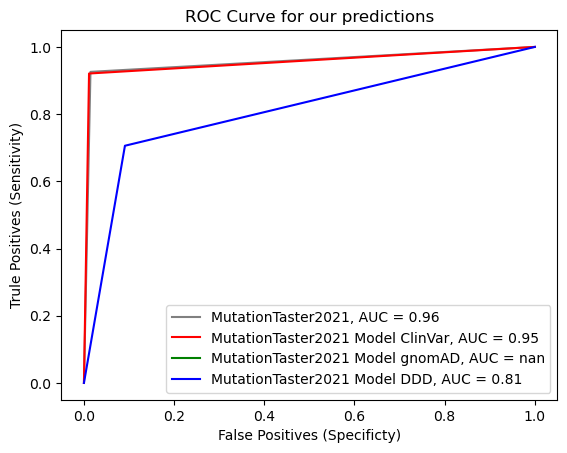

In [64]:
#Calculate the F1 score for MutationTaster2021
# ClinVar

#Some of the columns in MutationTaster2021 contain no prediction, so filer the dataset
filtered_MutationTaster2021ClinVar = ClinVarindels.dropna(subset=['MutationTaster2021'])
filtered_MutationTaster2021ClinVar['MutationTaster2021_bin'] = [ 1 if x == 'Benign' else 0 for x in filtered_MutationTaster2021ClinVar['MutationTaster2021']]
pred_MutationTaster2021ClinVar = filtered_MutationTaster2021ClinVar['MutationTaster2021_bin'].values
truelabels_MutationTaster2021ClinVar = filtered_MutationTaster2021ClinVar['labels_binary'].values

#Calculating FP, TN and thresholds for MutationTaster2021
fpr_MutationTaster2021ClinVar, tpr_MutationTaster2021ClinVar, thersholds_MutationTaster2021ClinVar = metrics.roc_curve(truelabels_MutationTaster2021ClinVar, pred_MutationTaster2021ClinVar)
roc_auc_MutationTaster2021ClinVar = round(metrics.auc(fpr_MutationTaster2021ClinVar, tpr_MutationTaster2021ClinVar), 2)

#Find the best threshold
tresh_MutationTaster2021ClinVar = thersholds_MutationTaster2021ClinVar[np.argmax(tpr_MutationTaster2021ClinVar - fpr_MutationTaster2021ClinVar)]

#Converting the continous predictions into binary
pred_MutationTaster2021_binClinVar = [1 if x >= tresh_MutationTaster2021ClinVar else 0 for x in pred_MutationTaster2021ClinVar]

#Calculating F1 score
f1_MutationTaster2021ClinVar = f1_score(truelabels_MutationTaster2021ClinVar, pred_MutationTaster2021_binClinVar, average = 'binary')

# gnomAD
#Some of the columns in MutationTaster2021 contain no prediction, so filer the dataset
filtered_MutationTaster2021gnomAD = gnomADindels.dropna(subset=['MutationTaster2021'])
filtered_MutationTaster2021gnomAD['MutationTaster2021_bin'] = [ 1 if x == 'Benign' else 0 for x in filtered_MutationTaster2021gnomAD['MutationTaster2021']]
pred_MutationTaster2021gnomAD = filtered_MutationTaster2021gnomAD['MutationTaster2021_bin'].values
truelabels_MutationTaster2021gnomAD = filtered_MutationTaster2021gnomAD['labels_binary'].values

#Calculating FP, TN and thresholds for MutationTaster2021
fpr_MutationTaster2021gnomAD, tpr_MutationTaster2021gnomAD, thersholds_MutationTaster2021gnomAD = metrics.roc_curve(truelabels_MutationTaster2021gnomAD, pred_MutationTaster2021gnomAD)
roc_auc_MutationTaster2021gnomAD = round(metrics.auc(fpr_MutationTaster2021gnomAD, tpr_MutationTaster2021gnomAD), 2)

#Find the best threshold
tresh_MutationTaster2021gnomAD = thersholds_MutationTaster2021gnomAD[np.argmax(tpr_MutationTaster2021gnomAD - fpr_MutationTaster2021gnomAD)]

#Converting the continous predictions into binary
pred_MutationTaster2021_bingnomAD = [1 if x >= tresh_MutationTaster2021gnomAD else 0 for x in pred_MutationTaster2021gnomAD]

#Calculating F1 score
f1_MutationTaster2021gnomAD = f1_score(truelabels_MutationTaster2021gnomAD, pred_MutationTaster2021_bingnomAD, average = 'binary')

# DDD
#Some of the columns in MutationTaster2021 contain no prediction, so filer the dataset
filtered_MutationTaster2021DDD = DDDindels.dropna(subset=['MutationTaster2021'])
filtered_MutationTaster2021DDD['MutationTaster2021_bin'] = [ 1 if x == 'Benign' else 0 for x in filtered_MutationTaster2021DDD['MutationTaster2021']]
pred_MutationTaster2021DDD = filtered_MutationTaster2021DDD['MutationTaster2021_bin'].values
truelabels_MutationTaster2021DDD = filtered_MutationTaster2021DDD['labels_binary'].values

#Calculating FP, TN and thresholds for MutationTaster2021
fpr_MutationTaster2021DDD, tpr_MutationTaster2021DDD, thersholds_MutationTaster2021DDD = metrics.roc_curve(truelabels_MutationTaster2021DDD, pred_MutationTaster2021DDD)
roc_auc_MutationTaster2021DDD = round(metrics.auc(fpr_MutationTaster2021DDD, tpr_MutationTaster2021DDD), 2)

#Find the best threshold
tresh_MutationTaster2021DDD = thersholds_MutationTaster2021DDD[np.argmax(tpr_MutationTaster2021DDD - fpr_MutationTaster2021DDD)]

#Converting the continous predictions into binary
pred_MutationTaster2021_binDDD = [1 if x >= tresh_MutationTaster2021DDD else 0 for x in pred_MutationTaster2021DDD]

#Calculating F1 score
f1_MutationTaster2021DDD = f1_score(truelabels_MutationTaster2021DDD, pred_MutationTaster2021_binDDD, average = 'binary')

print("F1 score MutationTaster2021 small indels:", f1_MutationTaster2021)
print("F1 score MutationTaster2021 small indels ClinVar:", f1_MutationTaster2021ClinVar)
print("F1 score MutationTaster2021 small indels gnomAD:", f1_MutationTaster2021gnomAD)
print("F1 score MutationTaster2021 small indels DDD:", f1_MutationTaster2021DDD)

#Plotting the fit and Fit AUC 
plt.plot(fpr_MutationTaster2021, tpr_MutationTaster2021, label = "MutationTaster2021, AUC = "+str(roc_auc_MutationTaster2021), color = "grey")
plt.plot(fpr_MutationTaster2021ClinVar, tpr_MutationTaster2021ClinVar, label = "MutationTaster2021 Model ClinVar, AUC = "+str(roc_auc_MutationTaster2021ClinVar), color = "red")
plt.plot(fpr_MutationTaster2021gnomAD, tpr_MutationTaster2021gnomAD, label = "MutationTaster2021 Model gnomAD, AUC = "+str(roc_auc_MutationTaster2021gnomAD), color = "green")
plt.plot(fpr_MutationTaster2021DDD, tpr_MutationTaster2021DDD, label = "MutationTaster2021 Model DDD, AUC = "+str(roc_auc_MutationTaster2021DDD), color = "blue")
plt.xlabel('False Positives (Specificty)')
plt.ylabel('Trule Positives (Sensitivity)')
plt.title("ROC Curve for our predictions")
plt.legend(loc = 'best')
plt.show()

F1 score MutPredIndel small indels: 0.5839080459770115
F1 score MutPredIndel small indels ClinVar: 0.5771144278606966
F1 score MutPredIndel small indels gnomAD: 0.0
F1 score MutPredIndel small indels DDD: 0.6666666666666666


/tmp/ipykernel_3596441/1200529313.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ClinVarindels['MutPredIndel'] = pd.to_numeric(ClinVarindels['MutPredIndel'], errors='coerce')
/tmp/ipykernel_3596441/1200529313.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gnomADindels['MutPredIndel'] = pd.to_numeric(gnomADindels['MutPredIndel'], errors='coerce')
/tmp/ipykernel_3596441/1200529313.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

Text(0.5, 0, 'False Positives (Specificty)')

Text(0, 0.5, 'Trule Positives (Sensitivity)')

Text(0.5, 1.0, 'ROC Curve for our predictions')

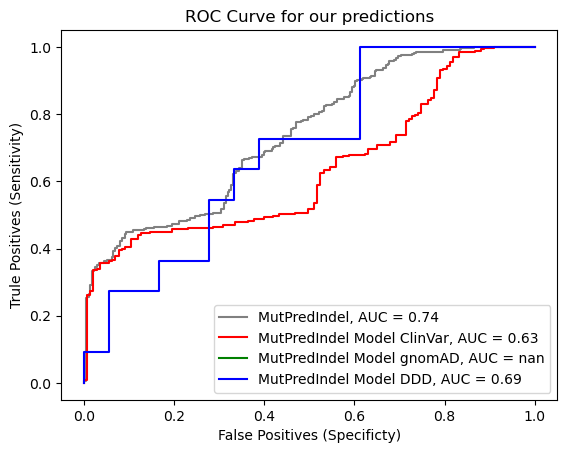

In [65]:
#Calculate the F1 score for MutPredIndel
ClinVarindels['MutPredIndel'] = pd.to_numeric(ClinVarindels['MutPredIndel'], errors='coerce')
gnomADindels['MutPredIndel'] = pd.to_numeric(gnomADindels['MutPredIndel'], errors='coerce')
DDDindels['MutPredIndel'] = pd.to_numeric(DDDindels['MutPredIndel'], errors='coerce')
# ClinVar

#Some of the columns in MutPredIndel contain no prediction, so filer the dataset
filtered_MutPredIndelClinVar = ClinVarindels.dropna(subset=['MutPredIndel'])
pred_MutPredIndelClinVar = filtered_MutPredIndelClinVar['MutPredIndel'].values
truelabels_MutPredIndelClinVar = filtered_MutPredIndelClinVar['labels_binary'].values

#The MutPredIndel predicts benig as 0, while pathogenic as 1. So have to change 0 to 1 and 1 to 0
truelabels_MutPredIndelClinVar -= 1
truelabels_MutPredIndelClinVar = np.abs(truelabels_MutPredIndelClinVar) 

#Calculating FP, TN and thresholds for MutPredIndel
fpr_MutPredIndelClinVar, tpr_MutPredIndelClinVar, thersholds_MutPredIndelClinVar = metrics.roc_curve(truelabels_MutPredIndelClinVar, pred_MutPredIndelClinVar)
roc_auc_MutPredIndelClinVar = round(metrics.auc(fpr_MutPredIndelClinVar, tpr_MutPredIndelClinVar), 2)

#Find the best threshold
tresh_MutPredIndelClinVar = thersholds_MutPredIndelClinVar[np.argmax(tpr_MutPredIndelClinVar - fpr_MutPredIndelClinVar)]

#Converting the continous predictions into binary
pred_MutPredIndel_binClinVar = [1 if x >= tresh_MutPredIndelClinVar else 0 for x in pred_MutPredIndelClinVar]

#Calculating F1 score
f1_MutPredIndelClinVar = f1_score(truelabels_MutPredIndelClinVar, pred_MutPredIndel_binClinVar, average = 'binary')

# gnomAD
#Some of the columns in MutPredIndel contain no prediction, so filer the dataset
filtered_MutPredIndelgnomAD = gnomADindels.dropna(subset=['MutPredIndel'])
pred_MutPredIndelgnomAD = filtered_MutPredIndelgnomAD['MutPredIndel'].values
truelabels_MutPredIndelgnomAD = filtered_MutPredIndelgnomAD['labels_binary'].values

#The MutPredIndel predicts benig as 0, while pathogenic as 1. So have to change 0 to 1 and 1 to 0
truelabels_MutPredIndelgnomAD -= 1
truelabels_MutPredIndelgnomAD = np.abs(truelabels_MutPredIndelgnomAD) 

#Calculating FP, TN and thresholds for MutPredIndel
fpr_MutPredIndelgnomAD, tpr_MutPredIndelgnomAD, thersholds_MutPredIndelgnomAD = metrics.roc_curve(truelabels_MutPredIndelgnomAD, pred_MutPredIndelgnomAD)
roc_auc_MutPredIndelgnomAD = round(metrics.auc(fpr_MutPredIndelgnomAD, tpr_MutPredIndelgnomAD), 2)

#Find the best threshold
tresh_MutPredIndelgnomAD = thersholds_MutPredIndelgnomAD[np.argmax(tpr_MutPredIndelgnomAD - fpr_MutPredIndelgnomAD)]

#Converting the continous predictions into binary
pred_MutPredIndel_bingnomAD = [1 if x >= tresh_MutPredIndelgnomAD else 0 for x in pred_MutPredIndelgnomAD]

#Calculating F1 score
f1_MutPredIndelgnomAD = f1_score(truelabels_MutPredIndelgnomAD, pred_MutPredIndel_bingnomAD, average = 'binary')

# DDD
#Some of the columns in MutPredIndel contain no prediction, so filer the dataset
filtered_MutPredIndelDDD = DDDindels.dropna(subset=['MutPredIndel'])
pred_MutPredIndelDDD = filtered_MutPredIndelDDD['MutPredIndel'].values
truelabels_MutPredIndelDDD = filtered_MutPredIndelDDD['labels_binary'].values

#The MutPredIndel predicts benig as 0, while pathogenic as 1. So have to change 0 to 1 and 1 to 0
truelabels_MutPredIndelDDD -= 1
truelabels_MutPredIndelDDD = np.abs(truelabels_MutPredIndelDDD) 

#Calculating FP, TN and thresholds for MutPredIndel
fpr_MutPredIndelDDD, tpr_MutPredIndelDDD, thersholds_MutPredIndelDDD = metrics.roc_curve(truelabels_MutPredIndelDDD, pred_MutPredIndelDDD)
roc_auc_MutPredIndelDDD = round(metrics.auc(fpr_MutPredIndelDDD, tpr_MutPredIndelDDD), 2)

#Find the best threshold
tresh_MutPredIndelDDD = thersholds_MutPredIndelDDD[np.argmax(tpr_MutPredIndelDDD - fpr_MutPredIndelDDD)]

#Converting the continous predictions into binary
pred_MutPredIndel_binDDD = [1 if x >= tresh_MutPredIndelDDD else 0 for x in pred_MutPredIndelDDD]

#Calculating F1 score
f1_MutPredIndelDDD = f1_score(truelabels_MutPredIndelDDD, pred_MutPredIndel_binDDD, average = 'binary')

print("F1 score MutPredIndel small indels:", f1_MutPredIndel)
print("F1 score MutPredIndel small indels ClinVar:", f1_MutPredIndelClinVar)
print("F1 score MutPredIndel small indels gnomAD:", f1_MutPredIndelgnomAD)
print("F1 score MutPredIndel small indels DDD:", f1_MutPredIndelDDD)

#Plotting the fit and Fit AUC 
plt.plot(fpr_MutPredIndel, tpr_MutPredIndel, label = "MutPredIndel, AUC = "+str(roc_auc_MutPredIndel), color = "grey")
plt.plot(fpr_MutPredIndelClinVar, tpr_MutPredIndelClinVar, label = "MutPredIndel Model ClinVar, AUC = "+str(roc_auc_MutPredIndelClinVar), color = "red")
plt.plot(fpr_MutPredIndelgnomAD, tpr_MutPredIndelgnomAD, label = "MutPredIndel Model gnomAD, AUC = "+str(roc_auc_MutPredIndelgnomAD), color = "green")
plt.plot(fpr_MutPredIndelDDD, tpr_MutPredIndelDDD, label = "MutPredIndel Model DDD, AUC = "+str(roc_auc_MutPredIndelDDD), color = "blue")
plt.xlabel('False Positives (Specificty)')
plt.ylabel('Trule Positives (Sensitivity)')
plt.title("ROC Curve for our predictions")
plt.legend(loc = 'best')
plt.show()

F1 score SIFT small indels: 0.7647058823529411
F1 score SIFT small indels ClinVar: 0.0
F1 score SIFT small indels gnomAD: 0.0
F1 score SIFT small indels DDD: 0.0


/tmp/ipykernel_3596441/4104604754.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_SIFTClinVar['SIFT-indel_bin'] = [ 1 if x == 'Benign' else 0 for x in filtered_SIFTClinVar['SIFT-indel']]
/tmp/ipykernel_3596441/4104604754.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_SIFTgnomAD['SIFT-indel_bin'] = [ 1 if x == 'Benign' else 0 for x in filtered_SIFTgnomAD['SIFT-indel']]
/home/vleipart/.conda/envs/MDAnalysis/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1124: UndefinedMet

Text(0.5, 0, 'False Positives (Specificty)')

Text(0, 0.5, 'Trule Positives (Sensitivity)')

Text(0.5, 1.0, 'ROC Curve for our predictions')

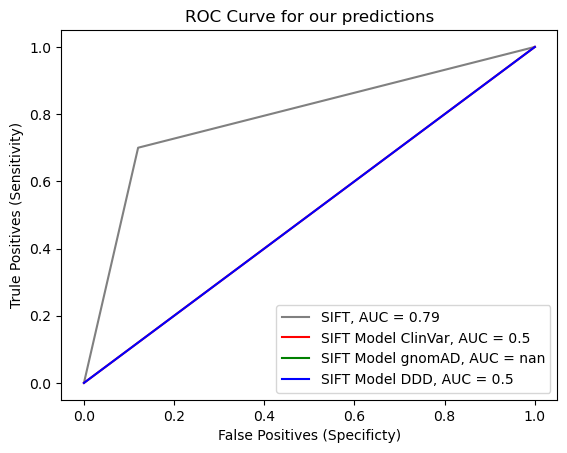

In [66]:
#Calculate the F1 score for SIFT
# ClinVar

#Some of the columns in SIFT contain no prediction, so filer the dataset
filtered_SIFTClinVar = ClinVarindels.dropna(subset=['SIFT-indel'])
filtered_SIFTClinVar['SIFT-indel_bin'] = [ 1 if x == 'Benign' else 0 for x in filtered_SIFTClinVar['SIFT-indel']]
pred_SIFTClinVar = filtered_SIFTClinVar['SIFT-indel_bin'].values
truelabels_SIFTClinVar = filtered_SIFTClinVar['labels_binary'].values

#Calculating FP, TN and thresholds for SIFT
fpr_SIFTClinVar, tpr_SIFTClinVar, thersholds_SIFTClinVar = metrics.roc_curve(truelabels_SIFTClinVar, pred_SIFTClinVar)
roc_auc_SIFTClinVar = round(metrics.auc(fpr_SIFTClinVar, tpr_SIFTClinVar), 2)

#Find the best threshold
tresh_SIFTClinVar = thersholds_SIFTClinVar[np.argmax(tpr_SIFTClinVar - fpr_SIFTClinVar)]

#Converting the continous predictions into binary
pred_SIFT_binClinVar = [1 if x >= tresh_SIFTClinVar else 0 for x in pred_SIFTClinVar]

#Calculating F1 score
f1_SIFTClinVar = f1_score(truelabels_SIFTClinVar, pred_SIFT_binClinVar, average = 'binary')

# gnomAD
#Some of the columns in SIFT contain no prediction, so filer the dataset
filtered_SIFTgnomAD = gnomADindels.dropna(subset=['SIFT-indel'])
filtered_SIFTgnomAD['SIFT-indel_bin'] = [ 1 if x == 'Benign' else 0 for x in filtered_SIFTgnomAD['SIFT-indel']]
pred_SIFTgnomAD = filtered_SIFTgnomAD['SIFT-indel_bin'].values
truelabels_SIFTgnomAD = filtered_SIFTgnomAD['labels_binary'].values

#Calculating FP, TN and thresholds for SIFT
fpr_SIFTgnomAD, tpr_SIFTgnomAD, thersholds_SIFTgnomAD = metrics.roc_curve(truelabels_SIFTgnomAD, pred_SIFTgnomAD)
roc_auc_SIFTgnomAD = round(metrics.auc(fpr_SIFTgnomAD, tpr_SIFTgnomAD), 2)

#Find the best threshold
tresh_SIFTgnomAD = thersholds_SIFTgnomAD[np.argmax(tpr_SIFTgnomAD - fpr_SIFTgnomAD)]

#Converting the continous predictions into binary
pred_SIFT_bingnomAD = [1 if x >= tresh_SIFTgnomAD else 0 for x in pred_SIFTgnomAD]

#Calculating F1 score
f1_SIFTgnomAD = f1_score(truelabels_SIFTgnomAD, pred_SIFT_bingnomAD, average = 'binary')

# DDD
#Some of the columns in SIFT contain no prediction, so filer the dataset
filtered_SIFTDDD = DDDindels.dropna(subset=['SIFT-indel'])
filtered_SIFTDDD['SIFT-indel_bin'] = [ 1 if x == 'Benign' else 0 for x in filtered_SIFTDDD['SIFT-indel']]
pred_SIFTDDD = filtered_SIFTDDD['SIFT-indel_bin'].values
truelabels_SIFTDDD = filtered_SIFTDDD['labels_binary'].values

#Calculating FP, TN and thresholds for SIFT
fpr_SIFTDDD, tpr_SIFTDDD, thersholds_SIFTDDD = metrics.roc_curve(truelabels_SIFTDDD, pred_SIFTDDD)
roc_auc_SIFTDDD = round(metrics.auc(fpr_SIFTDDD, tpr_SIFTDDD), 2)

#Find the best threshold
tresh_SIFTDDD = thersholds_SIFTDDD[np.argmax(tpr_SIFTDDD - fpr_SIFTDDD)]

#Converting the continous predictions into binary
pred_SIFT_binDDD = [1 if x >= tresh_SIFTDDD else 0 for x in pred_SIFTDDD]

#Calculating F1 score
f1_SIFTDDD = f1_score(truelabels_SIFTDDD, pred_SIFT_binDDD, average = 'binary')

print("F1 score SIFT small indels:", f1_SIFT)
print("F1 score SIFT small indels ClinVar:", f1_SIFTClinVar)
print("F1 score SIFT small indels gnomAD:", f1_SIFTgnomAD)
print("F1 score SIFT small indels DDD:", f1_SIFTDDD)

#Plotting the fit and Fit AUC 
plt.plot(fpr_SIFT, tpr_SIFT, label = "SIFT, AUC = "+str(roc_auc_SIFT), color = "grey")
plt.plot(fpr_SIFTClinVar, tpr_SIFTClinVar, label = "SIFT Model ClinVar, AUC = "+str(roc_auc_SIFTClinVar), color = "red")
plt.plot(fpr_SIFTgnomAD, tpr_SIFTgnomAD, label = "SIFT Model gnomAD, AUC = "+str(roc_auc_SIFTgnomAD), color = "green")
plt.plot(fpr_SIFTDDD, tpr_SIFTDDD, label = "SIFT Model DDD, AUC = "+str(roc_auc_SIFTDDD), color = "blue")
plt.xlabel('False Positives (Specificty)')
plt.ylabel('Trule Positives (Sensitivity)')
plt.title("ROC Curve for our predictions")
plt.legend(loc = 'best')
plt.show()

F1 score VVP small indels: 0.8522550544323484
F1 score VVP small indels ClinVar: 0.8766666666666667
F1 score VVP small indels gnomAD: 0.0
F1 score VVP small indels DDD: 0.6875


/tmp/ipykernel_3596441/4119926138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ClinVarindels['VVP'] = pd.to_numeric(ClinVarindels['VVP'], errors='coerce')
/tmp/ipykernel_3596441/4119926138.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gnomADindels['VVP'] = pd.to_numeric(gnomADindels['VVP'], errors='coerce')
/tmp/ipykernel_3596441/4119926138.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

Text(0.5, 0, 'False Positives (Specificty)')

Text(0, 0.5, 'Trule Positives (Sensitivity)')

Text(0.5, 1.0, 'ROC Curve for our predictions')

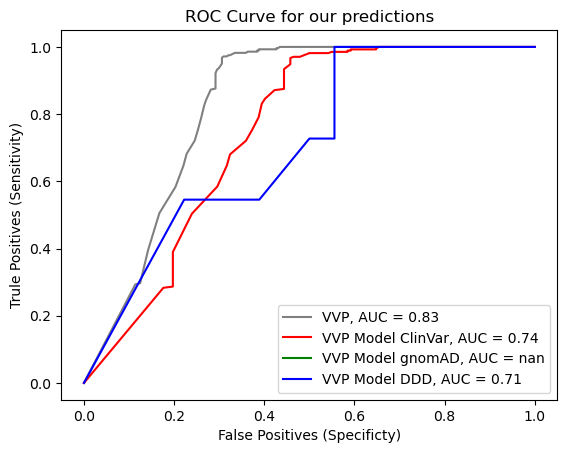

In [67]:
#Calculate the F1 score for VVP
ClinVarindels['VVP'] = pd.to_numeric(ClinVarindels['VVP'], errors='coerce')
gnomADindels['VVP'] = pd.to_numeric(gnomADindels['VVP'], errors='coerce')
DDDindels['VVP'] = pd.to_numeric(DDDindels['VVP'], errors='coerce')
# ClinVar

#Some of the columns in VVP contain no prediction, so filer the dataset
filtered_VVPClinVar = ClinVarindels.dropna(subset=['VVP'])
pred_VVPClinVar = filtered_VVPClinVar['VVP'].values
truelabels_VVPClinVar = filtered_VVPClinVar['labels_binary'].values

#The VVP predicts benig as 0, while pathogenic as 1. So have to change 0 to 1 and 1 to 0
truelabels_VVPClinVar -= 1
truelabels_VVPClinVar = np.abs(truelabels_VVPClinVar) 

#Calculating FP, TN and thresholds for VVP
fpr_VVPClinVar, tpr_VVPClinVar, thersholds_VVPClinVar = metrics.roc_curve(truelabels_VVPClinVar, pred_VVPClinVar)
roc_auc_VVPClinVar = round(metrics.auc(fpr_VVPClinVar, tpr_VVPClinVar), 2)

#Find the best threshold
tresh_VVPClinVar = thersholds_VVPClinVar[np.argmax(tpr_VVPClinVar - fpr_VVPClinVar)]

#Converting the continous predictions into binary
pred_VVP_binClinVar = [1 if x >= tresh_VVPClinVar else 0 for x in pred_VVPClinVar]

#Calculating F1 score
f1_VVPClinVar = f1_score(truelabels_VVPClinVar, pred_VVP_binClinVar, average = 'binary')

# gnomAD
#Some of the columns in VVP contain no prediction, so filer the dataset
filtered_VVPgnomAD = gnomADindels.dropna(subset=['VVP'])
pred_VVPgnomAD = filtered_VVPgnomAD['VVP'].values
truelabels_VVPgnomAD = filtered_VVPgnomAD['labels_binary'].values

#The VVP predicts benig as 0, while pathogenic as 1. So have to change 0 to 1 and 1 to 0
truelabels_VVPgnomAD -= 1
truelabels_VVPgnomAD = np.abs(truelabels_VVPgnomAD) 

#Calculating FP, TN and thresholds for VVP
fpr_VVPgnomAD, tpr_VVPgnomAD, thersholds_VVPgnomAD = metrics.roc_curve(truelabels_VVPgnomAD, pred_VVPgnomAD)
roc_auc_VVPgnomAD = round(metrics.auc(fpr_VVPgnomAD, tpr_VVPgnomAD), 2)

#Find the best threshold
tresh_VVPgnomAD = thersholds_VVPgnomAD[np.argmax(tpr_VVPgnomAD - fpr_VVPgnomAD)]

#Converting the continous predictions into binary
pred_VVP_bingnomAD = [1 if x >= tresh_VVPgnomAD else 0 for x in pred_VVPgnomAD]

#Calculating F1 score
f1_VVPgnomAD = f1_score(truelabels_VVPgnomAD, pred_VVP_bingnomAD, average = 'binary')

# DDD
#Some of the columns in VVP contain no prediction, so filer the dataset
filtered_VVPDDD = DDDindels.dropna(subset=['VVP'])
pred_VVPDDD = filtered_VVPDDD['VVP'].values
truelabels_VVPDDD = filtered_VVPDDD['labels_binary'].values

#The VVP predicts benig as 0, while pathogenic as 1. So have to change 0 to 1 and 1 to 0
truelabels_VVPDDD -= 1
truelabels_VVPDDD = np.abs(truelabels_VVPDDD) 

#Calculating FP, TN and thresholds for VVP
fpr_VVPDDD, tpr_VVPDDD, thersholds_VVPDDD = metrics.roc_curve(truelabels_VVPDDD, pred_VVPDDD)
roc_auc_VVPDDD = round(metrics.auc(fpr_VVPDDD, tpr_VVPDDD), 2)

#Find the best threshold
tresh_VVPDDD = thersholds_VVPDDD[np.argmax(tpr_VVPDDD - fpr_VVPDDD)]

#Converting the continous predictions into binary
pred_VVP_binDDD = [1 if x >= tresh_VVPDDD else 0 for x in pred_VVPDDD]

#Calculating F1 score
f1_VVPDDD = f1_score(truelabels_VVPDDD, pred_VVP_binDDD, average = 'binary')

print("F1 score VVP small indels:", f1_VVP)
print("F1 score VVP small indels ClinVar:", f1_VVPClinVar)
print("F1 score VVP small indels gnomAD:", f1_VVPgnomAD)
print("F1 score VVP small indels DDD:", f1_VVPDDD)

#Plotting the fit and Fit AUC 
plt.plot(fpr_VVP, tpr_VVP, label = "VVP, AUC = "+str(roc_auc_VVP), color = "grey")
plt.plot(fpr_VVPClinVar, tpr_VVPClinVar, label = "VVP Model ClinVar, AUC = "+str(roc_auc_VVPClinVar), color = "red")
plt.plot(fpr_VVPgnomAD, tpr_VVPgnomAD, label = "VVP Model gnomAD, AUC = "+str(roc_auc_VVPgnomAD), color = "green")
plt.plot(fpr_VVPDDD, tpr_VVPDDD, label = "VVP Model DDD, AUC = "+str(roc_auc_VVPDDD), color = "blue")
plt.xlabel('False Positives (Specificty)')
plt.ylabel('Trule Positives (Sensitivity)')
plt.title("ROC Curve for our predictions")
plt.legend(loc = 'best')
plt.show()

<BarContainer object of 12 artists>

<BarContainer object of 12 artists>

<BarContainer object of 12 artists>

([<matplotlib.axis.XTick at 0x741b3a3f5d00>,
 [Text(0, 0, "('Evo',))"),
  Text(1, 0, "('Fit',))"),
  Text(2, 0, "('IndeLLM best',))"),
  Text(3, 0, "('CADD',))"),
  Text(4, 0, "('CAPICE',))"),
  Text(5, 0, "('PROVEAN',))"),
  Text(6, 0, "('FATHMM',))"),
  Text(7, 0, "('MutT2021',))"),
  Text(8, 0, "('MutPred',))"),
  Text(9, 0, "('SIFT',))"),
  Text(10, 0, "('VEST',))"),
  Text(11, 0, "('VVP',))")])

Text(0.5, 1.0, 'F1 score between methods and origins')

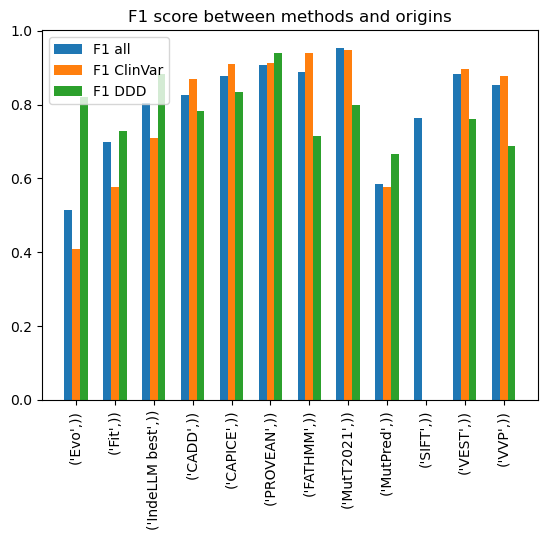

In [68]:
#Plotting the F1, ROC, accuracy and MCC scores together

F1origin = pd.DataFrame({'Method': ['Evo', 'Fit', 'IndeLLM best', 'CADD', 'CAPICE', 'PROVEAN', 'FATHMM', 'MutT2021', 'MutPred', 'SIFT', 'VEST', 'VVP'], 
      'F1 Score all indels': [f1_evo, f1_fit, f1_best, f1_CADD, f1_CAPICE, f1_PROVEAN, f1_FATHMM, f1_MutationTaster2021, f1_MutPredIndel, f1_SIFT, f1_VEST, f1_VVP], 
      'F1 Score ClinVar': [f1_evoClinVar, f1_fitClinVar, f1_bestClinVar, f1_CADDClinVar, f1_CAPICEClinVar, f1_PROVEANClinVar, f1_FATHMMClinVar, f1_MutationTaster2021ClinVar, f1_MutPredIndelClinVar, f1_SIFTClinVar, f1_VESTClinVar, f1_VVPClinVar], 
      'F1 Score DDD': [f1_evoDDD, f1_fitDDD, f1_bestDDD, f1_CADDDDD, f1_CAPICEDDD, f1_PROVEANDDD, f1_FATHMMDDD, f1_MutationTaster2021DDD, f1_MutPredIndelDDD, f1_SIFTDDD, f1_VESTDDD, f1_VVPDDD]})


labels = [f"{method})" for method in zip(F1origin['Method'])]

plt.bar(np.arange(len(F1origin)) - 0.2, F1origin['F1 Score all indels'], 0.2, label = 'F1 all')
plt.bar(np.arange(len(F1origin)) , F1origin['F1 Score ClinVar'], 0.2, label = 'F1 ClinVar')
plt.bar(np.arange(len(F1origin)) + 0.2, F1origin['F1 Score DDD'], 0.2, label = 'F1 DDD')
plt.xticks(np.arange(len(F1origin)), labels, rotation=90)
plt.title('F1 score between methods and origins')
plt.legend(loc = 'best')
plt.show()